In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statistics
import numpy as np
import os
import random
import matplotlib

from matplotlib import rc
from matplotlib.patches import Ellipse
import matplotlib.patches as mpatches
from matplotlib.pyplot import gcf
from scipy import stats

from sklearn.decomposition import PCA

rc('text', usetex=False)
rc('font', family='Arial')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

/tmp/ipykernel_1417639/3317972623.py:21: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## Get list of targets

In [2]:
targets = pd.read_csv('https://predictioncenter.org/casp15/targetlist.cgi?type=csv', sep = ';', error_bad_lines = False)
targets

b'Skipping line 34: expected 10 fields, saw 11\nSkipping line 35: expected 10 fields, saw 11\nSkipping line 43: expected 10 fields, saw 11\n'


Target        Type   Res Oligo.State  Entry Date  Server Exp.  \
0      T1104  All groups   117          A1  2022-05-02   2022-05-05   
1      T1105  All groups   331          A1  2022-05-03   2022-05-06   
2      H1106  All groups   236        A1B1  2022-05-04   2022-05-07   
3    T1106s1  All groups   122          A1  2022-05-04   2022-05-07   
4    T1106s2  All groups   114          A1  2022-05-04   2022-05-07   
..       ...         ...   ...         ...         ...          ...   
118    T1193  All groups  1297          A1  2022-07-26   2022-07-29   
119    T1194  All groups   168          A1  2022-07-27   2022-07-30   
120    T1195  All groups   279          A1  2022-07-27   2022-07-30   
121    T1196  All groups   361          A1  2022-07-28   2022-07-31   
122    T1197  All groups   289          A1  2022-07-29   2022-08-01   

     Human Exp.     QA Exp. Cancellation Date  \
0    2022-05-23           -                 -   
1    2022-05-24           -        2022-10-10   
2    2022-05-25  2022-05-28                 -   
3    2022-05-25           -                 -   
4    2022-05-25           -                 -   
..          ...         ...               ...   
118  2022-08-16           -        2022-09-13   
119  2022-08-17           -                 -   
120  2022-08-17           -                 -   
121  2022-08-18           -                 -   
122  2022-08-19           -                 -   

                                           Description  
0                                      EntV136  7roa    
1    Bacterial enzyme   <em><font color=red>Cancele...  
2                                     YscY-YscX 7qih    
3                                     YscY-YscX 7qih    
4                                     YscY-YscX 7qih    
..                                                 ...  
118  tunaPgp   <em><font color=red>Canceled (no tar...  
119                                          Bd1399     
120                              BRAF kinase domain     
121                              p38a kinase domain     
122                               Src kinase domain     

[123 rows x 10 columns]

In [3]:
cancelled_targets = []
for index, row in targets.iterrows():
    if 'canceled' in row.Description or 'Canceled' in row.Description:
        cancelled_targets.append(row.Target)

# Load tables

In [4]:
def load_casp_zscore_table(target_casp, cancelled_targets, mode = None, domains_only = False):
    
    if mode is not None:
        table = 'CASP{}/CASP{}_templates_table.csv'.format(target_casp, target_casp)
    else:
        table = 'CASP{}/CASP{}_Zscores_table.csv'.format(target_casp, target_casp)

    df = pd.read_csv(table, sep='\t').reset_index(drop=True)
    
    
    if domains_only:
        # remove the multidomain lines
        df = df[df.Target.str.contains("-D")]

    # remove the NaN models
    df = df[df['Model'].notna()]
    
    # add model ranking based on group
    if mode is None:            
        df['Model_GR_rank'] = [int(model.split('_')[-1].split('-')[0]) if model != 'Starting' else 0 for model in df.Model]
    else:
        # for the template tables, add as the group either that they are template, or the real structure
        df['GR#'] = ['TMP' if type(i) == str else 'REAL' for i in df.pdb]
                
    #df['Input_target'] = [target.replace('R', 'T') for target in df.Target]
    
    # exclude the cancelled targets    
    df = df[~df['Target'].isin(cancelled_targets)]
    df = df[df['Target'].notna()]

    
    return df

In [5]:
target_casp = '15'
domains_only = True
do_null = True

if domains_only:
    figures_folder = 'CASP{}/highres_figs_EXCLUDING_MULTIDOMAINS'.format(target_casp)
else:
    figures_folder = 'CASP{}/highres_figs'.format(target_casp)

if not do_null:
    figures_folder = '{}_NO_NULL'.format(figures_folder)
    
if not os.path.isdir(figures_folder):
    os.makedirs(figures_folder)

df = load_casp_zscore_table(target_casp, cancelled_targets, domains_only = domains_only)
df_templates = load_casp_zscore_table(target_casp, cancelled_targets, domains_only = domains_only, mode = 'template')

df_to_fix = df[df['S_geom_casp15'].isnull()]
df_to_fix['Target'].unique()

array([], dtype=object)

# Add in manually generated datasets

In [6]:
# Get group names and also information from abstracts
group_names_df = pd.read_csv('CASP{}/manually_curated_data/group_data.csv'.format(target_casp)).reset_index(drop=True)
group_names_df

group_names = {}
for group in group_names_df['GR#'].unique():
    group_names[str(group).zfill(3)] = group_names_df[group_names_df['GR#'] == group]['GR_name'].values[0]

# Get neff data for the target CASP
neff_df = pd.read_excel('CASP{}/manually_curated_data/casp_neff_values.xlsx'.format(target_casp))
casp_neff_df = neff_df[neff_df['CASP'] == f'CASP{target_casp}']

# Get information about secondary structure for CASP14/15
extra_info = 'CASP{}/manually_curated_data/ss_classification.csv'.format(target_casp, target_casp)
info_df = pd.read_csv(extra_info)
extra_info = 'CASP{}/manually_curated_data/ss_classification_casp14.csv'.format(target_casp, target_casp)
info_14_df = pd.read_csv(extra_info)

# Get LLG and reLLG values for comparison plot
llg_df = pd.read_csv('CASP{}/manually_curated_data/unmod_llg_scores.csv'.format(target_casp))
rellg_df = pd.read_csv('CASP{}/manually_curated_data/rellg_values.csv'.format(target_casp))


# Modify dataframes for use later on

In [7]:
# rename the columns of the templates table
new_names = []
for col in df_templates.columns:
    if '_GD' in col:
        col = col.replace('Template_', '')
    elif 'Template' in col and '_score' not in col:
        col = col.replace('Template', 'Model')
    new_names.append(col)
df_templates.columns = new_names

df_templates = df_templates.set_index('Model')

In [8]:
df['GR_type'] = ['Server' if x.endswith('s') else 'Manual' for x in df['GR#']]

# Some targets required groups to model multiple conformations and therefore the ordering is less meaningful. Uncomment to assess model order against actual order.
#targets_to_ignore = ['T1195-D1', 'T1196-D1', 'T1197-D1']
#df = df[~df['Target'].isin(targets_to_ignore)]

df_1st = df.loc[(df.Model_GR_rank == 1) & (df.Model.str.startswith('T'))]
df_1st = df_1st.groupby(['GR#']).filter(lambda s: s['GR#'].count()>=10)
df_1st

df_1st['GR_name'] = [group_names[str(x).replace('s', '')] if str(x).replace('s', '') in group_names.keys() else np.nan for x in df_1st['GR#'].values]
df_1st = df_1st[df_1st['GR_name'].notna()]
df['GR_name'] = [group_names[str(x).replace('s', '')] if str(x).replace('s', '') in group_names.keys() else np.nan for x in df['GR#'].values]


idx = df.groupby(['Target', 'GR#'])['GDT_HA'].transform(max) == df['GDT_HA']
df_best = df[idx]
df_best



Model  Unnamed: 0.1  Unnamed: 0.1.1   GR#  GDT_TS  GDT_HA  \
0      T1104TS092_1-D1           0.0             0.0   092   97.44   90.81   
1      T1104TS208_3-D1           1.0             1.0   208   97.44   91.24   
2      T1104TS035_1-D1           2.0             2.0  035s   97.22   90.81   
3      T1104TS367_3-D1           3.0             3.0   367   97.22   90.81   
5      T1104TS158_1-D1           5.0             5.0  158s   97.22   89.96   
...                ...           ...             ...   ...     ...     ...   
58625  T1197TS315_1-D1         428.0           428.0  315s   74.81   52.67   
58626  T1197TS052_1-D1         429.0           429.0   052   74.81   52.67   
58636  T1197TS123_1-D1         439.0           439.0   123   72.71   51.62   
58637  T1197TS140_2-D1         440.0           440.0   140   72.52   51.15   
58659  T1197TS006_1-D1         462.0           462.0   006    9.06    5.34   

       GDC_SC  GDC_ALL  RMS_CA  RMS_ALL  ...  GR_EMA  GR_ContN  GR_Auto  \
0       65.21    83.95   1.336    1.719  ...       Y       NaN        N   
1       64.65    84.07   1.330    1.723  ...     NaN       NaN      NaN   
2       64.34    83.88   1.390    1.763  ...     NaN       NaN      NaN   
3       64.77    83.92   1.381    1.753  ...     NaN       NaN      NaN   
5       64.40    83.55   1.386    1.755  ...     NaN       NaN      NaN   
...       ...      ...     ...      ...  ...     ...       ...      ...   
58625   25.87    44.99   3.192    3.937  ...       N       NaN        Y   
58626   25.87    44.99   3.192    3.937  ...     NaN       NaN      NaN   
58636   30.83    44.74   3.517    3.948  ...     NaN       NaN      NaN   
58637   28.66    39.70   3.069    3.686  ...       Y       NaN        Y   
58659    0.60     1.63  25.470   25.704  ...     NaN       NaN      NaN   

       GR_Cont  GR_MSA  GR_type  GR_DeepL  GR_CASP_serv  GR_Dist  \
0            Y       Y   Manual         Y             N        Y   
1          NaN     NaN   Manual       NaN           NaN      NaN   
2          NaN     NaN   Server       NaN           NaN      NaN   
3          NaN     NaN   Manual       NaN           NaN      NaN   
5          NaN     NaN   Server       NaN           NaN      NaN   
...        ...     ...      ...       ...           ...      ...   
58625        N       Y   Server         Y             Y        Y   
58626      NaN     NaN   Manual       NaN           NaN      NaN   
58636      NaN     NaN   Manual       NaN           NaN      NaN   
58637        N       N   Manual         Y             N        Y   
58659      NaN     NaN   Manual       NaN           NaN      NaN   

       Model_GR_rank  
0                  1  
1                  3  
2                  1  
3                  3  
5                  1  
...              ...  
58625              1  
58626              1  
58636              1  
58637              2  
58659              1  

[12348 rows x 143 columns]

In [9]:
# Create dictionary containing group names and Server/Manual designations
groups_data = {}
for group in df_1st['GR_name'].unique():
    groups_data[group] = df_1st[df_1st['GR_name'] == group]['GR_type'].values[0]

# START PLOTTING

## 1. MSA depth and other initial analysis

Neff versus secondary structure for CASP14 and CASP15

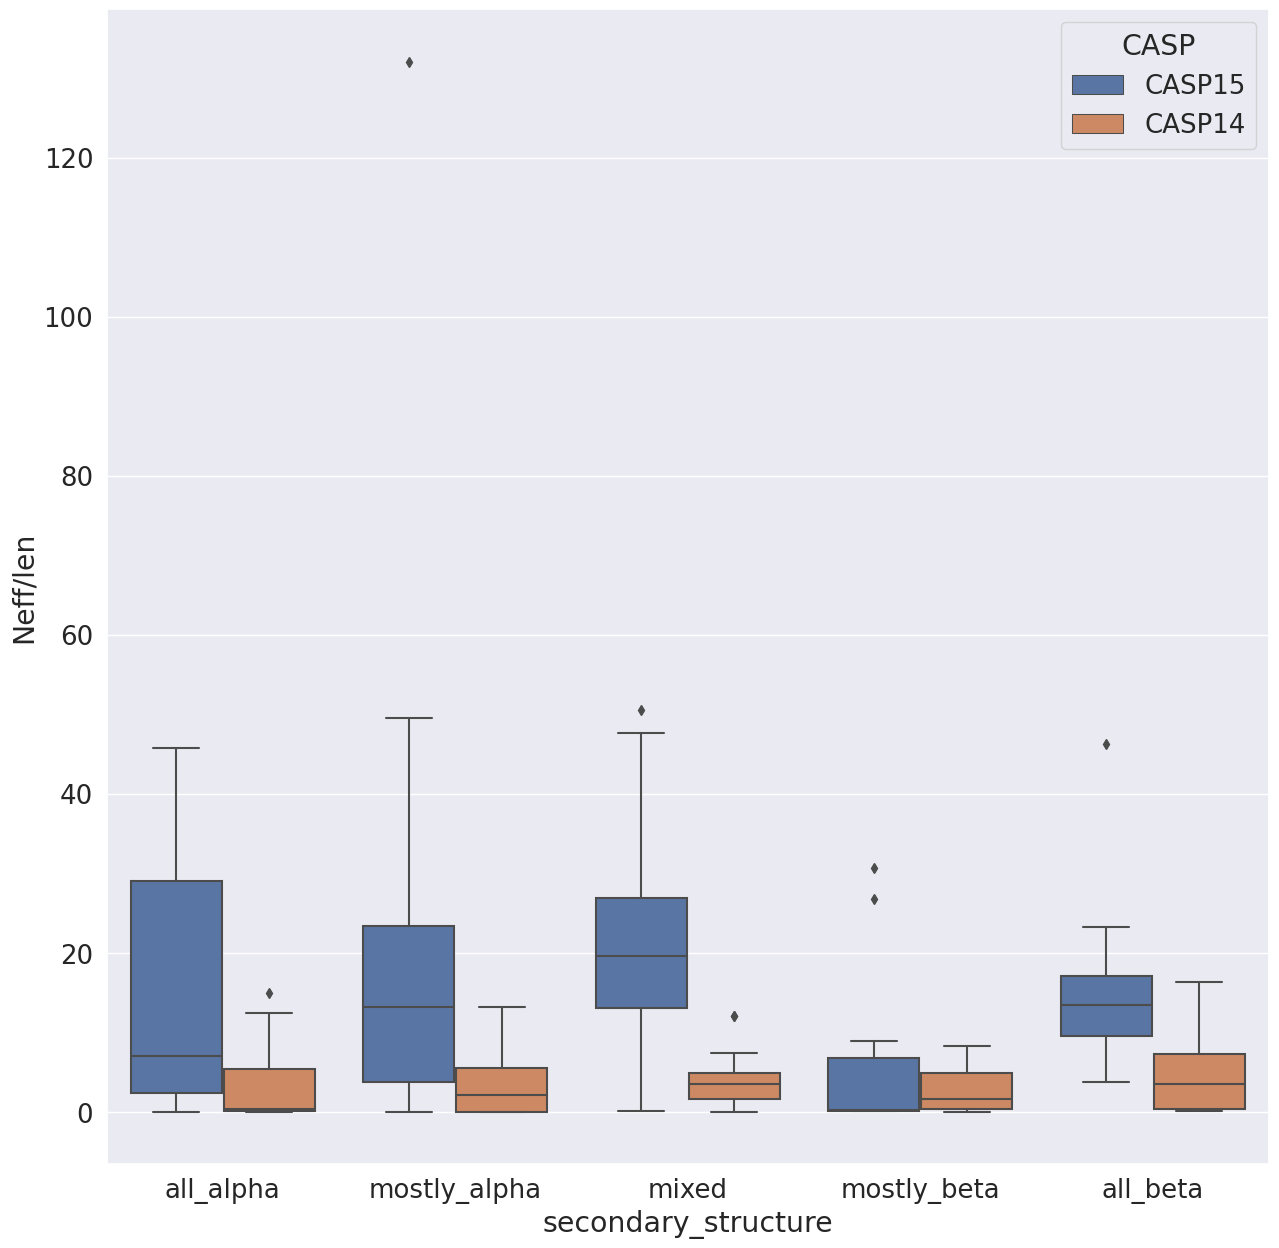

In [10]:
def neff_boxplot(target_df):
    sns.set_style("white")
    
    plt.figure(figsize=(15, 15))
    sns.set(font_scale=1.7)
    g = sns.boxplot(data=target_df, y="Neff/len", x="secondary_structure", hue="CASP", orient="v", order=['all_alpha', 'mostly_alpha', 'mixed', 'mostly_beta', 'all_beta'])
    plt.savefig('{}/neff_vs_casp_ss.png'.format(figures_folder))
    

ss = []
casp14_15_neff_df = neff_df[(neff_df['CASP'] == 'CASP15') | (neff_df['CASP'] == 'CASP14')]
for target in casp14_15_neff_df['Target'].values:
    try:
        ss.append(info_df[info_df['Target'] == target]['secondary_structure'].values[0])
    except:
        ss.append(info_14_df[info_14_df['Target'] == target]['secondary_structure'].values[0])

casp14_15_neff_df['secondary_structure'] = ss

neff_boxplot(casp14_15_neff_df)

Neff versus GDT_TS for representative MSA methods and pLM methods across all targets

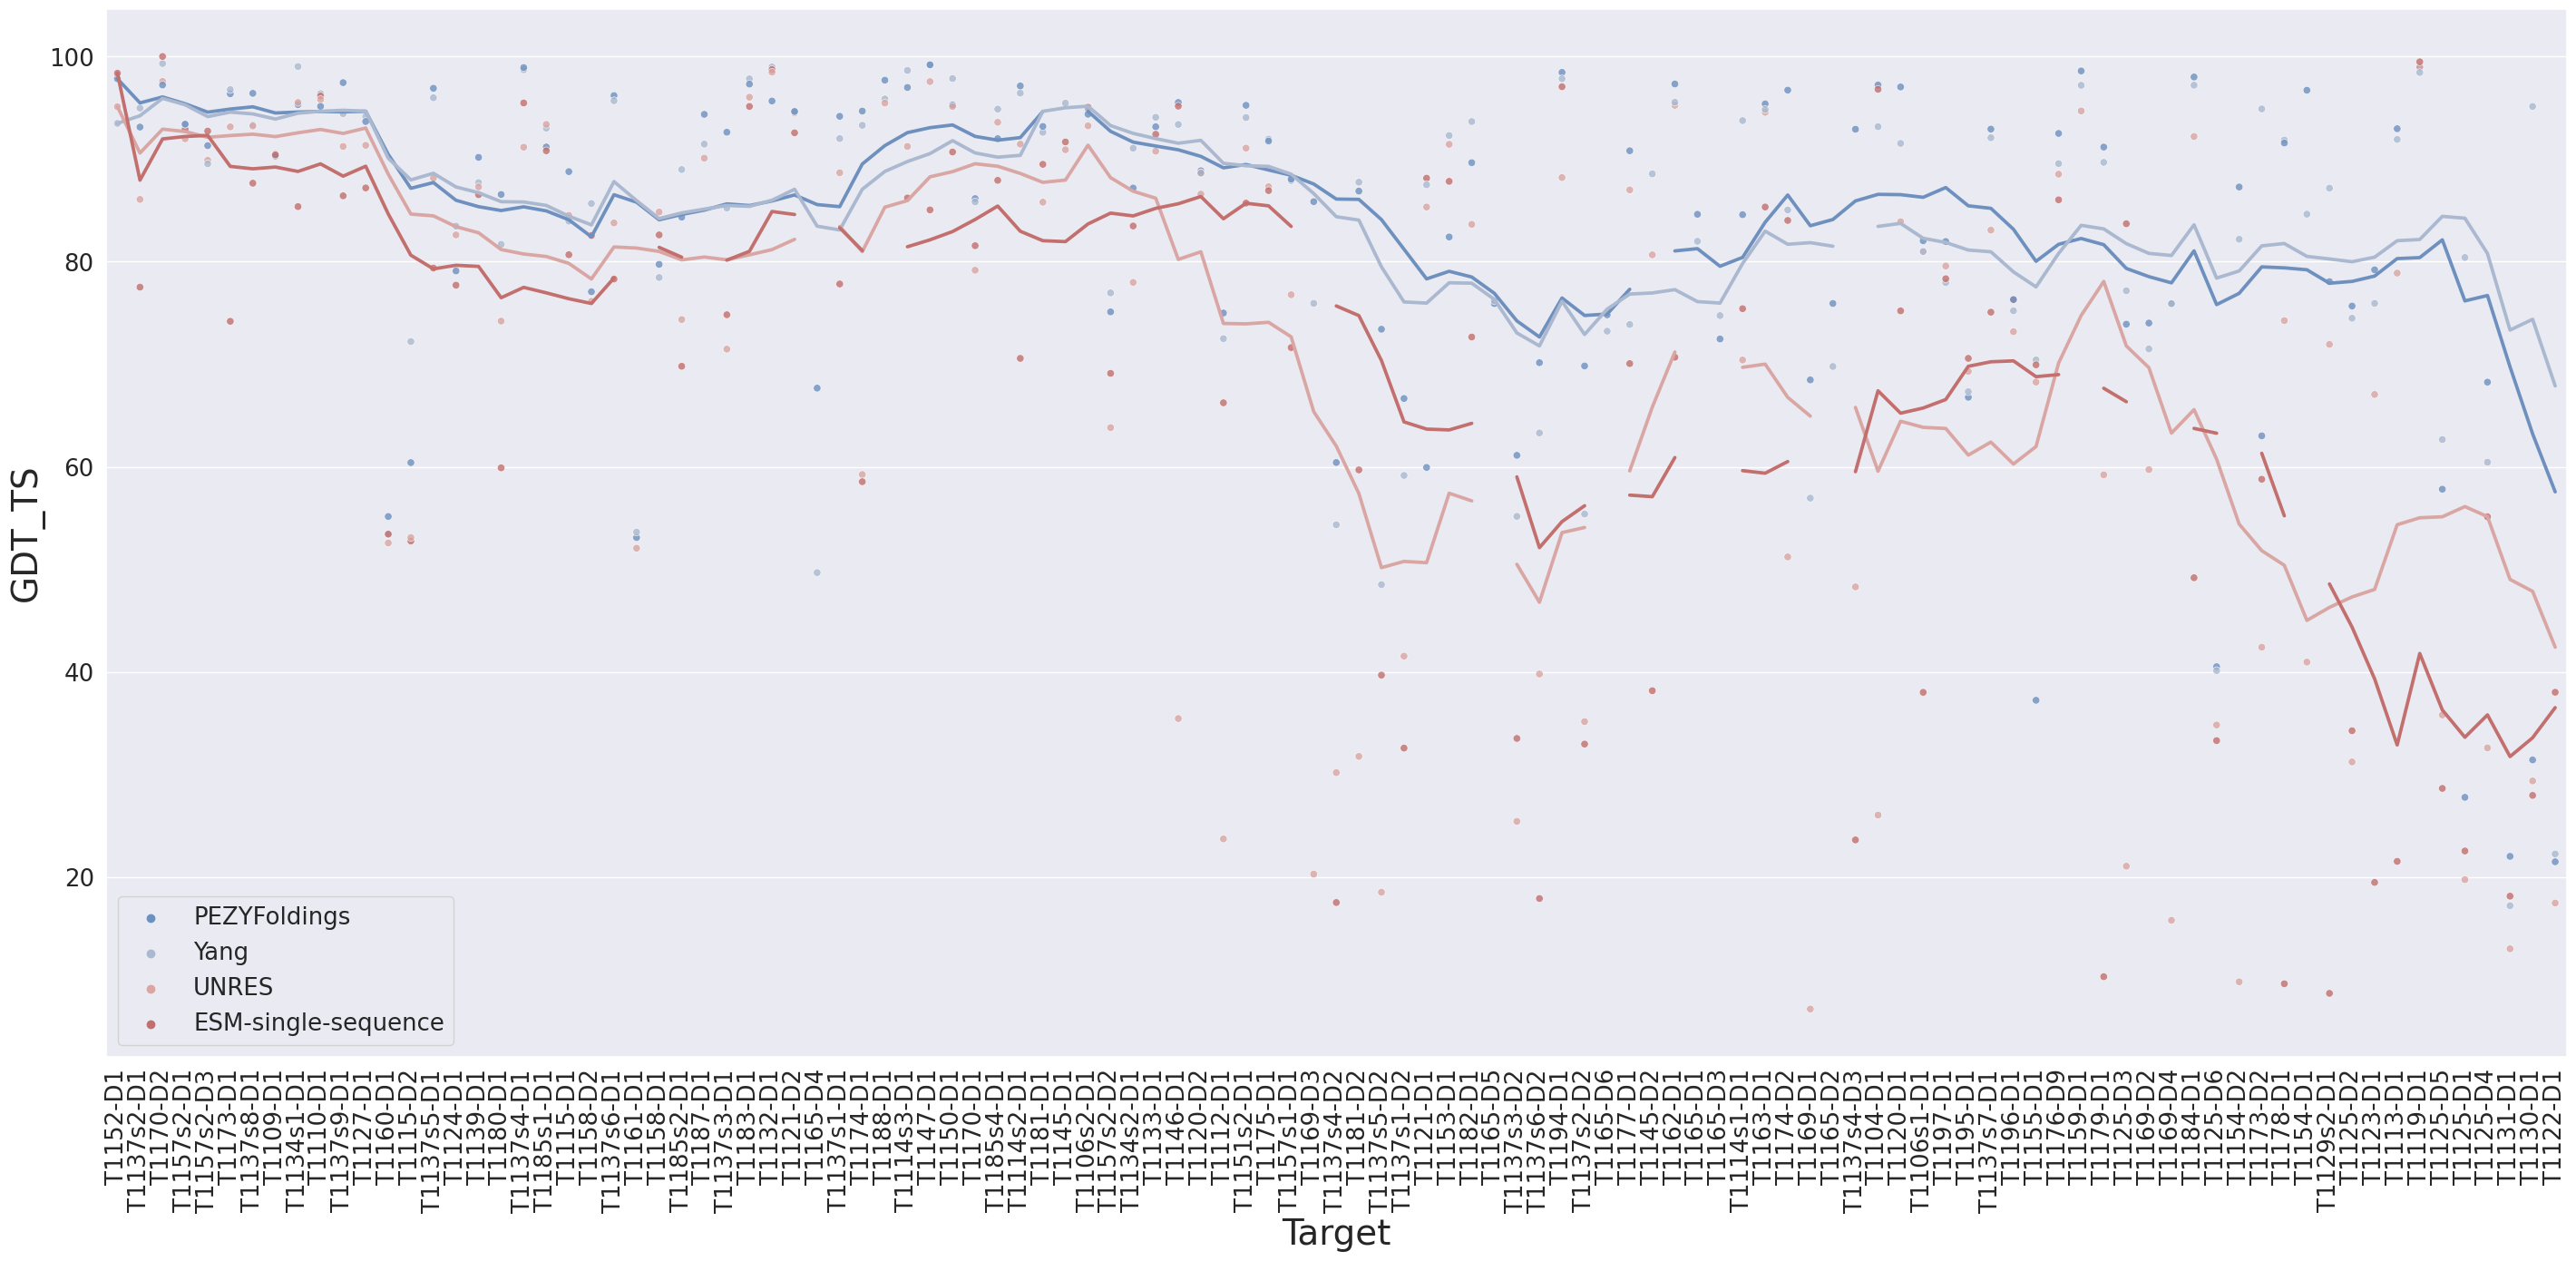

In [11]:
def neff_by_target(target_df):
    target_df = target_df[target_df['GR_name'].isin(['PEZYFoldings', 'Yang', 'UNRES', 'ESM-single-sequence'])]
    
    neffs = []
    for v in target_df['Target']:
        if v in neff_df['Target'].unique():
            neffs.append(neff_df[neff_df['Target'] == v]['Neff/len'].values[0])
        elif v.split('-')[0] in neff_df['Target'].unique():
            neffs.append(neff_df[neff_df['Target'] == v.split('-')[0]]['Neff/len'].values[0])
        else:
            neffs.append(target_df[target_df['Target'] == v]['Target_Neff'].values[0])
    target_df['Neff/len'] = neffs
    
    sorted_nb = target_df.groupby(['Target'])['Neff/len'].median().sort_values(ascending=False)
    target_df = target_df.sort_values('Neff/len', ascending=False)
    
    
    f, ax = plt.subplots(1, 1, figsize=(35, 15))
    sns.scatterplot(data=target_df, y="GDT_TS", x="Target", hue='GR_name', hue_order=['PEZYFoldings', 'Yang', 'UNRES', 'ESM-single-sequence'], alpha=0.8, ax=ax, palette=['#6e90bf', '#aab8d0', '#d9a6a4', '#c26f6d'])
    for group, colour in zip(['PEZYFoldings', 'Yang', 'UNRES', 'ESM-single-sequence'], ['#6e90bf', '#aab8d0', '#d9a6a4', '#c26f6d']):
        ma_df = target_df[target_df['GR_name'] == group]
        ma_df['SMA_GDT_TS'] = ma_df['GDT_TS'].rolling(10).mean()
        index = ma_df['SMA_GDT_TS'].index[ma_df['SMA_GDT_TS'].apply(np.isnan)]
        for e, idx in enumerate(index):
            ma_df['SMA_GDT_TS'].loc[idx] = ma_df['GDT_TS'].rolling(e+1).mean().loc[idx]
            
        for target in sorted_nb.index:
            if target not in ma_df['Target'].unique():
                new_row = {'Target' : target, 'SMA_GDT_TS': np.nan}
                ma_df = ma_df.append(new_row, ignore_index=True)
            
        sns.pointplot(data=ma_df, y="SMA_GDT_TS", x="Target", ax=ax, color=colour, order=list(sorted_nb.index), markers='')
    plt.xticks(rotation=90)
    plt.ylabel('GDT_TS', fontsize=28)
    plt.xlabel('Target', fontsize=28)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[0:], labels=labels[0:])
    
    minx, nextx, *_, maxx = ax.get_xticks()
    eps = (nextx - minx) / 2 
    ax.set_xlim(minx-eps, maxx+eps)
    
    
    plt.savefig('{}/plm_vs_msa_neff.png'.format(figures_folder), bbox_inches='tight')
    plt.show()

neff_by_target(df_1st)

Plots comparing secondary structure and oligomeric status between CASP14 and 15

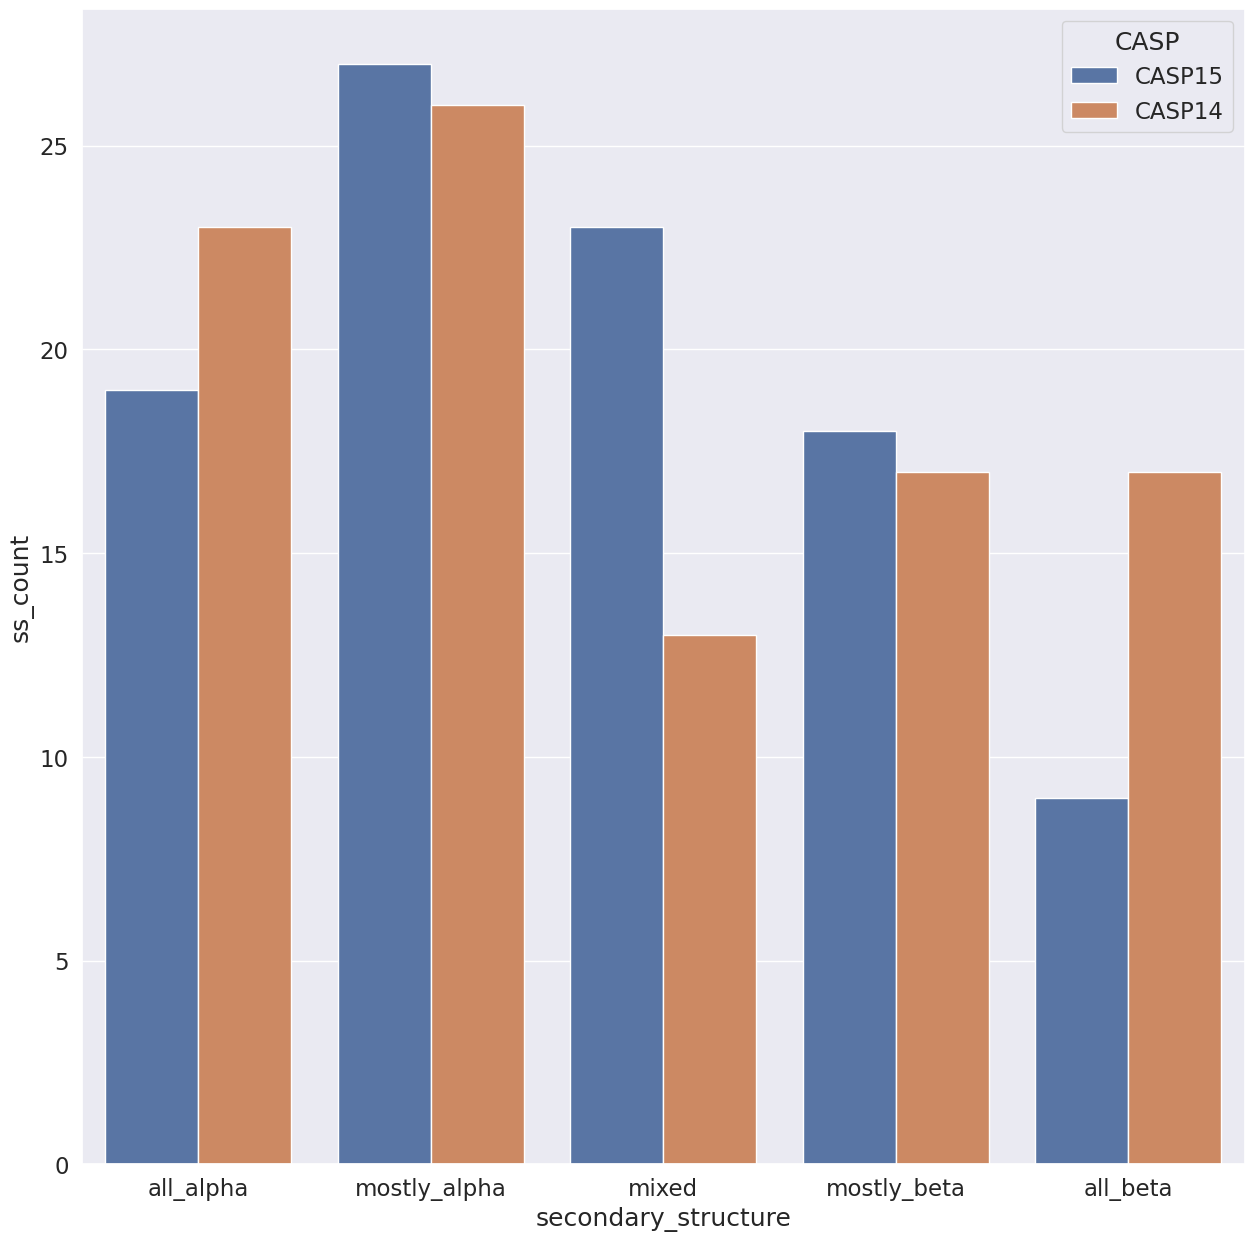

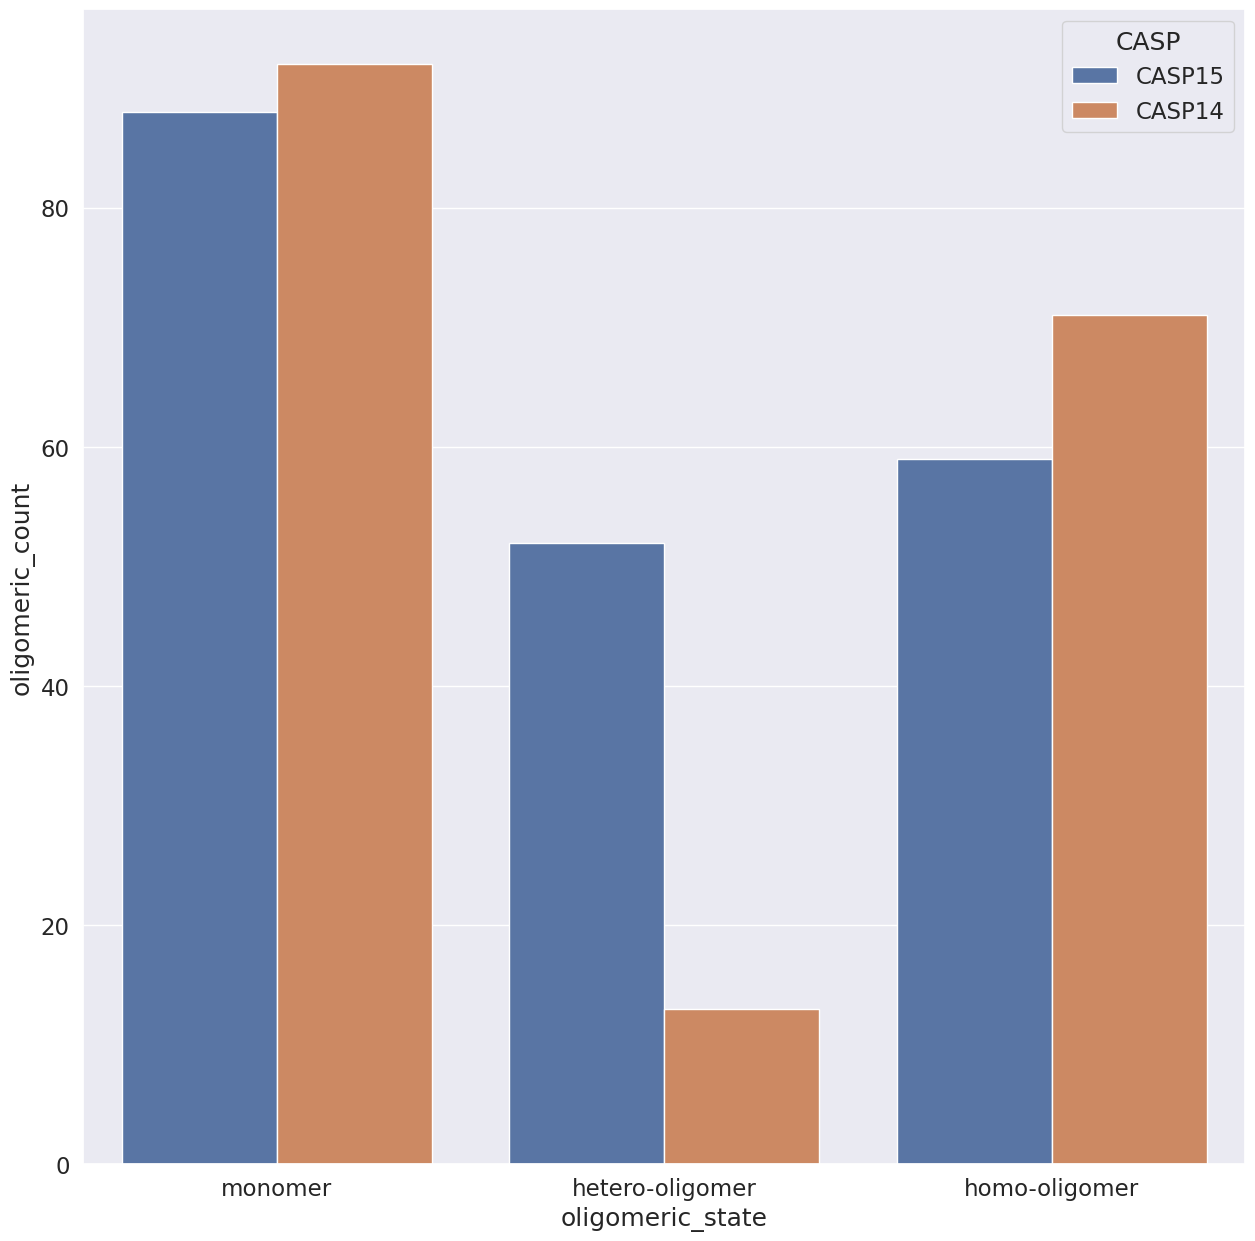

In [12]:
def ss_barchart(target_df):
    sns.set_style("white")
    
    plt.figure(figsize=(15, 15))
    sns.set(font_scale=1.5)
    g = sns.barplot(data=target_df, y="ss_count", x="secondary_structure", hue="CASP", orient="v")
    plt.savefig('{}/casp_ss.png'.format(figures_folder))
    plt.show()

def olig_barchart(target_df):
    sns.set_style("white")
    
    plt.figure(figsize=(15, 15))
    sns.set(font_scale=1.5)
    g = sns.barplot(data=target_df, y="oligomeric_count", x="oligomeric_state", hue="CASP", orient="v")
    plt.savefig('{}/casp_olig.png'.format(figures_folder))
    plt.show()
    
casps = []
ss_class = []
ss_count = []
for casp in casp14_15_neff_df['CASP'].unique():
    for secondary_structure in ['all_alpha', 'mostly_alpha', 'mixed', 'mostly_beta', 'all_beta']:
        casps.append(casp)
        ss_class.append(secondary_structure)
        ss_count.append(len(casp14_15_neff_df[(casp14_15_neff_df['CASP'] == casp) & (casp14_15_neff_df['secondary_structure'] == secondary_structure)]['secondary_structure']))

ss_casps = {'CASP': casps, 'secondary_structure': ss_class, 'ss_count': ss_count}
ss_barchart(pd.DataFrame(ss_casps))

casps = []
olig_class = []
olig_count = []
for casp in casp14_15_neff_df['CASP'].unique():
    for oligomeric_state in info_df['oligomeric_state'].unique():
        casps.append(casp)
        olig_class.append(oligomeric_state)
        if casp == 'CASP14':
            olig_count.append(len(info_14_df[info_14_df['oligomeric_state'] == oligomeric_state]['oligomeric_state']))
        if casp == 'CASP15':
            olig_count.append(len(info_df[info_df['oligomeric_state'] == oligomeric_state]['oligomeric_state']))

olig_casps = {'CASP': casps, 'oligomeric_state': olig_class, 'oligomeric_count': olig_count}
olig_barchart(pd.DataFrame(olig_casps))

## 2. Overall group rankings based on different metrics

Rank groups by target parameters. The ranking can be done by summing over the target parameter or taking a median.

In [13]:
def groups_barchart(df_1st, target_parameter, target_color, palette='Blues_r', plot_type='sum'):
    sns.set_style("white")
    
    if plot_type == 'sum':
        sorted_nb = df_1st.groupby(['GR_name'])[target_parameter].sum().sort_values(ascending=False)
    elif plot_type == 'median':
        sorted_nb = df_1st.groupby(['GR_name'])[target_parameter].median().sort_values(ascending=False)
    
    df_1st[target_color].fillna('?', inplace=True)
    summed_values = []
    for v in df_1st['GR_name']:
        summed_values.append(sorted_nb[v])
    df_1st[f'sum_{target_parameter}'] = summed_values
    
    #Highlight specific groups of interest     
    for group in ['NBIS-af2-standard', 'NBIS-af2-multimer', 'colabfold_human', 'ColabFold']:
        df_1st.loc[(df_1st['GR_name'] == group),'GR_type'] = 'ColabFold/AF2'
    
    for group in ['ESM-single-sequence', 'EMBER3D', 'UNRES']:
        df_1st.loc[(df_1st['GR_name'] == group),'GR_type'] = 'pLM methods'
     
    hue_order = ['Server', 'Manual', 'ColabFold/AF2', 'pLM methods']
    
    
    plt.figure(figsize=(25, 6))
    sns.set(font_scale=1.4)
    if plot_type == 'sum':
        sns.barplot(data=df_1st, x="GR_name", y=f'sum_{target_parameter}', estimator=np.median, ci=None, dodge=False, linewidth=0.5, edgecolor="k", hue=target_color, hue_order=hue_order, palette=palette, order=list(sorted_nb.index))
        if 'S_geom_casp' in target_parameter:
            label = 'S_{CASP' + target_parameter[-2:] + '}'
            plt.ylabel(rf'$\sum {label}$', fontsize=20)
        else:
            plt.ylabel(rf'$\sum {target_parameter}$', fontsize=20)
        output_label = "{}/groups_ranked_{}_colorby_{}_sum.png".format(figures_folder, target_parameter, target_color)
            
    elif plot_type == 'median':
        sns.barplot(data=df_1st, x="GR_name", y=f'{target_parameter}', estimator=np.median, ci=None, dodge=False, linewidth=0.5, edgecolor="k", hue=target_color, hue_order=hue_order, palette=palette, order=list(sorted_nb.index))
        if 'S_geom_casp' in target_parameter:
            label = 'S_{CASP' + target_parameter[-2:] + '}'
            plt.ylabel(rf'Median ${label}$', fontsize=20)
        elif 'QSE' in target_parameter:
            plt.ylabel(rf'Median Z_ASE', fontsize=20)
        else:
            plt.ylabel(rf'Median {target_parameter}', fontsize=20)
        output_label = "{}/groups_ranked_{}_colorby_{}_median.png".format(figures_folder, target_parameter, target_color)
    plt.xlim(-1, len(sorted_nb.head(100)))
    
    plt.xlabel('Group name', fontsize=20)
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=True,      # ticks along the bottom edge are on
        top=False,         # ticks along the top edge are off
        labelbottom=True) # labels along the bottom edge are on
    plt.xticks(rotation=90)
    plt.legend(title='Group type', loc='upper right', labels=hue_order)

    plt.tight_layout()
    
    plt.savefig(output_label)

    plt.show()
    plt.close()

CURRENT PARAMETER: S_geom_casp13
COLORED BY:        GR_type


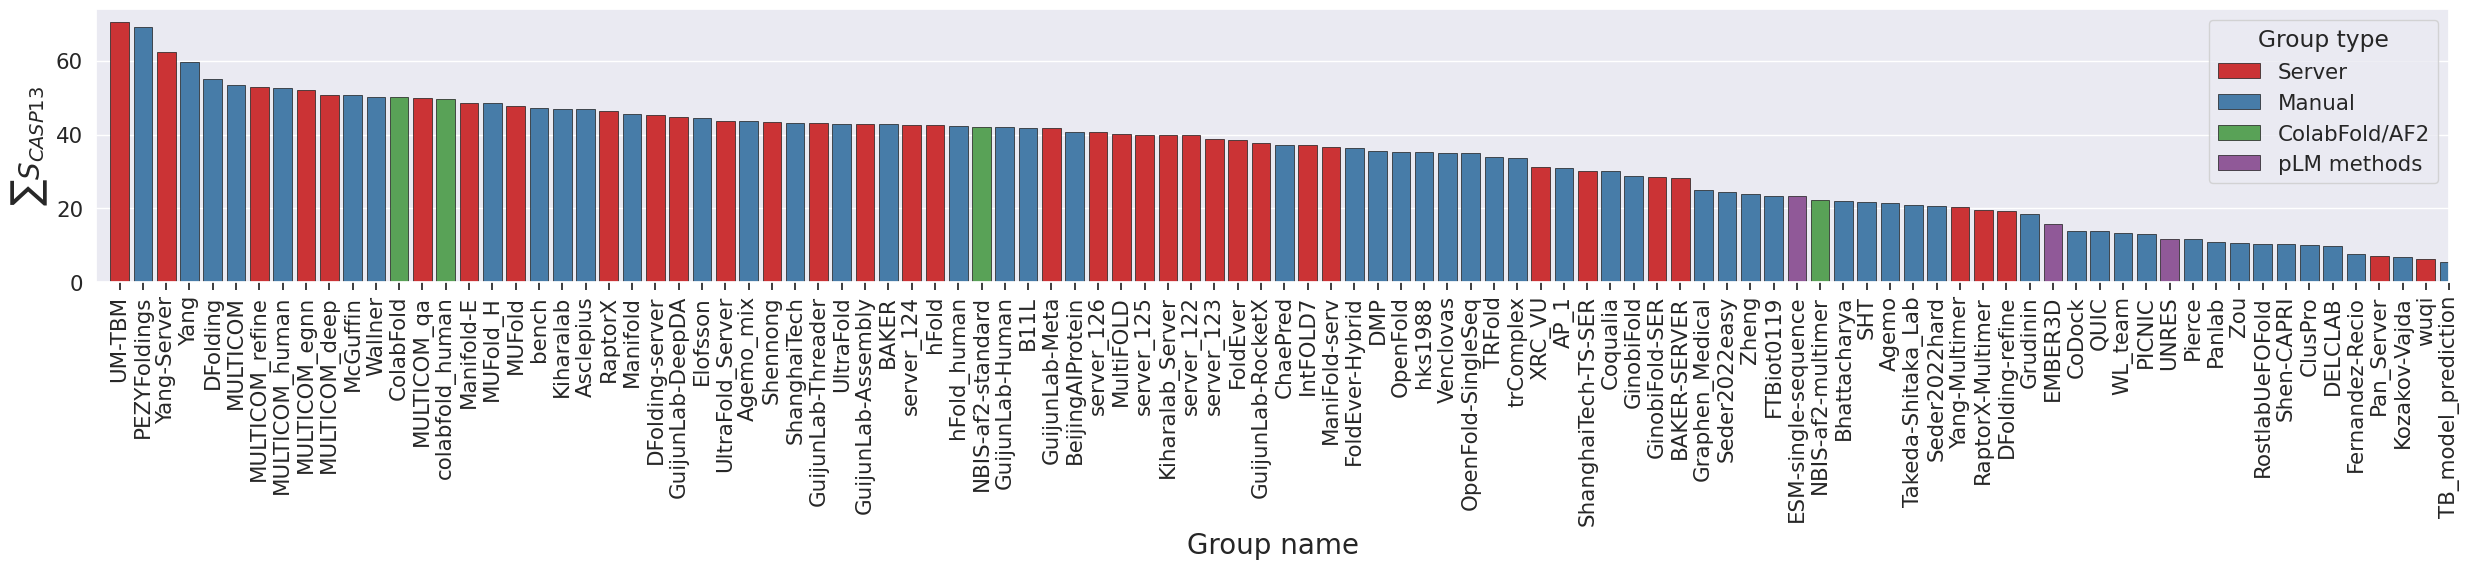

CURRENT PARAMETER: S_geom_casp14
COLORED BY:        GR_type


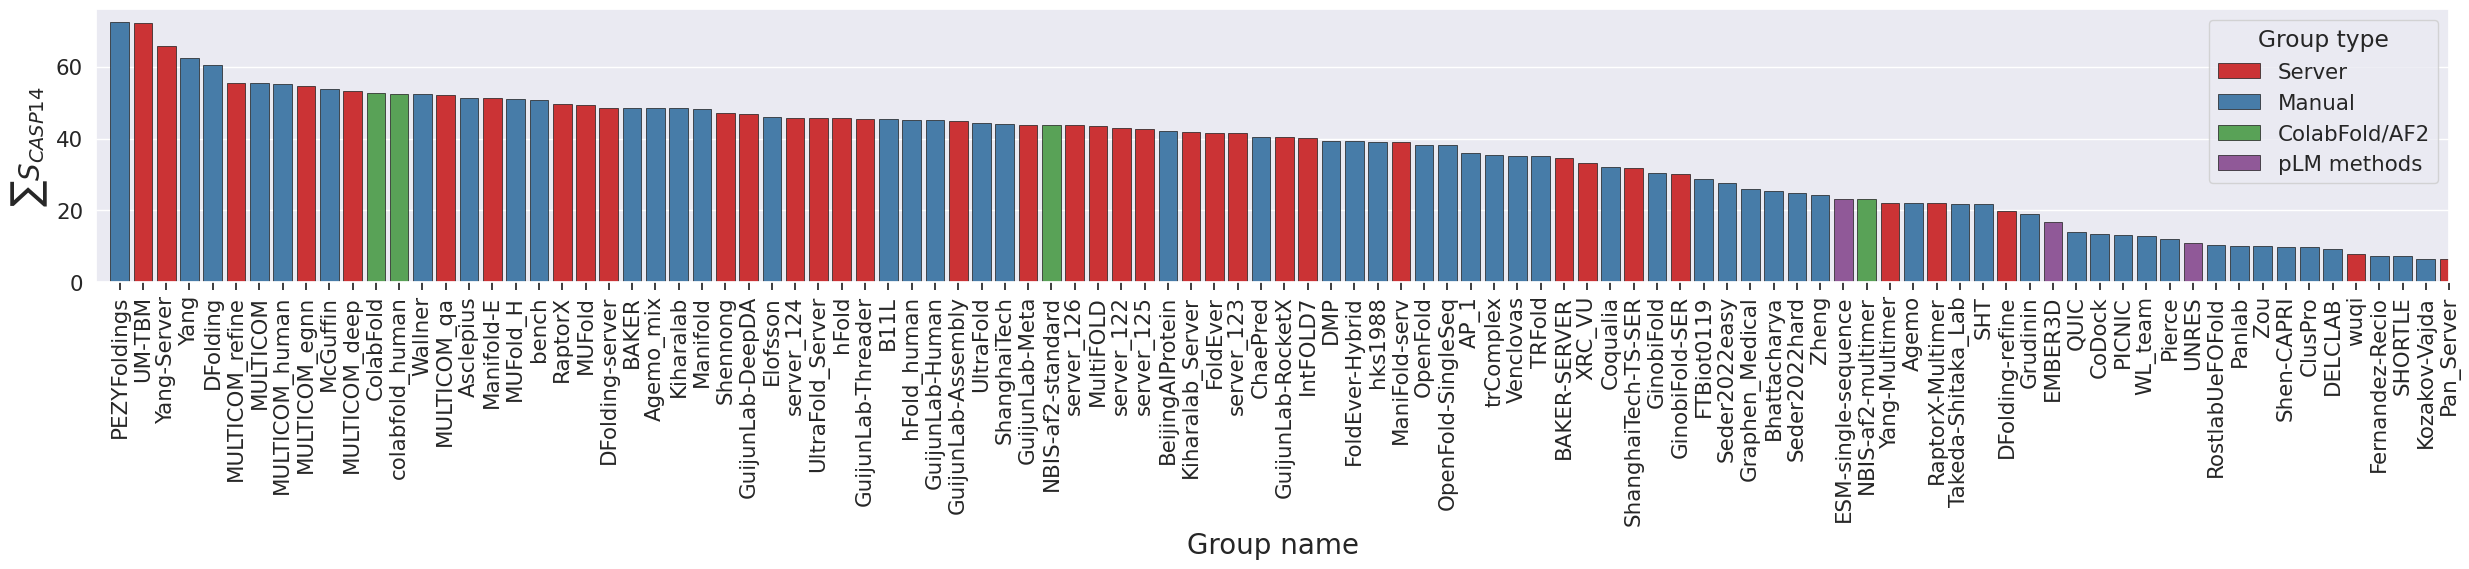

CURRENT PARAMETER: S_geom_casp15
COLORED BY:        GR_type


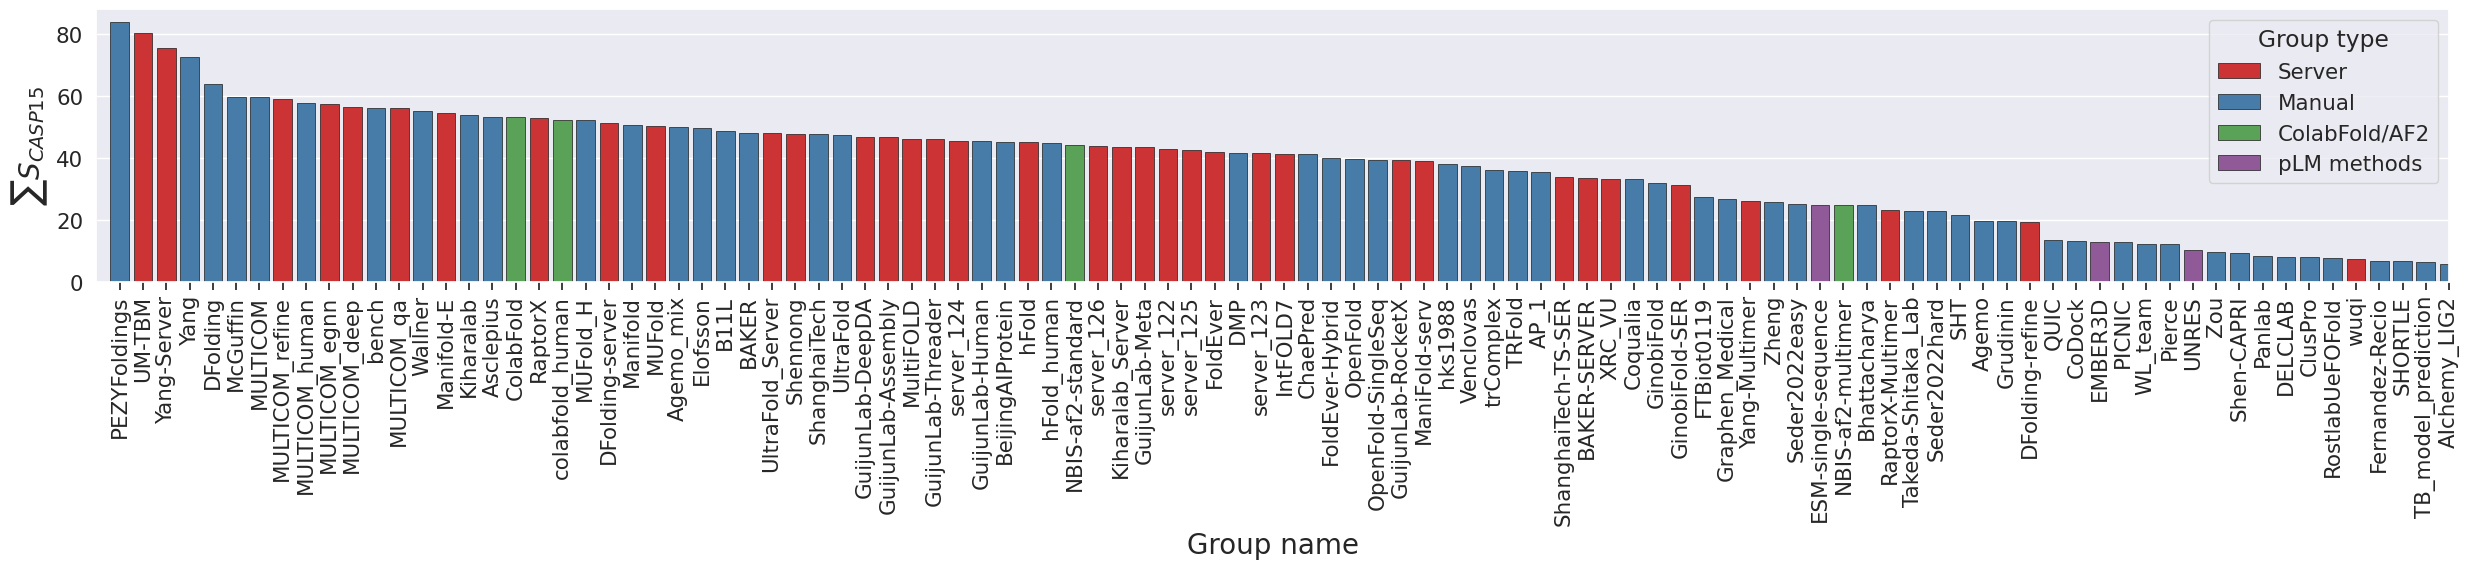

In [14]:
target_parameters = ['S_geom_casp13', 'S_geom_casp14', 'S_geom_casp15']
target_color = ['GR_type']
plot_type = 'sum'

df_1st_mod = df_1st
targets_to_drop = ['T1137s1-D2', 'T1137s2-D2', 'T1137s3-D2', 'T1137s4-D2', 'T1137s5-D2', 'T1137s6-D2']
for target in targets_to_drop:
    df_1st_mod = df_1st_mod.drop(df_1st_mod[df_1st_mod['Target'] == target].index)
    
for p in target_parameters:
    for c in target_color:
        print('CURRENT PARAMETER: {}'.format(p))
        print('COLORED BY:        {}'.format(c))
        groups_barchart(df_1st, p, c, palette='Set1', plot_type=plot_type)


Rank groups based on the number of 'best' models they acheived across all targets. Best defined by input parameter

In [15]:
parameter = 'GDT_HA'

idx = df_1st.groupby(['Target'])[parameter].transform(max) == df_1st[parameter]
df_tmp = df_1st[idx]
groups = {}
for group in df_tmp['GR_name']:
    if group in groups:
        groups[group] += 1
    else:
        groups[group] = 1

df_top_gr = pd.DataFrame(groups.items(), columns=['GR_name', 'top_ranks'])
df_top_grorient="v"


gr_types = []
for gr in df_top_gr['GR_name'].values:
    gr_types.append(df_tmp[df_tmp['GR_name'] == gr]['GR_type'].values[0])

df_top_gr['GR_type'] = gr_types

In [16]:
def top_first_model_barchart(df_top_gr, palette='Blues_r'):
    sorted_nb = df_top_gr.groupby(['GR_name'])['top_ranks'].sum().sort_values(ascending=False)
    hue_order = ['Server', 'Manual', 'ColabFold/AF2', 'pLM methods']
    
    sns.set(font_scale=1.4)
    f, ax = plt.subplots(figsize=(7, 20))
    sns.barplot(y='GR_name', x='top_ranks', data=df_top_gr, palette=palette, ci=None, dodge=False, hue='GR_type', hue_order=hue_order, linewidth=0.5, edgecolor="k", order=list(sorted_nb.index))
    sns.despine(left=True, bottom=True)
    ax.set(xlim=(0, max(df_top_gr['top_ranks'])), ylabel="Group Name", xlabel="Top first model count")
    plt.legend(title='Group type', loc='lower right', labels=hue_order)
    plt.ylabel('Group Name', fontsize=20)
    plt.xlabel('Top first model count by {}'.format(parameter), fontsize=20)
#     plt.xlabel('Top first model count by {}'.format('CASP15 score'), fontsize=20)
    plt.savefig("{}/groups_top_first_model_count_{}.png".format(figures_folder, parameter), bbox_inches='tight')
    plt.show()
    plt.close()

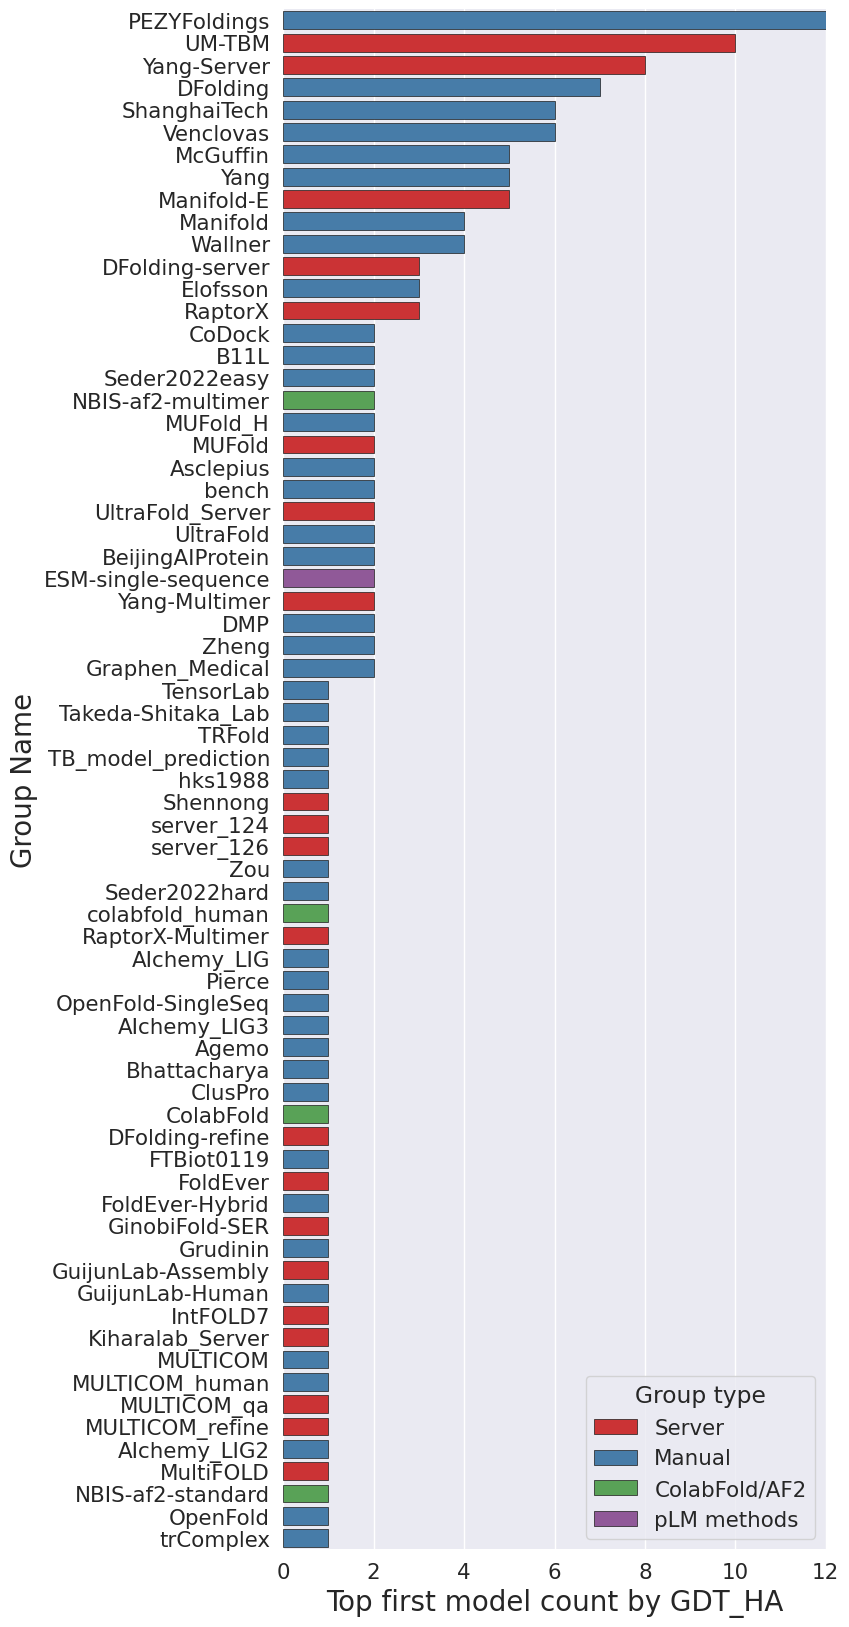

In [17]:
top_first_model_barchart(df_top_gr, palette='Set1')

In [18]:
param = 'GDT_TS'
param_df = df_1st[['GR#', 'Target', param, 'Target_classification']]

target_df = pd.DataFrame(columns=['Target', *param_df['GR#'].unique()])
for target in param_df['Target'].unique():
    results = [target]
    for group in param_df['GR#'].unique():
            try:
                results.append(param_df.loc[(param_df['Target'] == target) & (param_df['GR#'] == group)][param].values[0])
            except:
                results.append(-1)
    target_df.loc[len(target_df)] = results
        
target_df1 = target_df.set_index('Target')

# sns cluster map won't work if NaNs in the results. Ensure they're set to -1 so we can mask them out later. 
target_df2 = target_df1.fillna(-1)

classifications, ss, source, taxonomy = [], [], [], []
for target in target_df2.index:
    classifications.append(param_df.loc[(param_df['Target'] == target)]['Target_classification'].values[0])
    ss.append(info_df.loc[info_df['Target'] == target]['secondary_structure'].values[0])
    source.append(info_df.loc[info_df['Target'] == target]['source'].values[0])
    tax = info_df.loc[info_df['Target'] == target]['taxonomy'].values[0]
    if tax == 'Fungus':
        taxonomy.append('Eukaryotes')
    elif tax == 'De novo':
        taxonomy.append('Synthetic')
    else:
        taxonomy.append(tax)
        
man_ser = []
gn_dict = {}
for group in target_df2.columns:
    gn_dict[group] = group_names[group.replace('s', '')]
    if gn_dict[group] in ['NBIS-af2-standard', 'NBIS-af2-multimer', 'colabfold_human', 'ColabFold']:
        man_ser.append('ColabFold/AF2')
    elif group.endswith('s'):
        man_ser.append('Server')
    else:
        man_ser.append('Manual')

        
target_df2.rename(gn_dict, axis=1, inplace=True)

method, af_used, own_msa, other, refining_af, reranking_af, backup = [],[],[],[],[],[],[]
for group in target_df2.columns:
    gr_input = group_names_df.loc[(group_names_df['GR_name'] == group)]['GR_input'].values[0]
    if str(gr_input).upper() in ['MSA', 'PLM', 'NAN']:
        method.append(gr_input)
    else:
        method.append('other')
    
    af_used.append(group_names_df.loc[(group_names_df['GR_name'] == group)]['AF_used'].values[0])
    own_msa.append(group_names_df.loc[(group_names_df['GR_name'] == group)]['Own_MSA_for_AF'].values[0])
    other.append(group_names_df.loc[(group_names_df['GR_name'] == group)]['Other_modification_to_AF'].values[0])
    refining_af.append(group_names_df.loc[(group_names_df['GR_name'] == group)]['Refining_AF'].values[0])
    reranking_af.append(group_names_df.loc[(group_names_df['GR_name'] == group)]['Reranking_AF_RF'].values[0])
    backup.append(group_names_df.loc[(group_names_df['GR_name'] == group)]['AF_as_backup'].values[0])

In [19]:
# Set up dfs for each aditional row we wish to visualise

# https://stackoverflow.com/questions/27988846/how-to-express-classes-on-the-axis-of-a-heatmap-in-seaborn use for adding labels
classification_df = pd.DataFrame(columns=['Classification'], data=classifications)
cl_lut = dict(zip(classification_df['Classification'].unique(), sns.color_palette("husl", len(classification_df['Classification'].unique()))))
cl_row_colors = classification_df['Classification'].map(cl_lut)

taxonomy_df = pd.DataFrame(columns=['Taxonomy'], data=taxonomy)
tax_lut = dict(zip(taxonomy_df['Taxonomy'].unique(), sns.color_palette("Set2", len(taxonomy_df['Taxonomy'].unique()))))
tax_row_colors = taxonomy_df['Taxonomy'].map(tax_lut)

row_colours = pd.DataFrame(cl_row_colors).join(pd.DataFrame(tax_row_colors))

man_ser_df = pd.DataFrame(columns=['Manual_or_Server'], data=man_ser)
m_lut = dict(zip(['Server', 'Manual', 'ColabFold/AF2'], sns.color_palette("Set1", len(man_ser_df['Manual_or_Server'].unique()))))
m_col_colors = man_ser_df['Manual_or_Server'].map(m_lut)

method_df = pd.DataFrame(columns=['Method'], data=method)
custom_cmap = [(0.86, 0.3712, 0.34), (0.8, 0.8, 0.8), (0.34, 0.8288, 0.86), (0.596078431372549, 0.3058823529411765, 0.6392156862745098)]
met_lut = dict(zip(['MSA', np.nan, 'other', 'pLM'], custom_cmap))
met_col_colors = method_df['Method'].map(met_lut)

af_used_df = pd.DataFrame(columns=['AF_used'], data=af_used)
custom_cmap = [(0.4, 0.7607843137254902, 0.6470588235294118), (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), (0.8, 0.8, 0.8)]
afu_lut = dict(zip(['Yes', 'No', np.nan], custom_cmap))
afu_col_colors = af_used_df['AF_used'].map(afu_lut)

col_colours = pd.DataFrame(m_col_colors).join(pd.DataFrame(met_col_colors)).join(pd.DataFrame(afu_col_colors))

# Removed for final figure:
# ss_df = pd.DataFrame(columns=['Secondary_Structure'], data=ss)
# ss_lut = dict(zip(ss_df['Secondary_Structure'].unique(), sns.color_palette("hls", len(ss_df['Secondary_Structure'].unique()))))
# ss_row_colors = ss_df['Secondary_Structure'].map(ss_lut)

# source_df = pd.DataFrame(columns=['Source'], data=source)
# src_lut = dict(zip(source_df['Source'].unique(), sns.color_palette("viridis", len(source_df['Source'].unique()))))
# src_row_colors = source_df['Source'].map(src_lut)

# own_msa_df = pd.DataFrame(columns=['own_msa'], data=own_msa)
# om_lut = dict(zip(own_msa_df['own_msa'].unique()[::-1], sns.color_palette("Set2", len(own_msa_df['own_msa'].unique()))))
# om_col_colors = own_msa_df['own_msa'].map(om_lut)

# other_df = pd.DataFrame(columns=['other'], data=other)
# other_lut = dict(zip(other_df['other'].unique()[::-1], sns.color_palette("Set2", len(other_df['other'].unique()))))
# other_col_colors = other_df['other'].map(other_lut)
# other_col_colors = other_df['other'].map(om_lut)

# refining_af_df = pd.DataFrame(columns=['refining_af'], data=refining_af)
# reref_lut = dict(zip(refining_af_df['refining_af'].unique()[::-1], sns.color_palette("Set2", len(refining_af_df['refining_af'].unique()))))
# reref_col_colors = refining_af_df['refining_af'].map(reref_lut)

# reranking_af_df = pd.DataFrame(columns=['reranking_af'], data=reranking_af)
# rerank_lut = dict(zip(reranking_af_df['reranking_af'].unique()[::-1], sns.color_palette("Set2", len(reranking_af_df['reranking_af'].unique()))))
# rerank_col_colors = reranking_af_df['reranking_af'].map(rerank_lut)

# backup_df = pd.DataFrame(columns=['backup'], data=backup)
# bkup_lut = dict(zip(backup_df['backup'].unique()[::-1], sns.color_palette("Set2", len(backup_df['backup'].unique()))))
# bkup_col_colors = backup_df['backup'].map(om_lut)

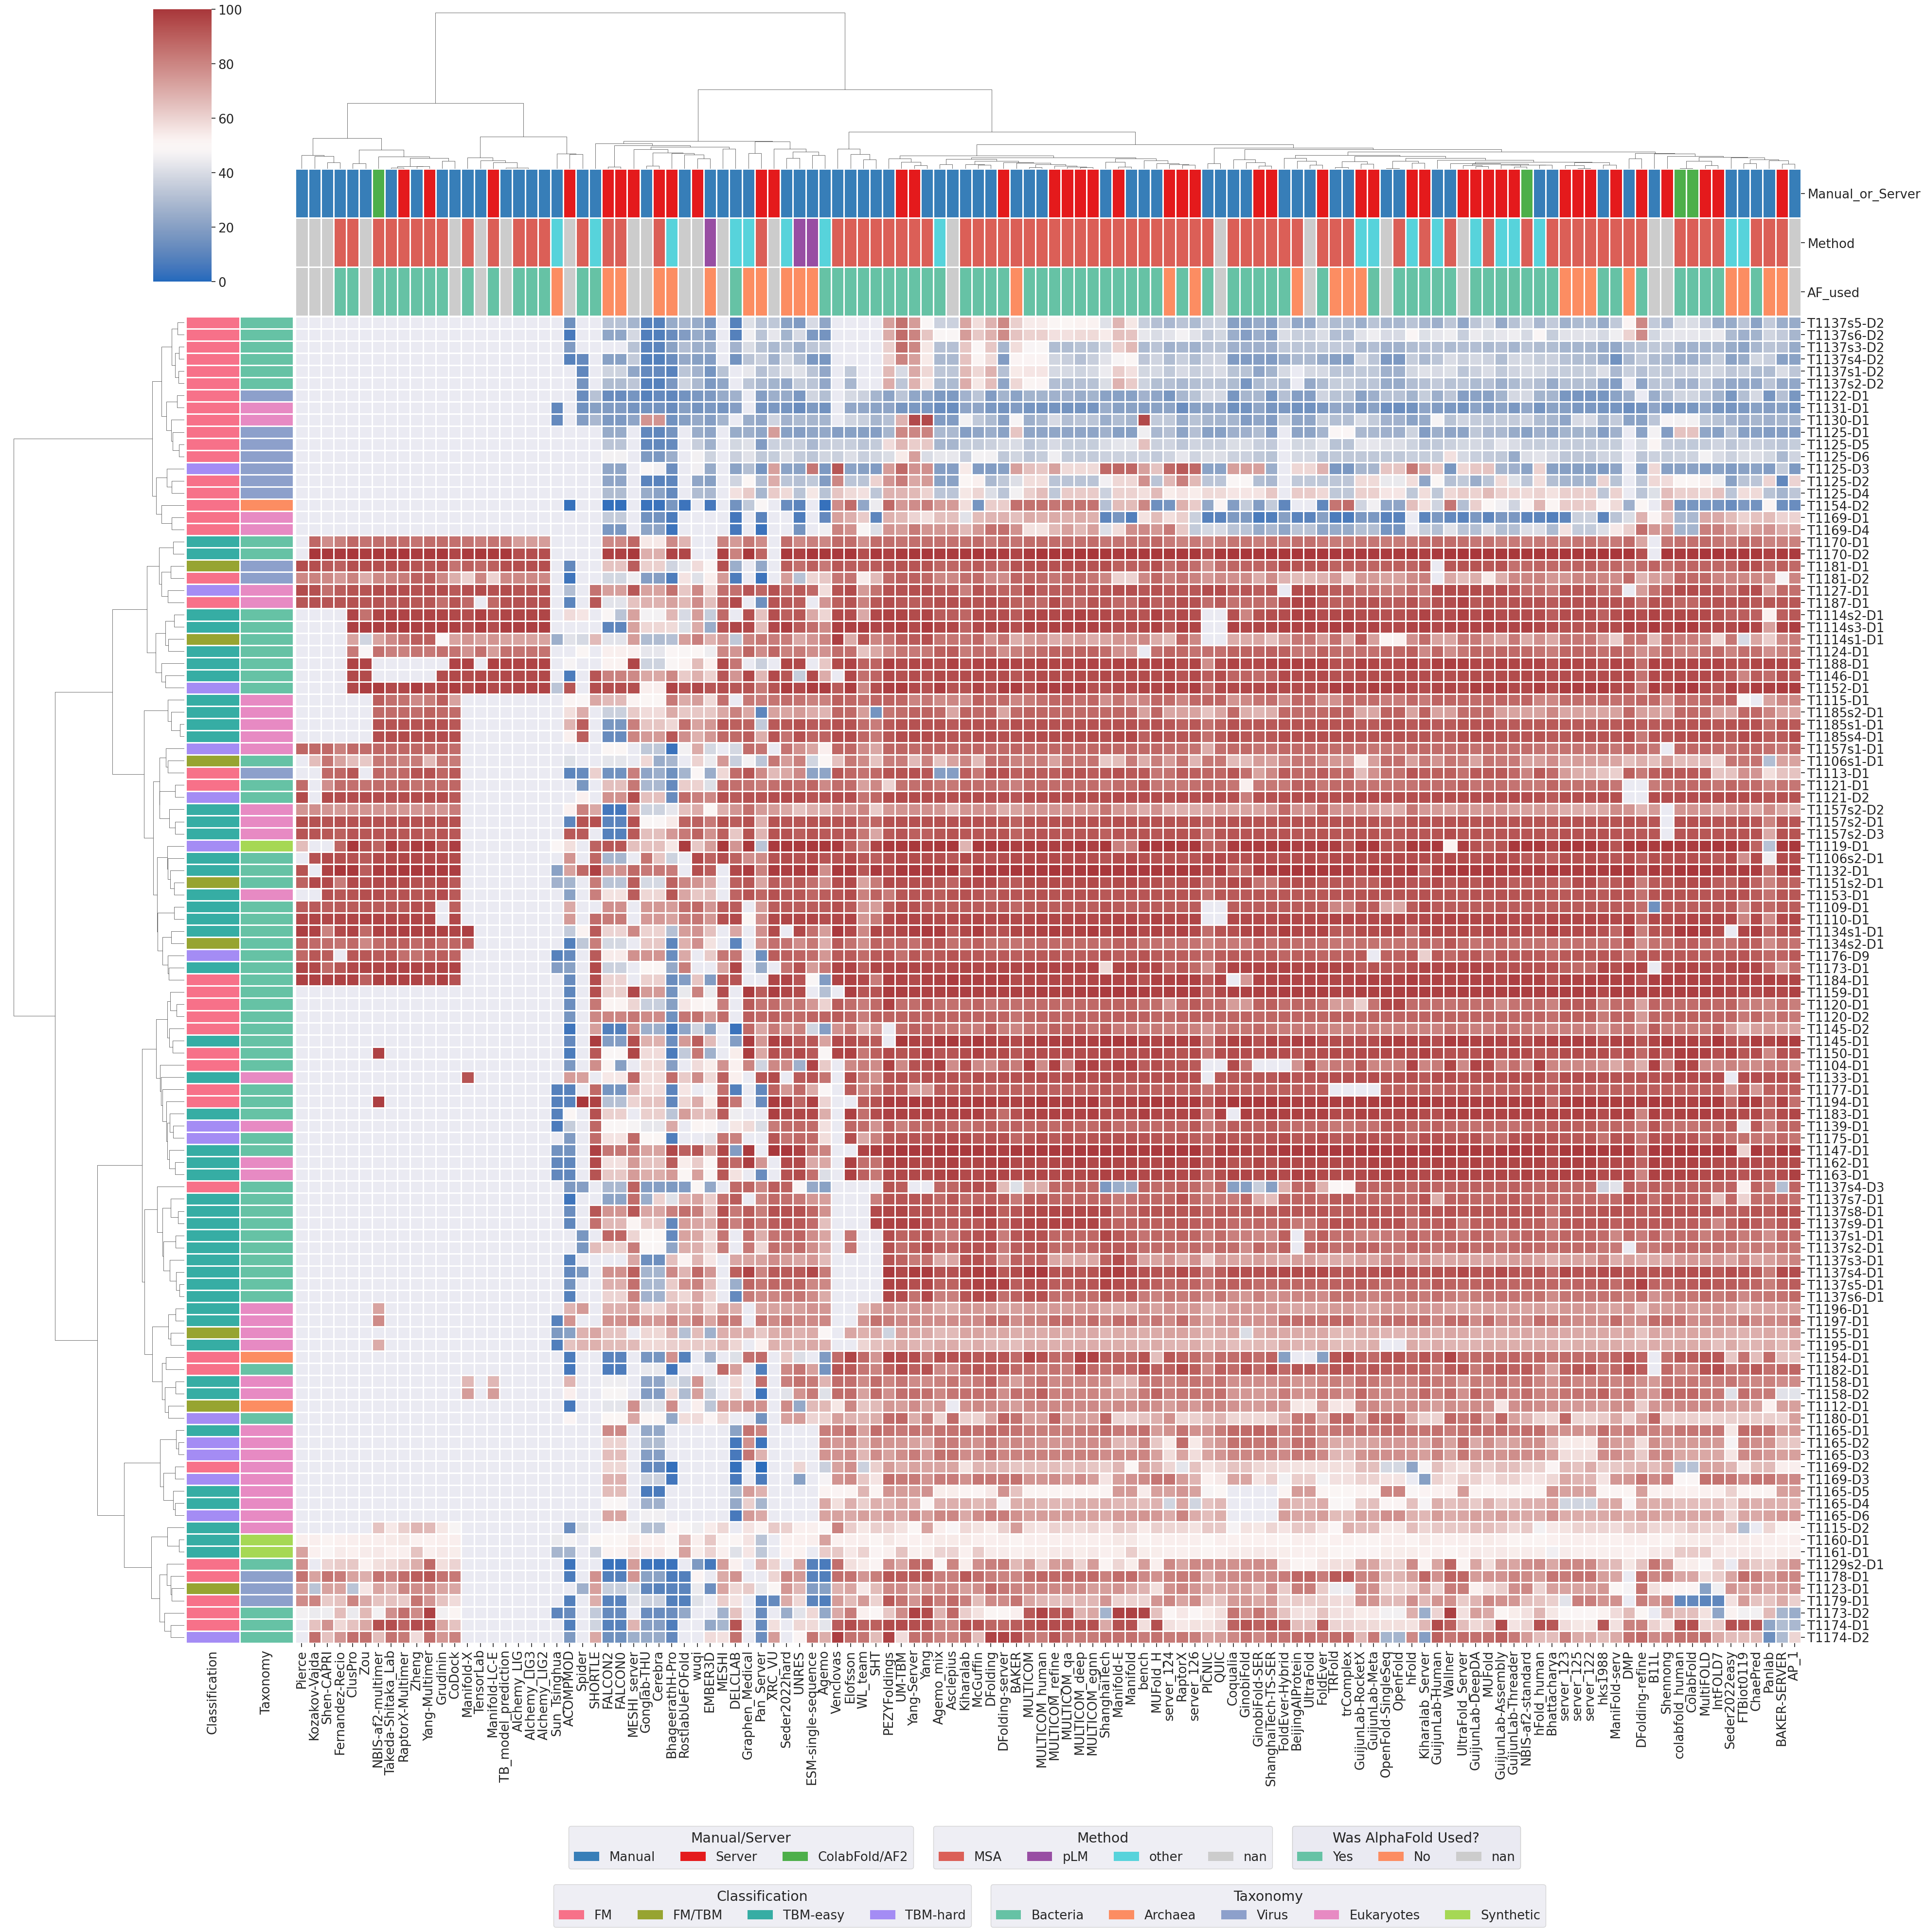

In [20]:
# Stupid issue where row/column colours don't show unless index removed. Making a plot to get the x/y labels in the correct order and then add them into the plot with the index removed. 
g1 = sns.clustermap(target_df2, cmap="vlag", row_colors=row_colours, col_colors=col_colours, figsize=(40, 40), center=50, vmin=0, vmax=100, xticklabels=True, yticklabels=True, dendrogram_ratio=(.2, .2), linewidths=1, method='ward')
xlabels = g1.ax_heatmap.get_xticklabels()
ylabels = g1.ax_heatmap.get_yticklabels()
plt.close()

sns.set(font_scale=1.7)
modified_df = target_df2.reset_index(drop=True)
modified_df.columns = range(len(modified_df.columns))
mask = modified_df.isin([-1])
g = sns.clustermap(modified_df, cmap="vlag", row_colors=row_colours, col_colors=col_colours, figsize=(40, 40), center=50, vmin=0, vmax=100, xticklabels=True, yticklabels=True, dendrogram_ratio=(.1, .1), linewidths=1, mask=mask, method='ward')
g.ax_heatmap.set_xticklabels(xlabels)
g.ax_heatmap.set_yticklabels(ylabels)
g.ax_heatmap.tick_params(bottom=True)

# Code to move column labels into the right places, these have been manually placed in the correct spots
shift = 0.03
g.figure.subplots_adjust(bottom=0.15)
for label in classification_df['Classification'].unique():
    g.ax_col_dendrogram.bar(0, 0, color=cl_lut[label], label=label, linewidth=0)
l1 = g.ax_col_dendrogram.legend(title='Classification', loc="center", ncol=5, bbox_to_anchor=(0.367 +shift, 0.015), bbox_transform=gcf().transFigure)

xx = []
for label in taxonomy_df['Taxonomy'].unique():
    x = g.ax_row_dendrogram.bar(0, 0, color=tax_lut[label], label=label, linewidth=0)
    xx.append(x)
l2 = plt.legend(xx, taxonomy_df['Taxonomy'].unique(), loc="center", title='Taxonomy', ncol=5, bbox_to_anchor=(0.627+shift, 0.015), bbox_transform=gcf().transFigure)
plt.gca().add_artist(l2)


xx = []
for label in man_ser_df['Manual_or_Server'].unique():
    x = g.ax_row_dendrogram.bar(0, 0, color=m_lut[label], label=label, linewidth=0)
    xx.append(x)
l3 = plt.legend(xx, man_ser_df['Manual_or_Server'].unique(), loc="center", title='Manual/Server', ncol=5, bbox_to_anchor=(0.356+shift, 0.045), bbox_transform=gcf().transFigure)
plt.gca().add_artist(l3)

xx = []
for label in ['MSA', 'pLM', 'other', np.nan]:
    x = g.ax_row_dendrogram.bar(0, 0, color=met_lut[label], label=label, linewidth=0)
    xx.append(x)
l4 = plt.legend(xx, ['MSA', 'pLM', 'other', np.nan], loc="center", title='Method', ncol=4, bbox_to_anchor=(0.542+shift, 0.045), bbox_transform=gcf().transFigure)
plt.gca().add_artist(l4)


xx = []
for label in ['Yes', 'No', np.nan]:
    x = g.ax_row_dendrogram.bar(0, 0, color=afu_lut[label], label=label, linewidth=0)
    xx.append(x)
l5 = plt.legend(xx, ['Yes', 'No', np.nan], loc="center", title='Was AlphaFold Used?', ncol=5, bbox_to_anchor=(0.698+shift, 0.045), bbox_transform=gcf().transFigure)
plt.gca().add_artist(l5)


g.cax.set_position([.084, .85, .03, .14 ])
g.figure.show()
g.figure.savefig("{}/correlation_matrix_targets_and_groups_final_fig.png".format(figures_folder))

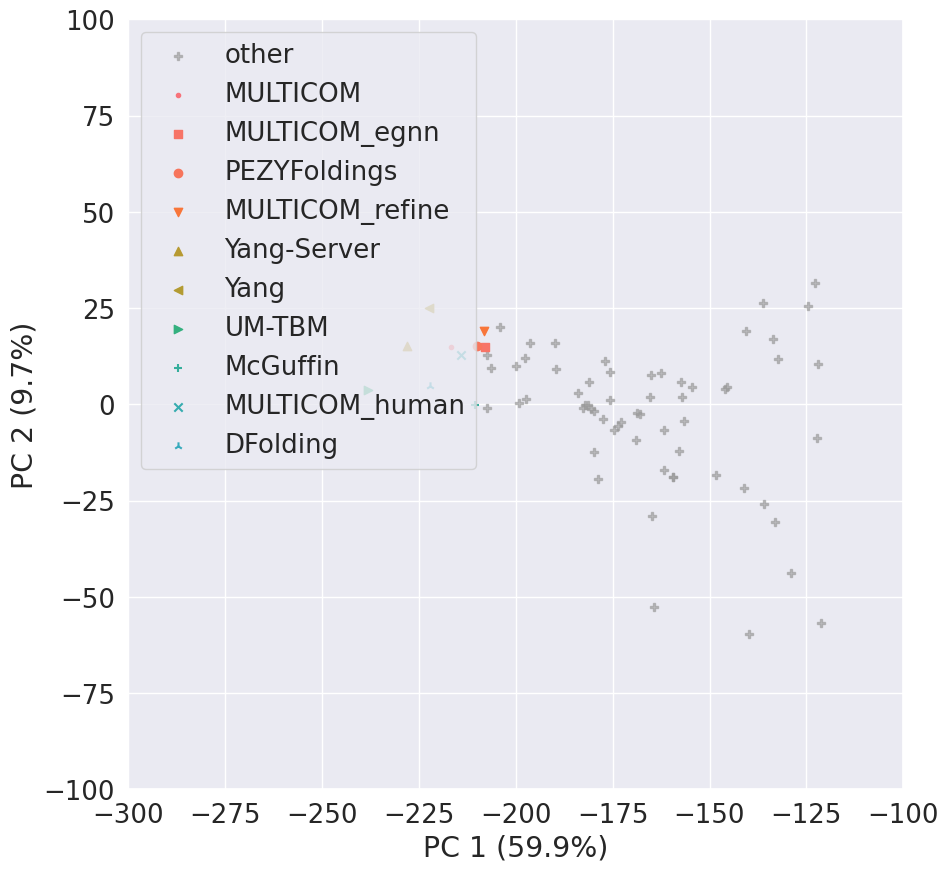

In [21]:
def pca_plot(target_df, top_groups):
    X = target_df.transpose()
    pca = PCA(n_components=2)
    pca.fit(X)
    
    xy_labels = {
        str(i): f"PC {i+1} ({var:.1f}%)"
        for i, var in enumerate(pca.explained_variance_ratio_ * 100)
    }
    
    X_pca = pca.transform(X)
    
    target_ids = range(len(target_df.columns))
    plt.figure(figsize=(10, 10))
    ax = plt.gca()
    ax.grid()
    other_c = None
    
    colours = sns.husl_palette(len(target_df.columns))
    markers = {0: "." , 1:"," , 2:"o" , 3:"v" , 4:"^" , 5:"<", 6:">", 7:'+', 8:'x', 9:'2', 10:'P', 11: 'd'}
    count = 0
    for i, c, label in zip(target_ids, colours, target_df.columns):
        if label not in top_groups:
            label = 'other'
            m = markers[10]
            count += 1
            c = (0.6, 0.6, 0.6, 0.6)

        else:
            m = markers[i - count]    
        plt.scatter(X_pca[i, 0], X_pca[i, 1], c=[c], marker=m, label=label)
    
    plt.xlim(-300, 500)
    plt.ylim(-300, 350)
    plt.xlim(-300, -100)
    plt.ylim(-100, 100)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.grid()
    plt.xlabel(xy_labels['0'])
    plt.ylabel(xy_labels['1'])
    plt.legend(by_label.values(), by_label.keys(), loc='upper left')
    
    plt.savefig("{}/PCA_plot_GDT_TS_top10_zoomed.png".format(figures_folder), dpi=300)
#     plt.savefig("{}/PCA_plot_GDT_TS_top10.png".format(figures_folder), dpi=300)
    plt.show()
    
    
def pca_feature_plot(target_df, feature):
    X = target_df.transpose()
    pca = PCA(n_components=2)
    pca.fit(X)
    
    xy_labels = {
        str(i): f"PC {i+1} ({var:.1f}%)"
        for i, var in enumerate(pca.explained_variance_ratio_ * 100)
    }
    
    X_pca = pca.transform(X)
    
    target_ids = range(len(target_df.columns))
    plt.figure(figsize=(10, 10))
    ax = plt.gca()
    ax.grid()
    other_c = None
    
    markers = {0: "." , 1:"x" , 2:"o" , 3:"v" , 4:"^" , 5:"<", 6:">", 7:'+', 8:',', 9:'2', 10:'P'}
    features = group_names_df[feature].unique()
    colours = sns.husl_palette(len(features))
    c_dict = {}
    m_dict = {}
    for i, c, v in zip(range(len(features)), colours, features):
        c_dict[v] = c
        m_dict[v] = markers[i]
        
    for i, group in zip(target_ids, target_df.columns):
        label = group_names_df.loc[(group_names_df['GR_name'] == group)][feature].values[0]
        plt.scatter(X_pca[i, 0], X_pca[i, 1], c=[c_dict[label]], marker=m_dict[label], label=label)
        
        if label == 'Other':
#         if group in ['af2-standard', 'af2-multimer', 'colabfold_human', 'ColabFold']:
            ax.annotate(group, (X_pca[i, 0], X_pca[i, 1]))
    
#     plt.xlim(-300, 500)
#     plt.ylim(-300, 350)
    plt.xlim(-300, -100)
    plt.ylim(-100, 100)
#     plt.xlim(-250, -150)
#     plt.ylim(-25, 25)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.grid()
    plt.xlabel(xy_labels['0'])
    plt.ylabel(xy_labels['1'])
    plt.legend(by_label.values(), by_label.keys(), title=feature, loc='upper left',)
    
    plt.savefig("{}/PCA_plot_GDT_TS_{}.png".format(figures_folder, feature), dpi=300)
    plt.show()

sorted_nb = df_1st.groupby(['GR_name'])['S_geom_casp15'].sum().sort_values(ascending=False)
top_groups = list(sorted_nb.index.values[0:10])
pca_plot(target_df2, top_groups)
# interesting_groups = [group_names[x] for x in ['131', '374', '162', '494', '229', '239', '037','035', '119', '439', '278', '248']]
# pca_plot(target_df3, interesting_groups)
# pca_feature_plot(target_df3, 'GR_input')

In [22]:
# Check how well groups model ordering compares to reordering with casp score
order_by = "S_geom_casp15"
df_tmp = df.sort_values(['Target', 'GR#', order_by], ascending=(True, True, False))
reordered_dfs = []
for target in df_tmp['Target'].unique():
    for group in df_tmp['GR#'].unique():
        x = df.loc[(df_tmp['Target'] == target) & (df_tmp['GR#'] == group)]
        if len(x) > 0:
            x['Model_GR_reranked'] = sorted(x['Model_GR_rank'].values)
            reordered_dfs.append(x)
df_tmp = pd.concat(reordered_dfs)

In [23]:
# Some groups only attemped a small number of targets and therefore distort the stats. Remove groups which didn't try at least 50% of the targets
ignore_groups = []

max_entries = len(df_tmp['Target'].unique()) * 5
for group in df_tmp['GR_name'].unique():
    entries = len(df.loc[(df_tmp['GR_name'] == group)])
    if entries < max_entries/2:
        ignore_groups.append(group)

rank_comp = {}
for group in df_tmp['GR_name'].unique():
    
    if group in ignore_groups:
        continue
    
    x = df_tmp.loc[(df_tmp['GR_name'] == group)]
    sp_res = stats.spearmanr(x['Model_GR_rank'], x['Model_GR_reranked'])
    if sp_res[0] is not np.nan:
        correct, incorrect = 0, 0
        for i, row in enumerate(x['Model_GR_rank']):
            if row == 1:
                if df_tmp.iloc[[i]]['Model_GR_reranked'].values[0] == 1:
                    correct += 1
                else:
                    incorrect += 1
                fraction_correct = (100.0 / (correct + incorrect)) * correct
        
        rank_comp[group] = [sp_res[0], sp_res[1], fraction_correct]

        
spearman_df = pd.DataFrame.from_dict(rank_comp, orient='index', columns=['spearman_cc', 'p-value', 'fraction_correct']).sort_values(['spearman_cc'], ascending=False)

for group in ['NBIS-af2-standard', 'NBIS-af2-multimer', 'colabfold_human', 'ColabFold']:
        df_tmp.loc[(df_tmp['GR_name'] == group),'GR_type'] = 'ColabFold/AF2'
    
for group in ['ESM-single-sequence', 'EMBER3D', 'UNRES']:
    df_tmp.loc[(df_tmp['GR_name'] == group),'GR_type'] = 'pLM methods'

# Add GR types, used for colouring the figure
gr_types = []
for gr in spearman_df.index.values:
    gr_types.append(df_tmp[df_tmp['GR_name'] == gr]['GR_type'].values[0])

spearman_df['GR_type'] = gr_types

In [24]:
def plot_cc_barchart(df, y, ylabel, palette='Set1'):
    f, ax = plt.subplots(figsize=(31, 6))
    sns.set(font_scale=1.4)
    sns.barplot(y=y, x=df.index, data=df, palette=palette, ci=None, dodge=False, linewidth=0.5, edgecolor="k", hue='GR_type', hue_order=['Server', 'Manual', 'ColabFold/AF2', 'pLM methods'])
    plt.legend(title='Group type', loc='upper right', labels=['Server', 'Manual', 'ColabFold/AF2', 'pLM methods'])
    plt.xticks(rotation=90)
    plt.ylabel(ylabel, fontsize=20)
    plt.xlabel('Group Name', fontsize=20)
    plt.savefig("{}/{}_gr_rank_vs_actual_rank.png".format(figures_folder, y), bbox_inches='tight')
    plt.show()
    plt.close()

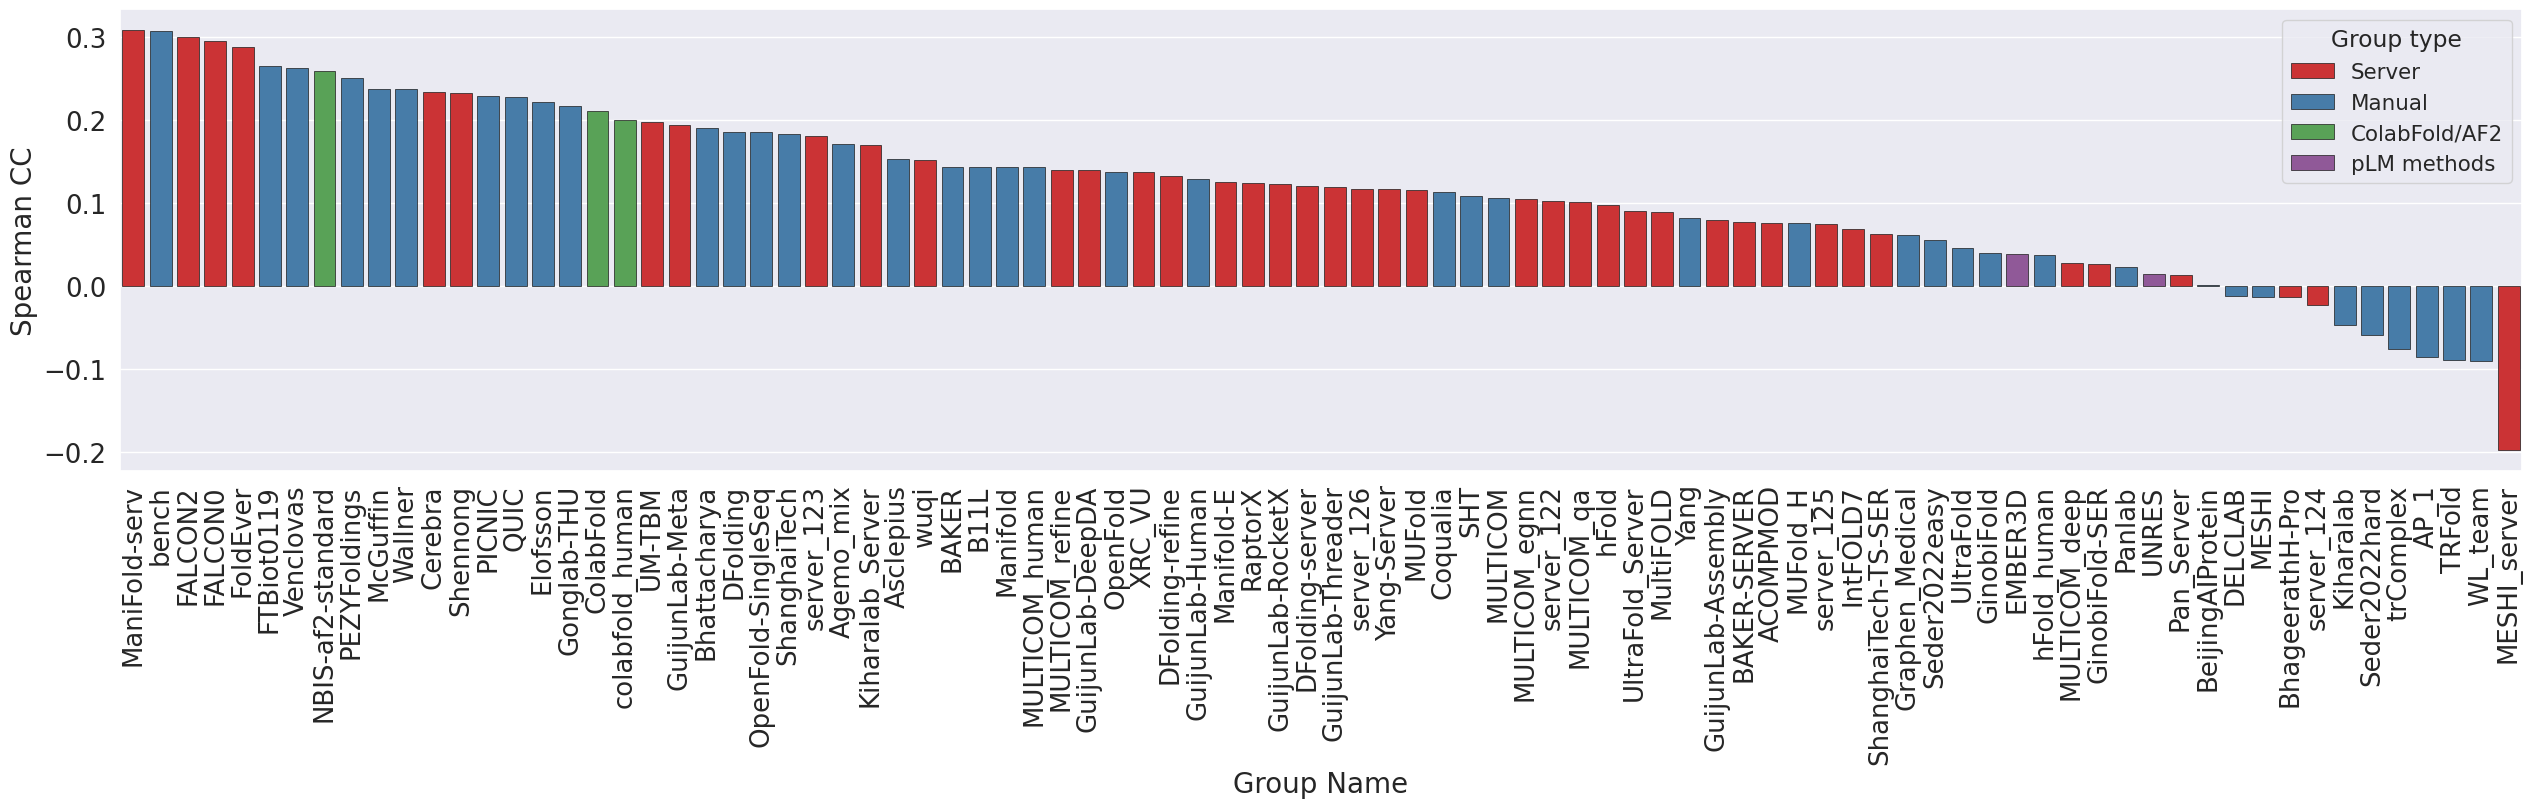

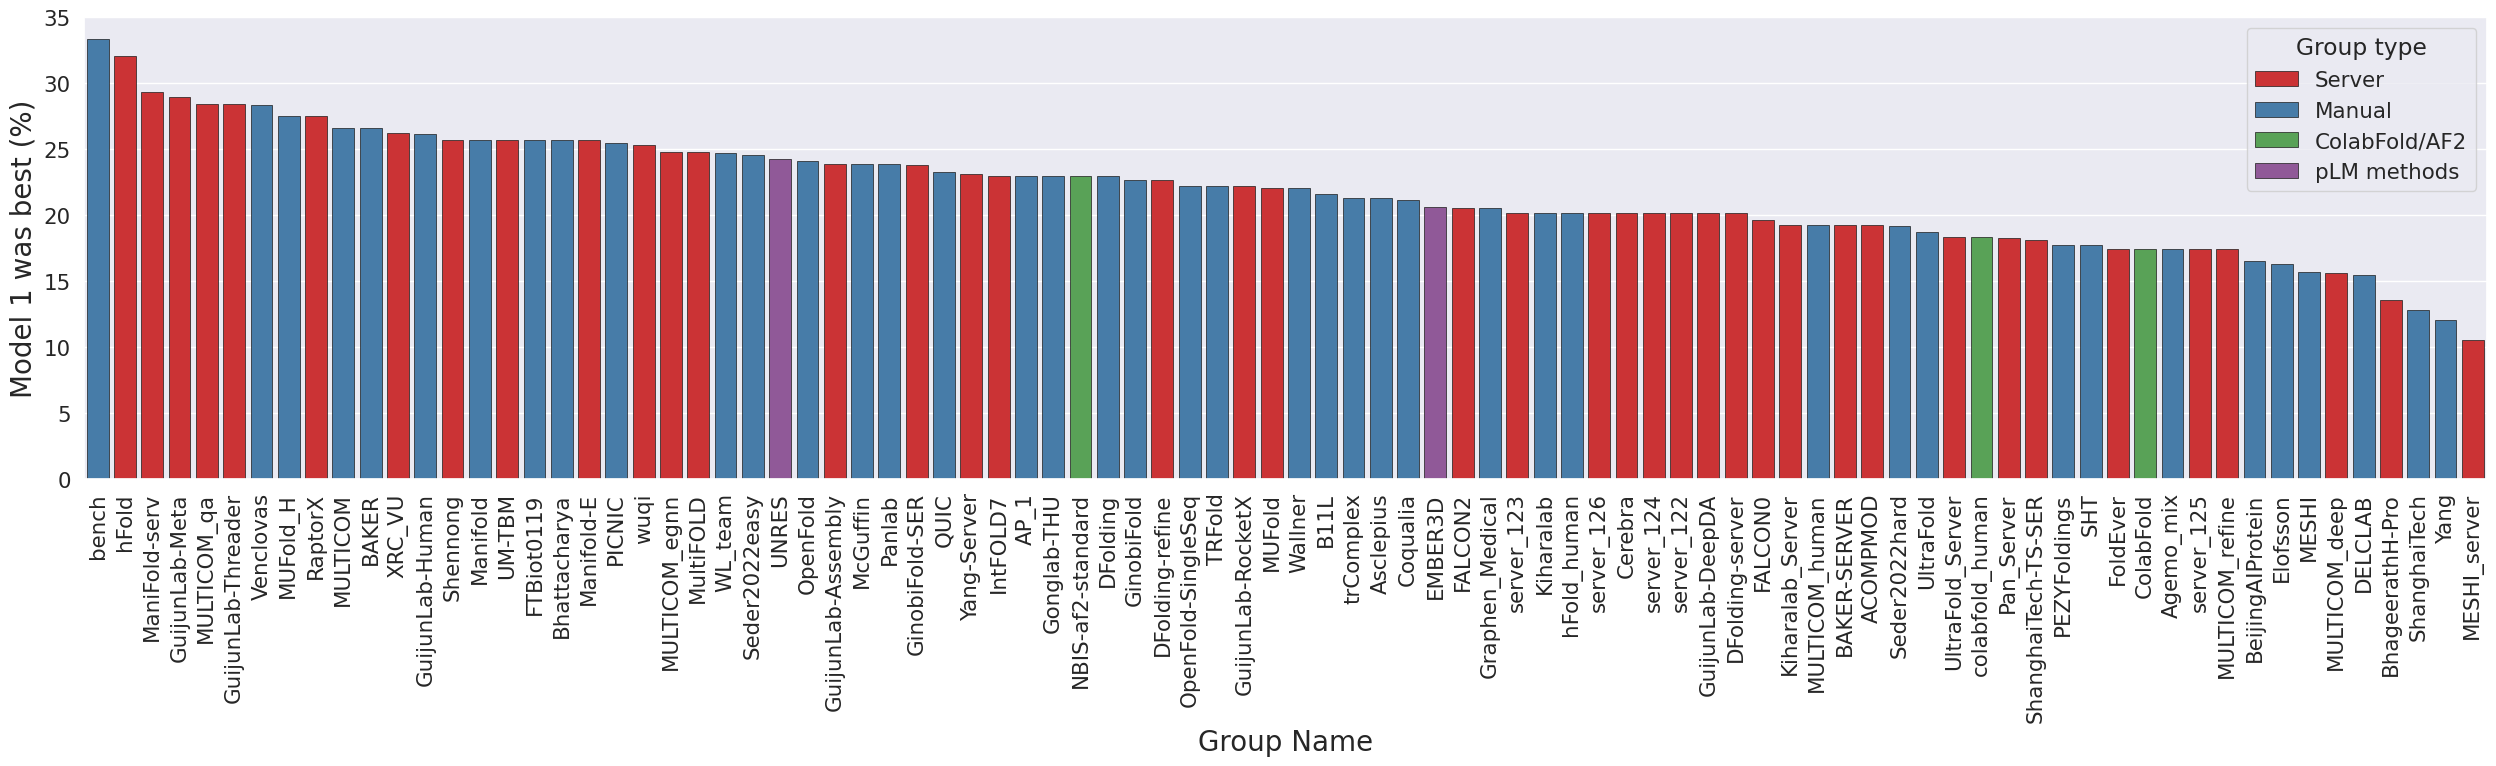

In [25]:
spearman_df = spearman_df.sort_values(['spearman_cc'], ascending=False)
plot_cc_barchart(spearman_df, 'spearman_cc', 'Spearman CC')
spearman_df = spearman_df.sort_values(['fraction_correct'], ascending=False)
plot_cc_barchart(spearman_df, 'fraction_correct', 'Model 1 was best (%)')

In [26]:
def scatter_best_vs_first(target_df, group):
    label = 'All'
    if group:
        target_df = target_df[target_df['GR_name'] == group]
        label = group
        
    target_df = target_df.dropna(subset = ['Model_GR_rank'])
    
    x_values = []
    y_values = []
    for target in target_df['Target'].unique():
        for group in target_df['GR_name'].unique():
            try:
                x = target_df[(target_df['Target'] == target) & (target_df['GR_name'] == group) & (target_df['Model_GR_reranked'] == 1)]['GDT_TS'].values[0]
                y = target_df[(target_df['Target'] == target) & (target_df['GR_name'] == group) & (target_df['Model_GR_rank'] == 1)]['GDT_TS'].values[0]
                
                if y > x:
                    print(target, group, x, y)
                x_values.append(x)
                y_values.append(y)
            except:
                pass
    
    f, ax = plt.subplots(1, 1, figsize=(15, 15))
    sns.scatterplot(ax=ax, y=y_values, x=x_values)
    plt.plot([0,100], [0, 100], ls="--", color='r')
    plt.xlabel('GDT_TS of best model')
    plt.ylabel('GDT_TS of rank 1 model')
    plt.title(label)
    plt.savefig("{}/best_vs_1st_scatter_{}.png".format(figures_folder, label), bbox_inches='tight')
    plt.show()   

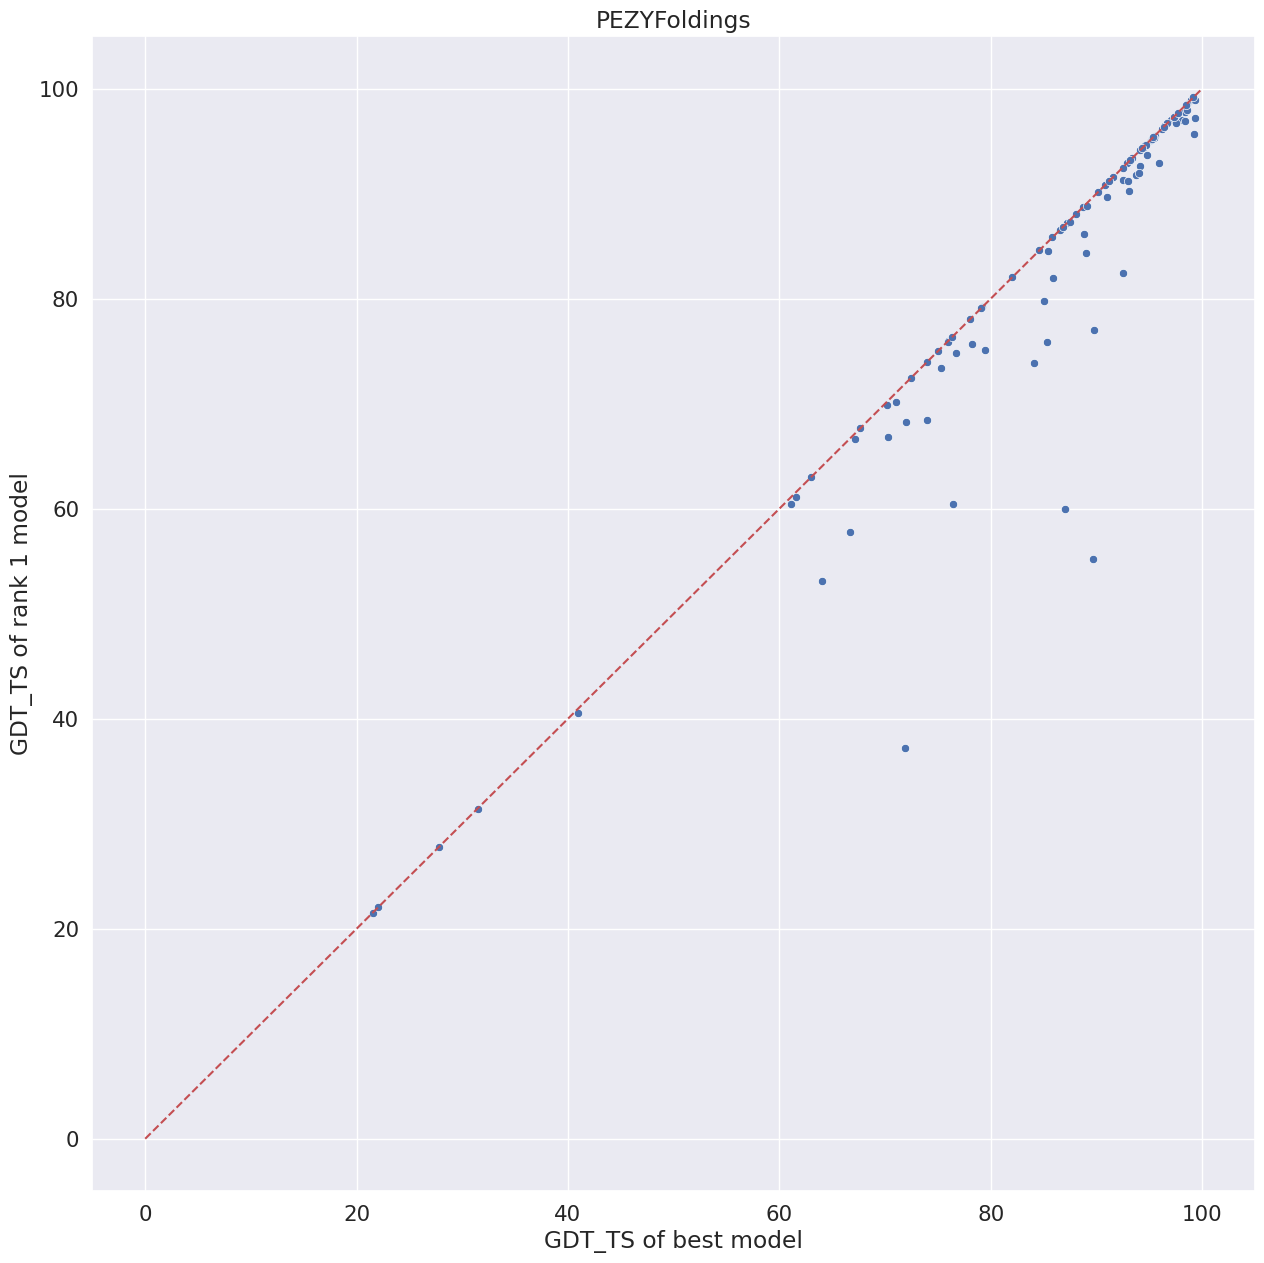

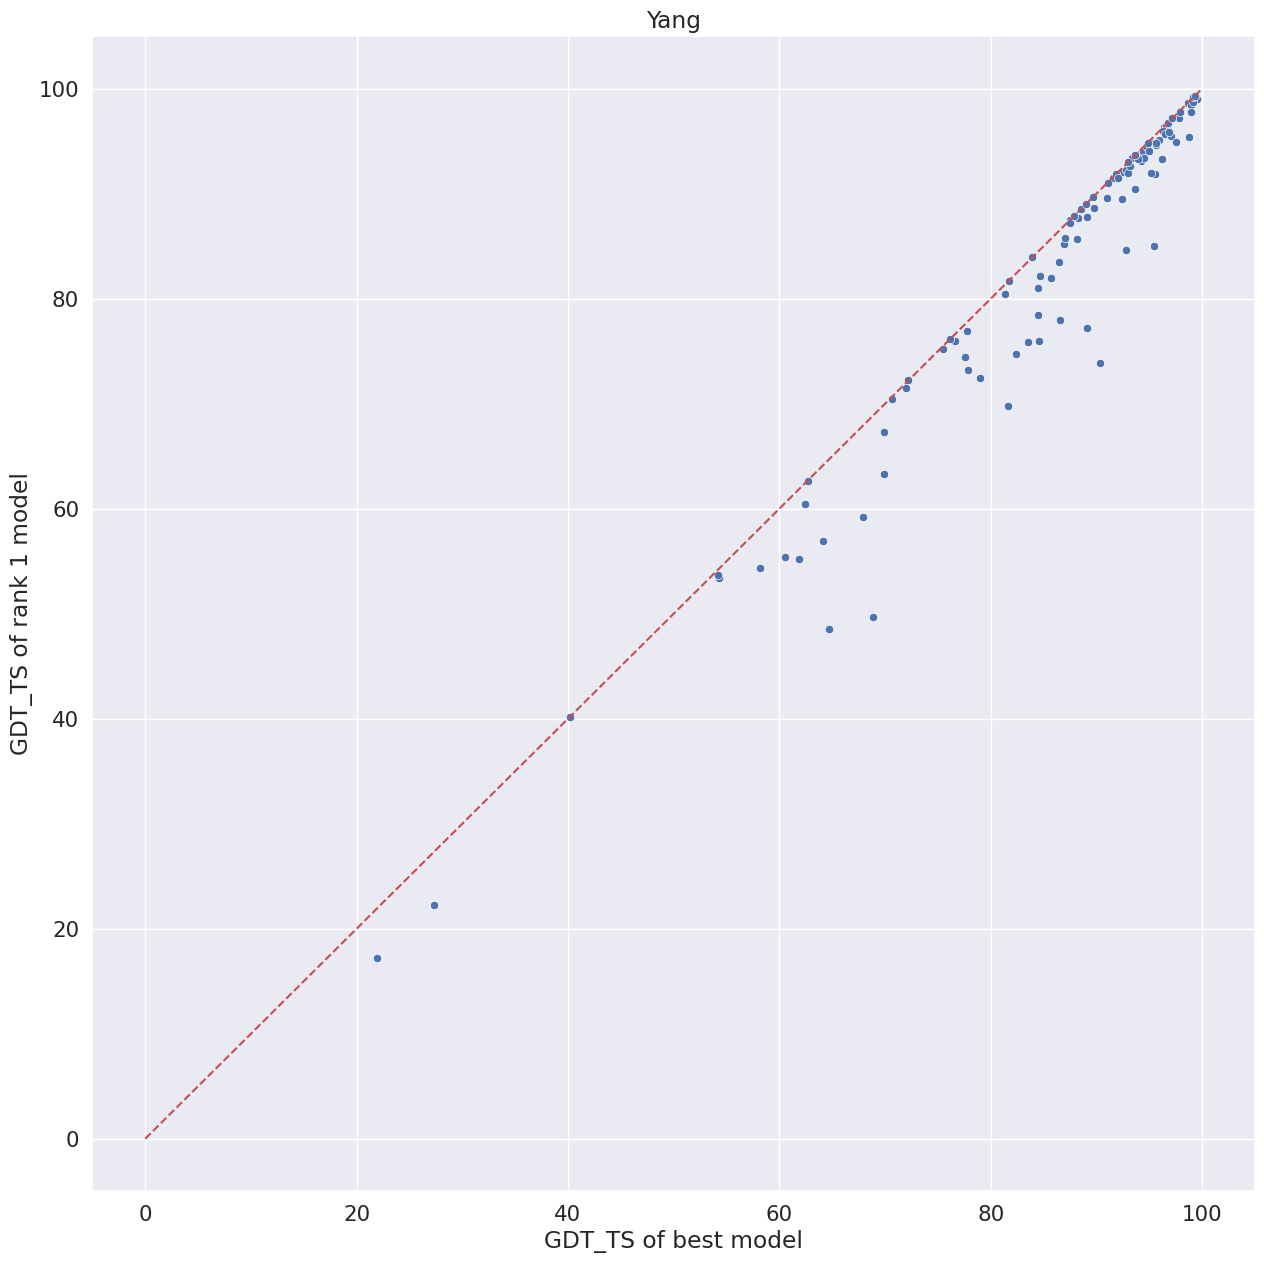

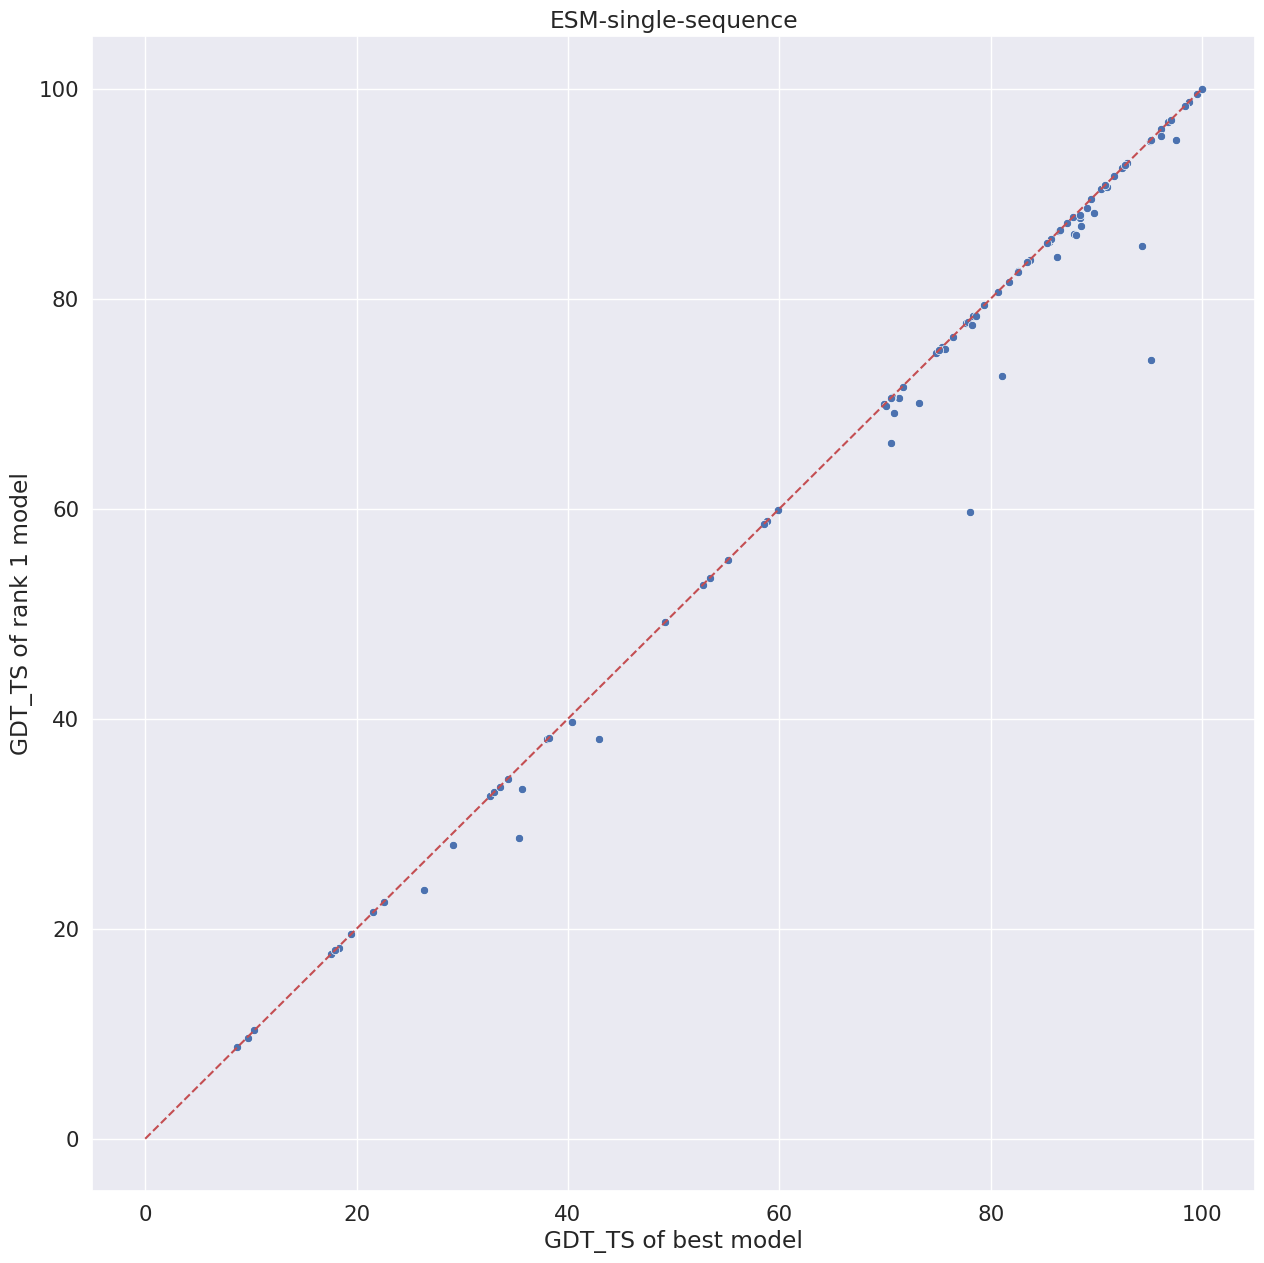

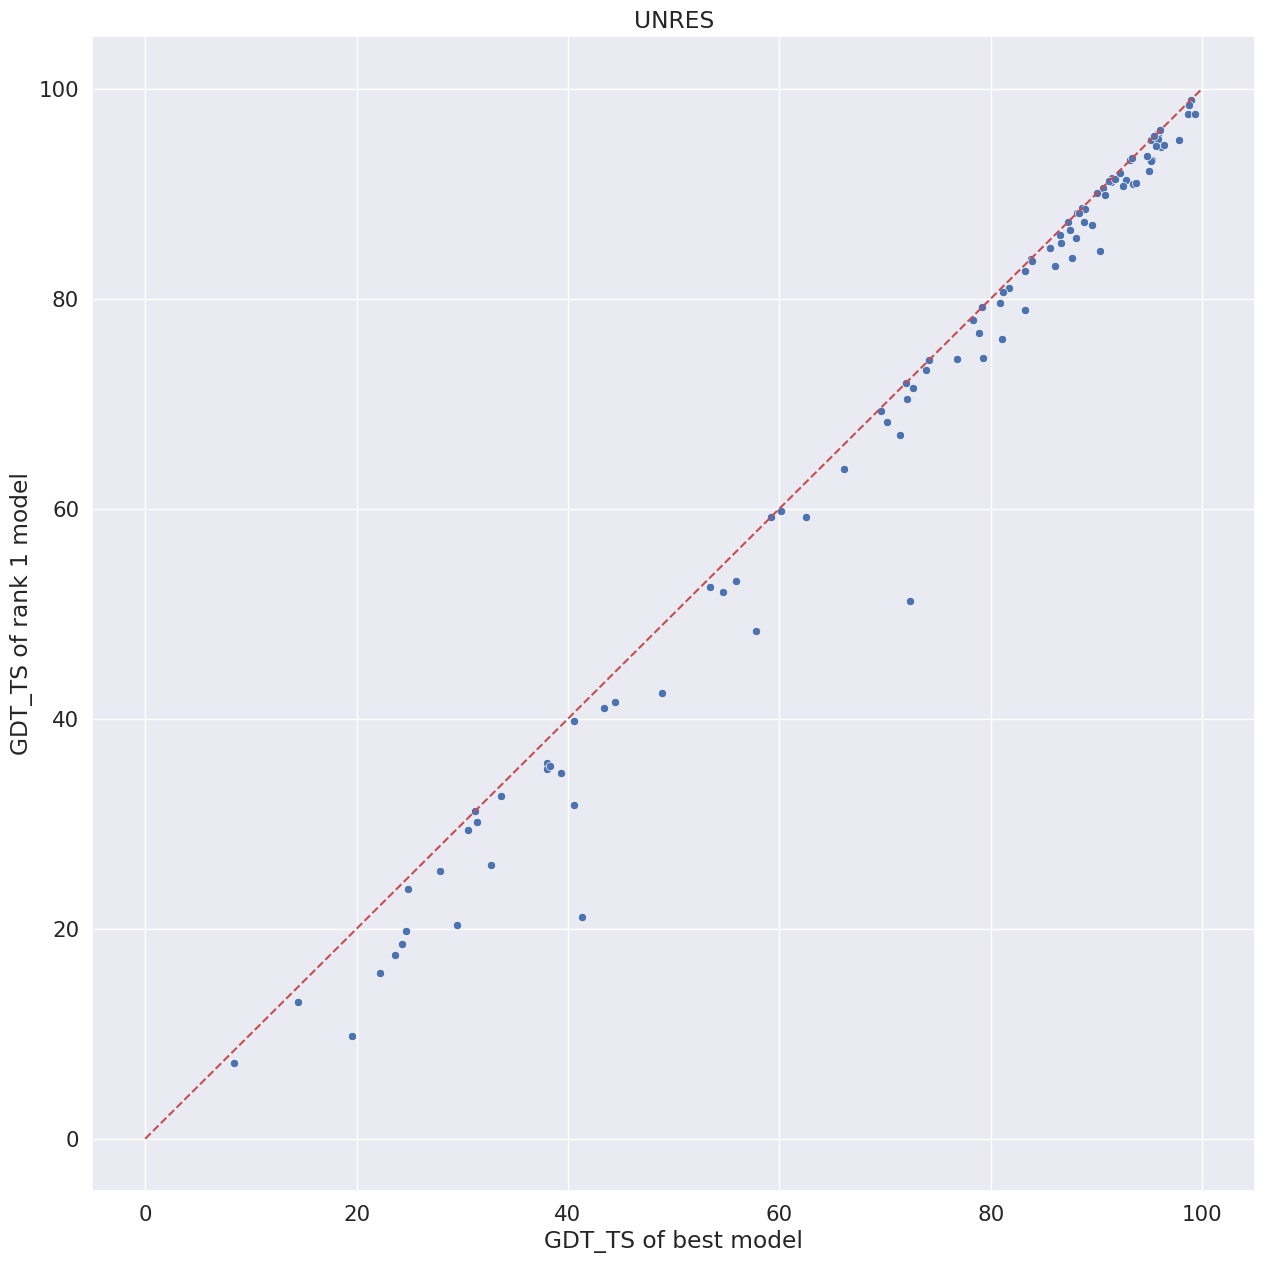

In [27]:
groups = ['PEZYFoldings', 'Yang', 'ESM-single-sequence', 'UNRES']

for group in groups:
    scatter_best_vs_first(df_tmp, group=group) 

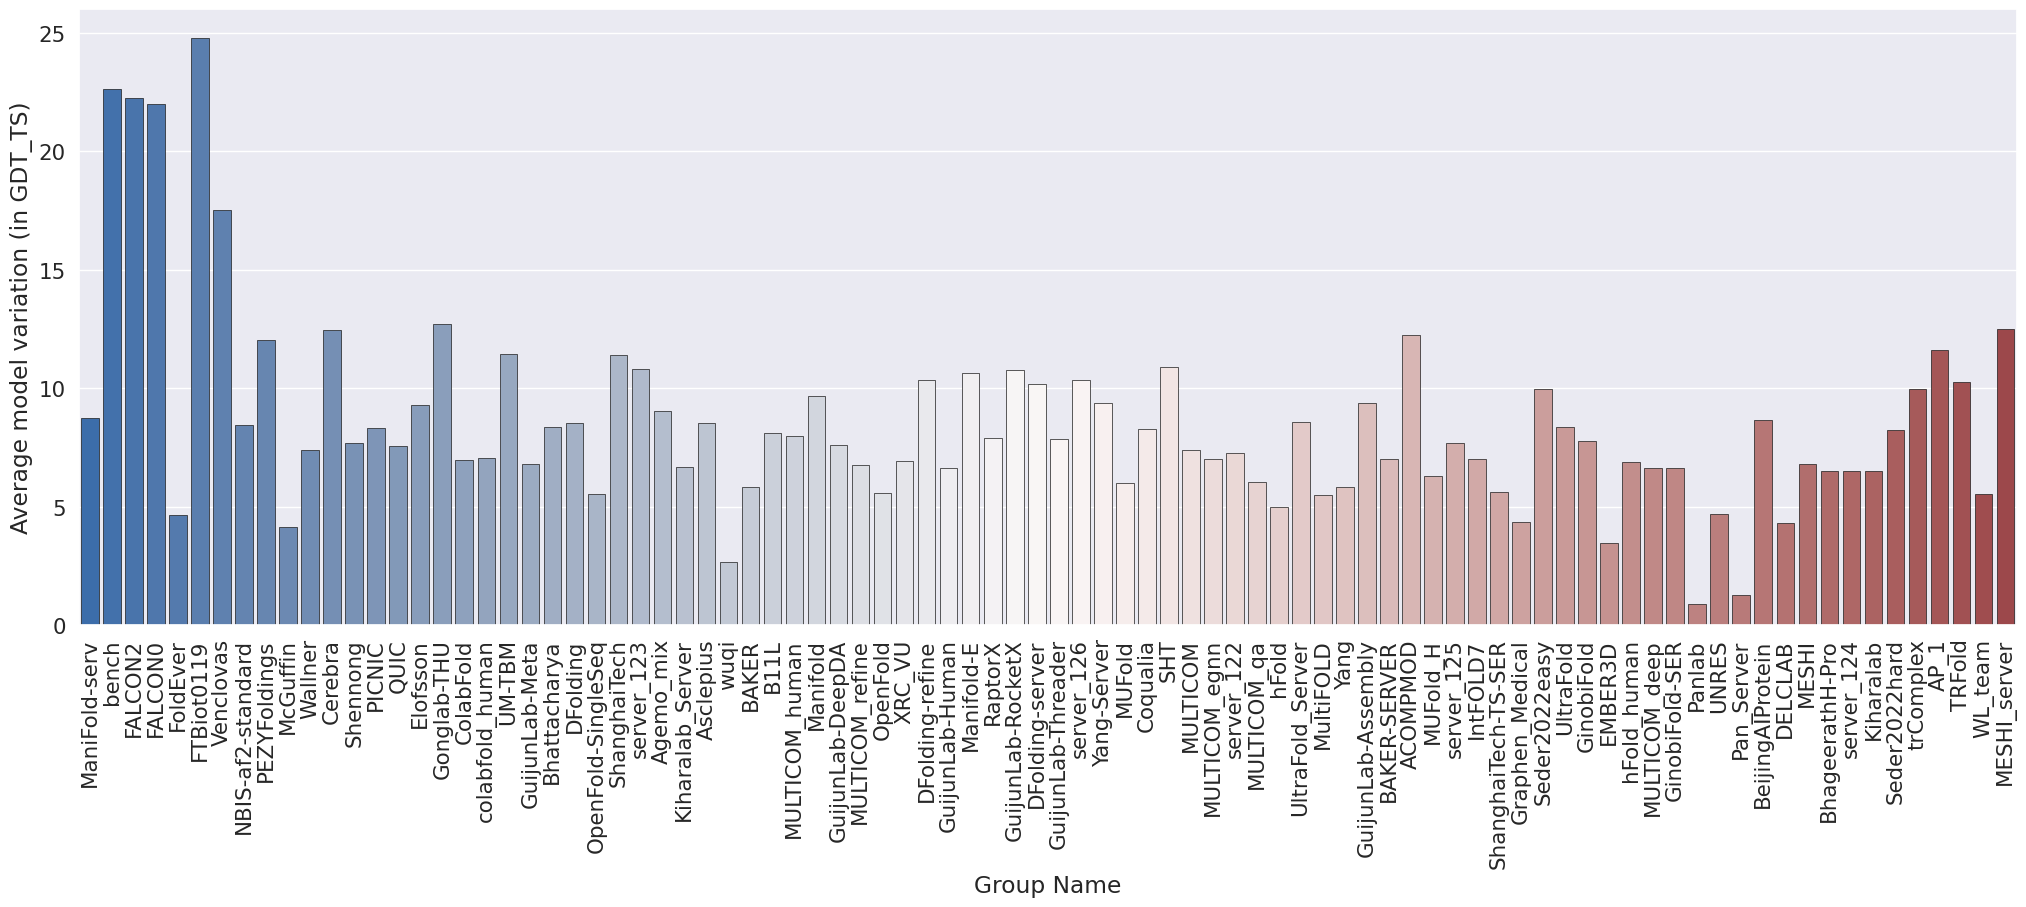

In [28]:
def bar_mean_difference_per_group(target_df):
#     sorted_nb = df_1st.groupby(['GR_name'])['S_geom_casp15'].sum().sort_values(ascending=False)
    sorted_nb = spearman_df.sort_values(['spearman_cc'], ascending=False)
    groups = []
    mean_diffs = []
    for group in target_df['GR_name'].unique():
        diffs = []
        for target in target_df[target_df['GR_name'] == group]['Target'].unique():
            target_gdts = target_df[(target_df['GR_name'] == group) & (target_df['Target'] == target)]['GDT_TS'].values
            if len(target_gdts) > 0:
                diffs.append(max(target_gdts) - min(target_gdts))
        if len(diffs) > 0:
            groups.append(group)
            mean_diffs.append(sum(diffs) / len(diffs))
    
    f, ax = plt.subplots(figsize=(25, 8))
    sns.set(font_scale=1)
    results_dict = {'GR_name': groups, 'mean_diffs': mean_diffs}
    sns.barplot(y='mean_diffs', x='GR_name', data=pd.DataFrame(results_dict), palette='vlag', ci=None, dodge=False, linewidth=0.5, edgecolor="k", order=(sorted_nb.index))
    ax.set(ylabel="Average model variation (in GDT_TS)", xlabel="Group Name")
    plt.xticks(rotation=90)
    plt.savefig("{}/variation_in_models_per_group_spearman_order.png".format(figures_folder), bbox_inches='tight')
    plt.show()
    plt.close()
    

bar_mean_difference_per_group(df)

In [29]:
def replot_neff_vs_gdt(target_df, top_groups=False):
    sns.set_theme(style="white")
    
    targets = []
    ss = []
    sizes = []
    median_gdt = []
    neffs = []
    for target in df_1st['Target'].unique():
        targets.append(target)
        ss.append(info_df.loc[info_df['Target'] == target]['secondary_structure'].values[0])
        sizes.append(info_df.loc[info_df['Target'] == target]['size'].values[0])
        
        if top_groups:
            scores = []
            for group in top_groups:
                try:
                    scores.append(target_df[(target_df['Target'] == target) & (target_df.GR_name == group)]['GDT_TS'].values[0])
                except:
                    pass
            median_gdt.append(statistics.median(scores))
        else:   
            median_gdt.append(target_df[target_df['Target'] == target]['GDT_TS'].median())
        
        try:
            neffs.append(casp_neff_df[casp_neff_df['Target'] == target]['Neff/len'].values[0])
        except:
            neffs.append(target_df[target_df['Target'] == target]['Target_Neff'].values[0])
            
    df_tmp = pd.DataFrame({'Target': targets, 'secondary_structure': ss,  'size': sizes, 'median_GDT_TS': median_gdt, 'Neff/len': neffs})
    
    sns.set(font_scale=1.5)
    g = sns.relplot(x="Neff/len", y="median_GDT_TS", hue="secondary_structure", hue_order=['all_alpha', 'mostly_alpha', 'mixed', 'mostly_beta', 'all_beta'], size="size",
                sizes=(40, 400), alpha=.5, palette="muted",
                height=6, data=df_tmp)
    
    if top_groups:
        ax = g.axes[0,0]
        for idx,row in df_tmp.iterrows():
            x = row['Neff/len']
            y = row['median_GDT_TS']
            text = row['Target']
            if text in ['T1131-D1', 'T1122-D1', 'T1130-D1', 'T1125-D5', 'T1125-D6']:
                ax.text(x+.5,y-.5, text, horizontalalignment='left', fontsize=20)
    
    
    g.fig.set_figwidth(30)
    g.fig.set_figheight(20)
    
    plt.ylabel(r'Median GDT_TS', fontsize=24)
    plt.xlabel('Neff/len', fontsize=24)
    g.tight_layout
    
    if not top_groups:
#         plt.title('General scatter plot of GDT_TS vs Target Neff/Target length,\n coloured by secondary structure', fontsize=28)
        sns.move_legend(g, "lower right", bbox_to_anchor=(0.8, 0.175))
        g.savefig('{}/gdt_vs_neff_all.png'.format(figures_folder))
    else:
#         plt.title('General scatter plot of GDT_TS vs Target Neff/Target length,\n coloured by secondary structure, top 10', fontsize=28)
        sns.move_legend(g, "lower right", bbox_to_anchor=(0.8, 0.175))
        g.savefig('{}/gdt_vs_neff_all_top10.png'.format(figures_folder))

    return

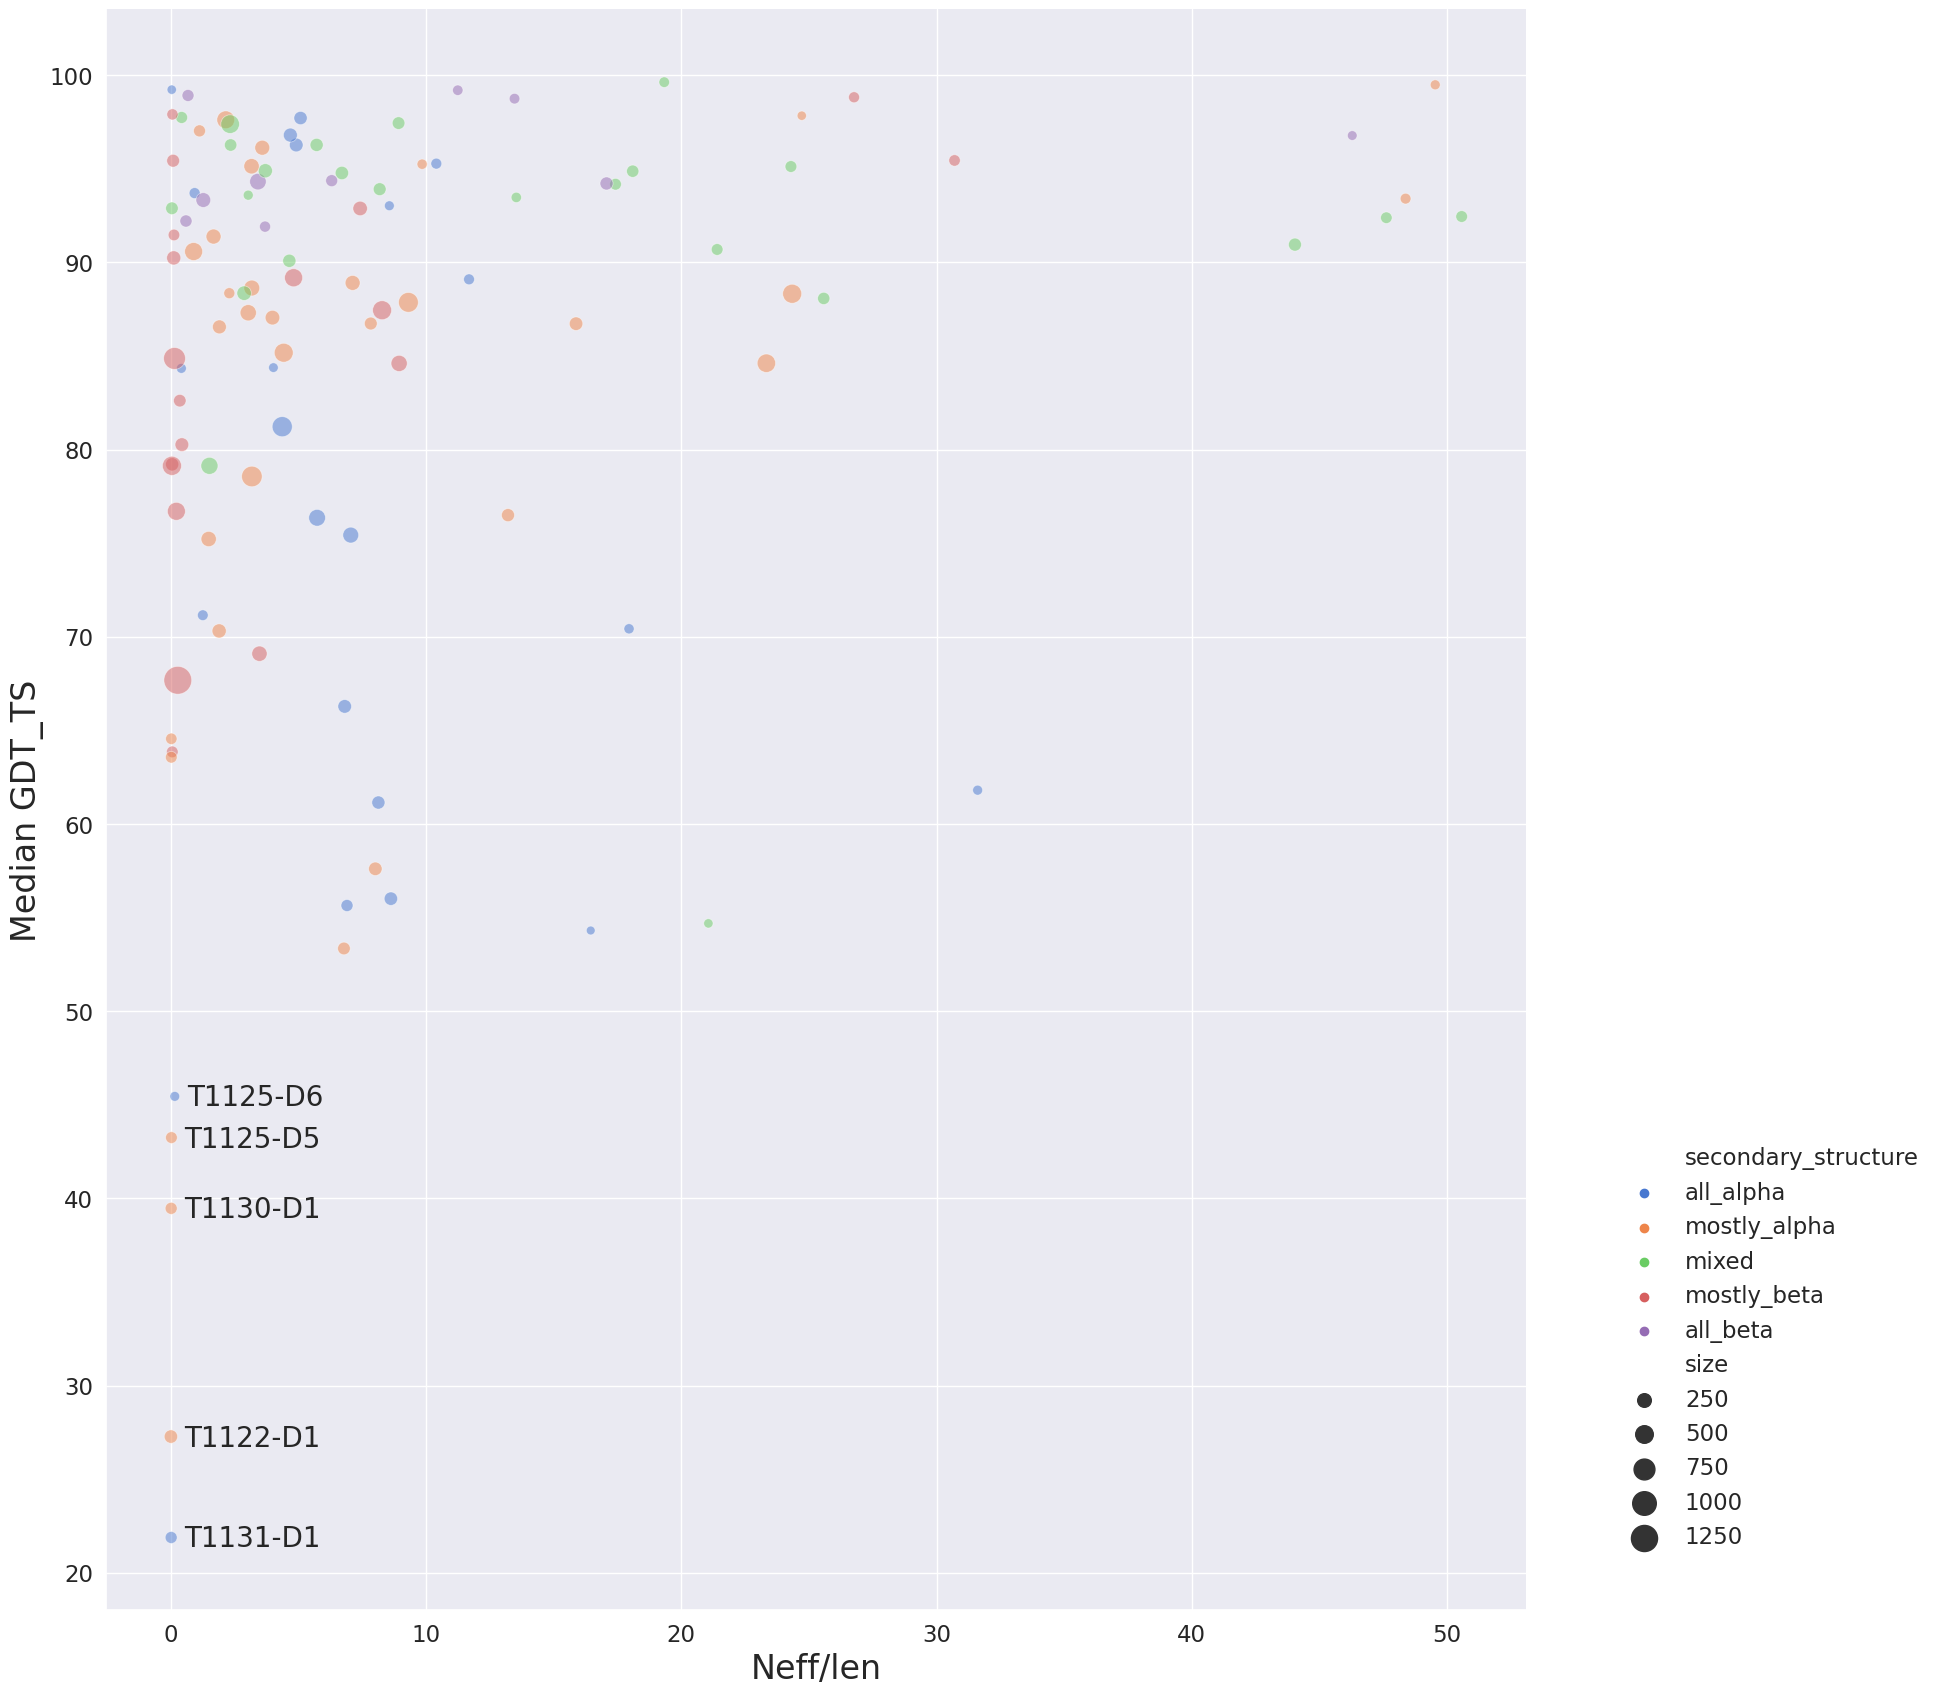

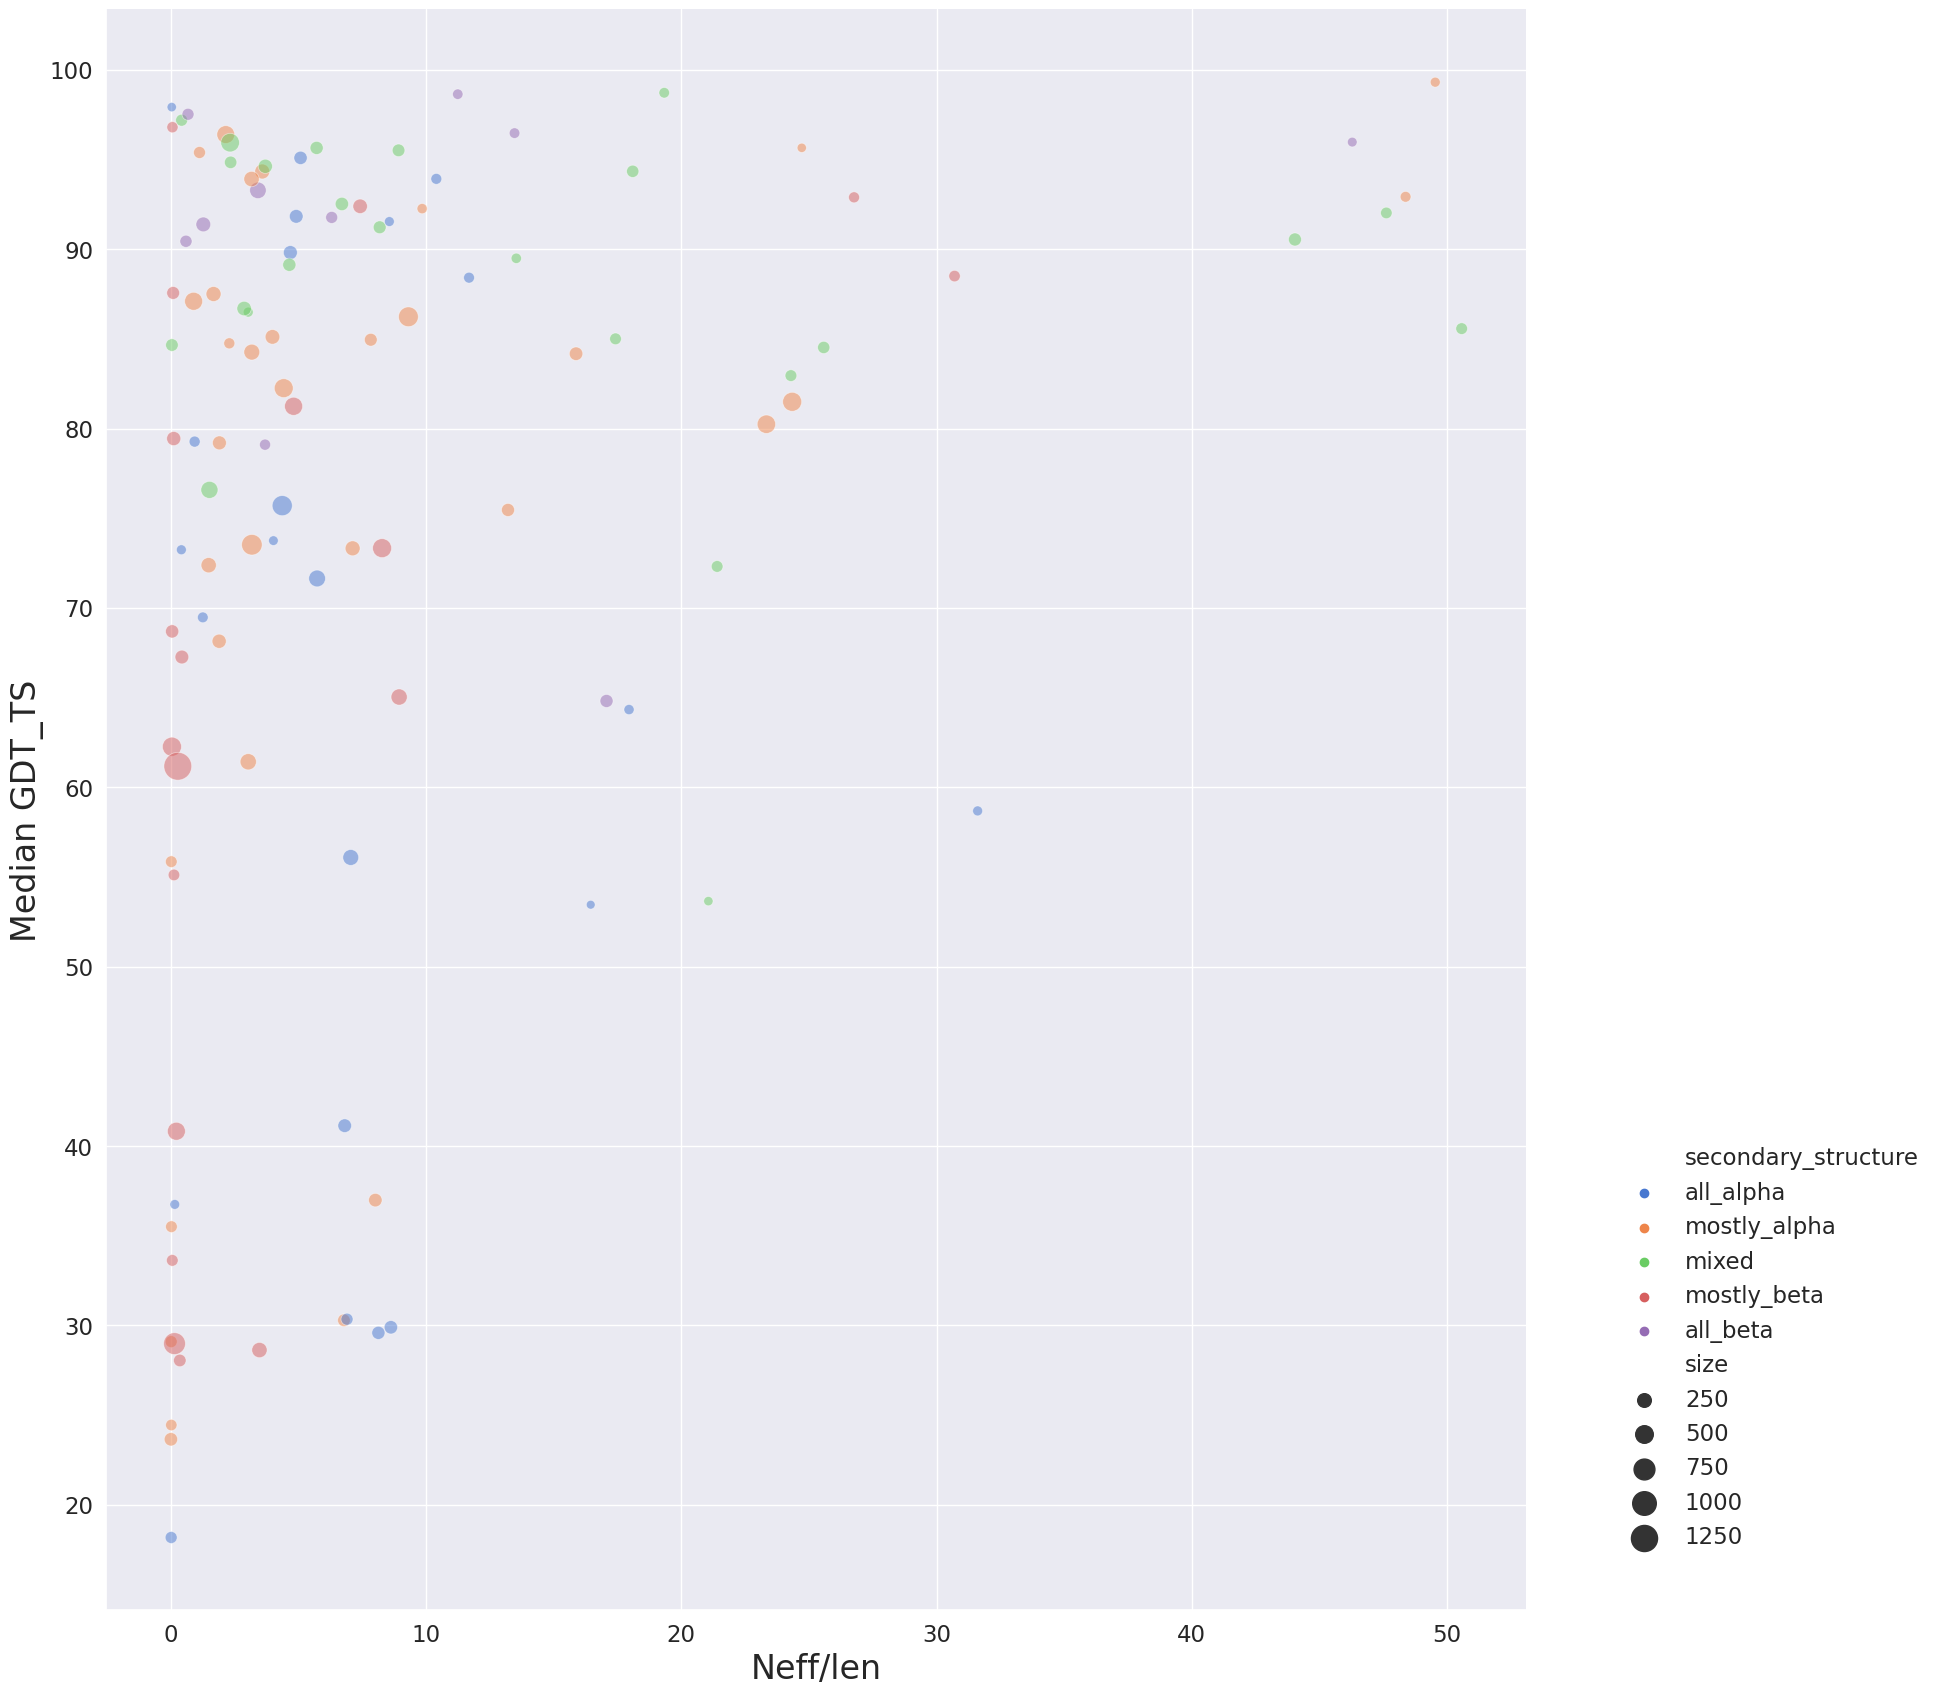

In [30]:
replot_neff_vs_gdt(df, top_groups=top_groups)

replot_neff_vs_gdt(df, top_groups=None)

homo-oligomer
33
hetero-oligomer
29
monomer
47


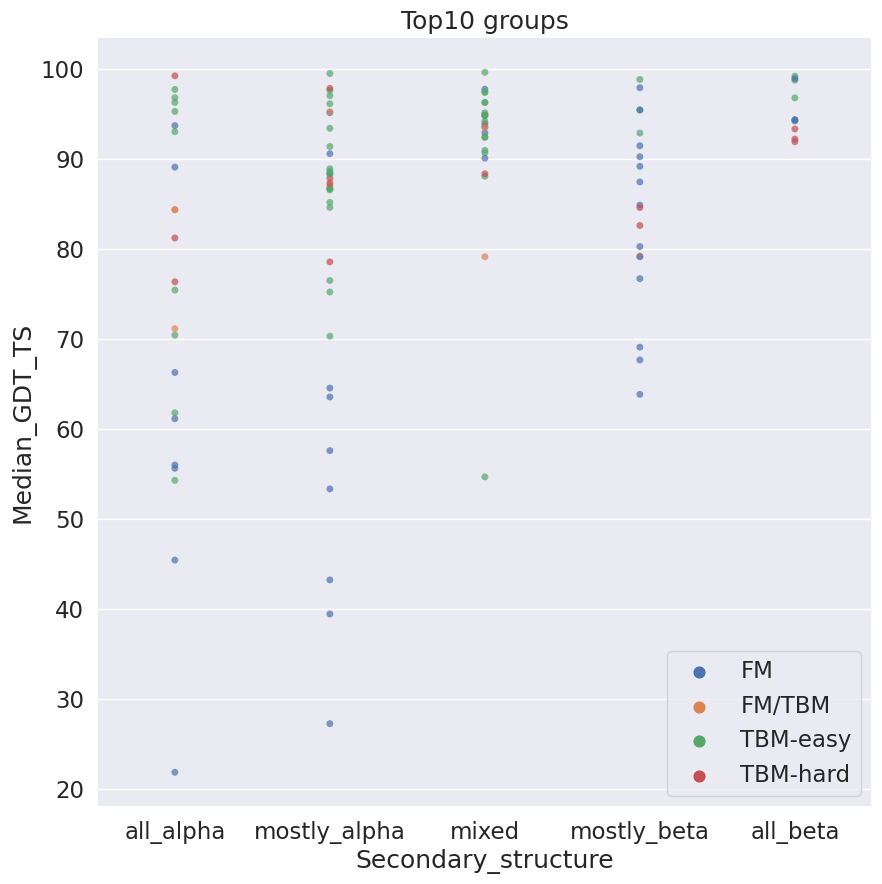

In [31]:
def feature_vs_gdt(target_df, feature, top_groups):
    targets = []
    size = []
    secondary_structure = []
    source = []
    oligomeric_state = []
    median_scores = []
    classification = []
    
    for target in target_df['Target'].unique():
        targets.append(target)
        size.append(info_df[info_df['Target'] == target]['size'].values[0])
        secondary_structure.append(info_df[info_df['Target'] == target]['secondary_structure'].values[0])
        source.append(info_df[info_df['Target'] == target]['source'].values[0])
        oligomeric_state.append(info_df[info_df['Target'] == target]['oligomeric_state'].values[0])
        classification.append(target_df[target_df['Target'] == target]['Target_classification'].values[0])
        if top_groups:
            scores = []
            for group in top_groups:
                try:
                    scores.append(target_df[(target_df['Target'] == target) & (target_df.GR_name == group)]['GDT_TS'].values[0])
                except:
                    pass
            median_scores.append(statistics.median(scores))
            title_label = 'Top10'
        else:   
            median_scores.append(target_df[target_df['Target'] == target]['GDT_TS'].median())
            title_label = 'All'
            
    for i in set(oligomeric_state):
        print(i)
        print(oligomeric_state.count(i))
    
    score_dict = {'Target': targets, 'Size': size, 'Source': source, 'Secondary_structure': secondary_structure, 'Oligomeric_state': oligomeric_state, 'Median_GDT_TS': median_scores, 'Classification': classification}
    plt.figure(figsize=(10, 10))
    sns.stripplot(data=pd.DataFrame(score_dict), x=feature,  y='Median_GDT_TS', hue='Classification', alpha=0.7, order=['all_alpha', 'mostly_alpha', 'mixed', 'mostly_beta', 'all_beta'], jitter=False)
    plt.legend(loc='lower right')
    plt.title(f'{title_label} groups')
    plt.savefig("{}/{}_vs_gdt_scatter_{}_groups.png".format(figures_folder, feature.lower(), title_label.lower()))
    plt.show()

   
sorted_nb = df_1st.groupby(['GR_name'])['S_geom_casp15'].sum().sort_values(ascending=False)
top_groups = list(sorted_nb.index.values[0:10])
feature_vs_gdt(df, feature='Secondary_structure', top_groups=top_groups)

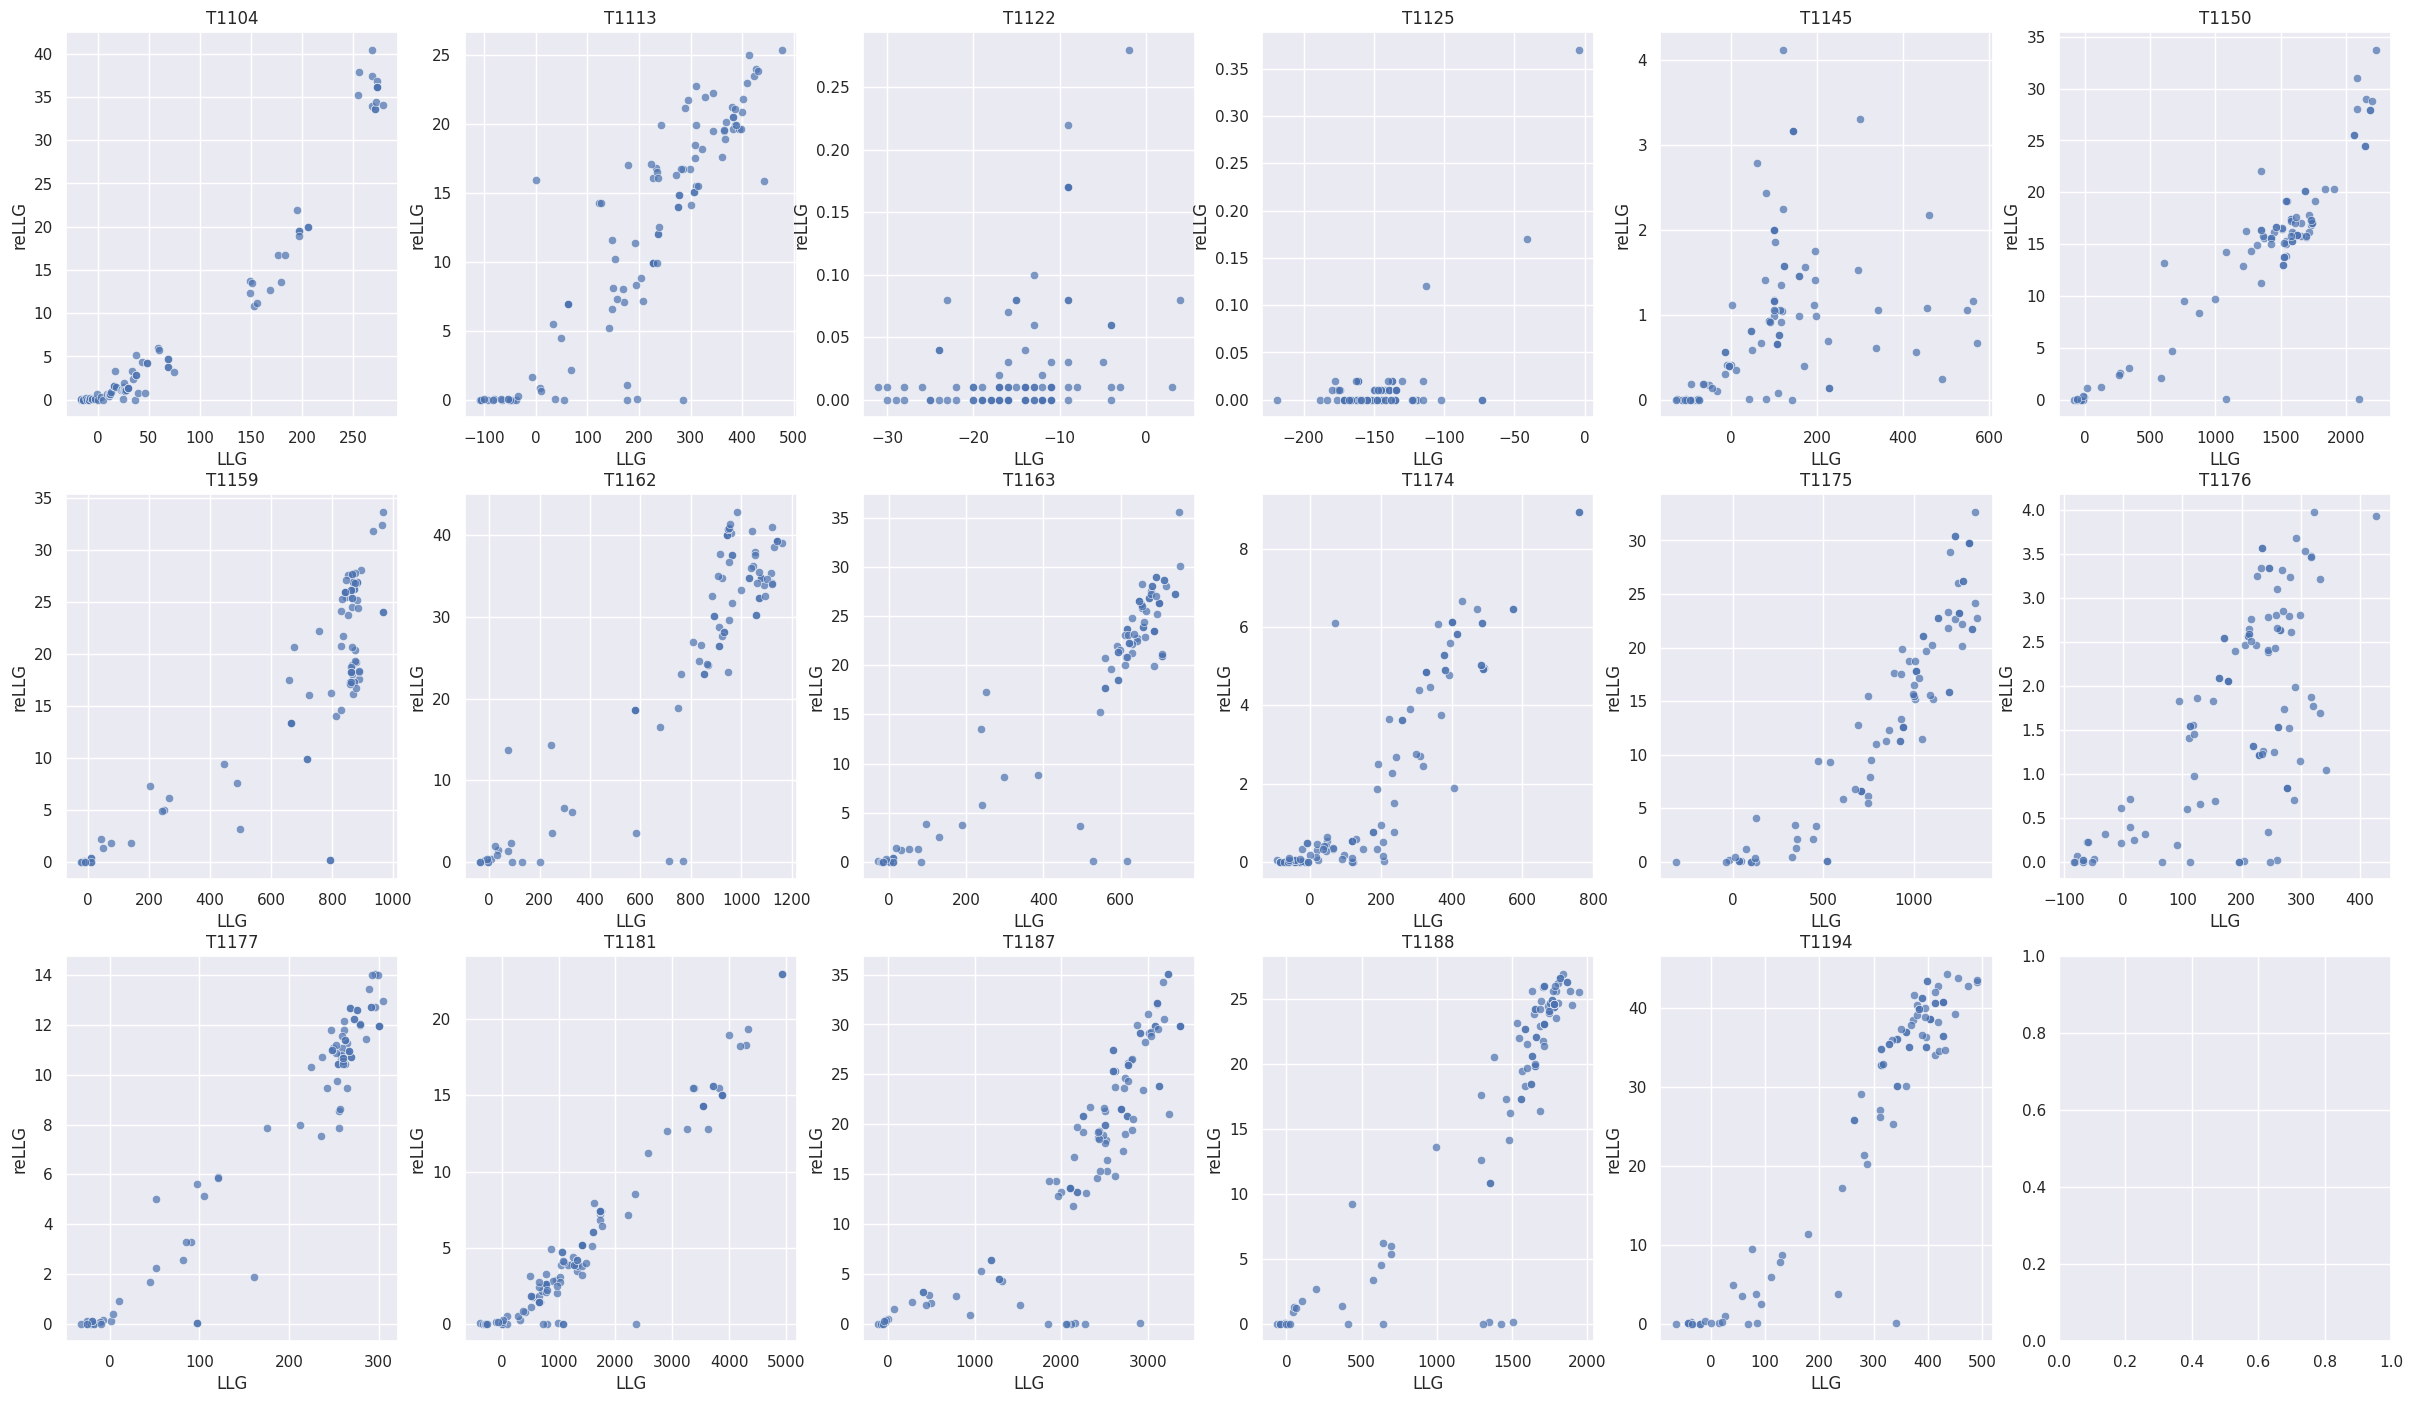

In [32]:
sns.set(font_scale=1)
fig, axes = plt.subplots(3, 6, figsize=(30, 17))
axes_dict = {'T1104': (0, 0), 'T1113': (0, 1), 'T1122': (0, 2), 'T1125': (0, 3), 'T1145': (0, 4), 'T1150': (0, 5), 
             'T1159': (1, 0), 'T1162': (1, 1), 'T1163': (1, 2), 'T1174': (1, 3), 'T1175': (1, 4), 'T1176': (1, 5), 
             'T1177': (2, 0), 'T1181': (2, 1), 'T1187': (2, 2), 'T1188': (2, 3), 'T1194': (2, 4)}

for target in list(llg_df.columns)[1:]:
    targets = []
    groups = []
    llgs = []
    rellgs = []
    for group in list(llg_df['Group'].values):
        for i in rellg_df['Target'].unique():
            if target in i:
                try:
                    rellgs.append(rellg_df[(rellg_df['Target'] == i) & (rellg_df['GROUP_NAME'] == group)]['reLLG_lddt'].values[0])
                    llgs.append(llg_df[llg_df['Group'] == group][target].values[0])
                    targets.append(target)
                    groups.append(group)
                except:
                    pass

    score_dict = {'Target': targets, 'Group': groups, 'LLG': llgs, 'reLLG': rellgs}
    x, y = axes_dict[target]
    sns.scatterplot(ax=axes[x, y], data=pd.DataFrame(score_dict), x='LLG',  y='reLLG', alpha=0.7)
    axes[x, y].set_title(target)
    
plt.savefig("{}/llg_vs_rellg_scatter.png".format(figures_folder), bbox_inches='tight')
plt.show()



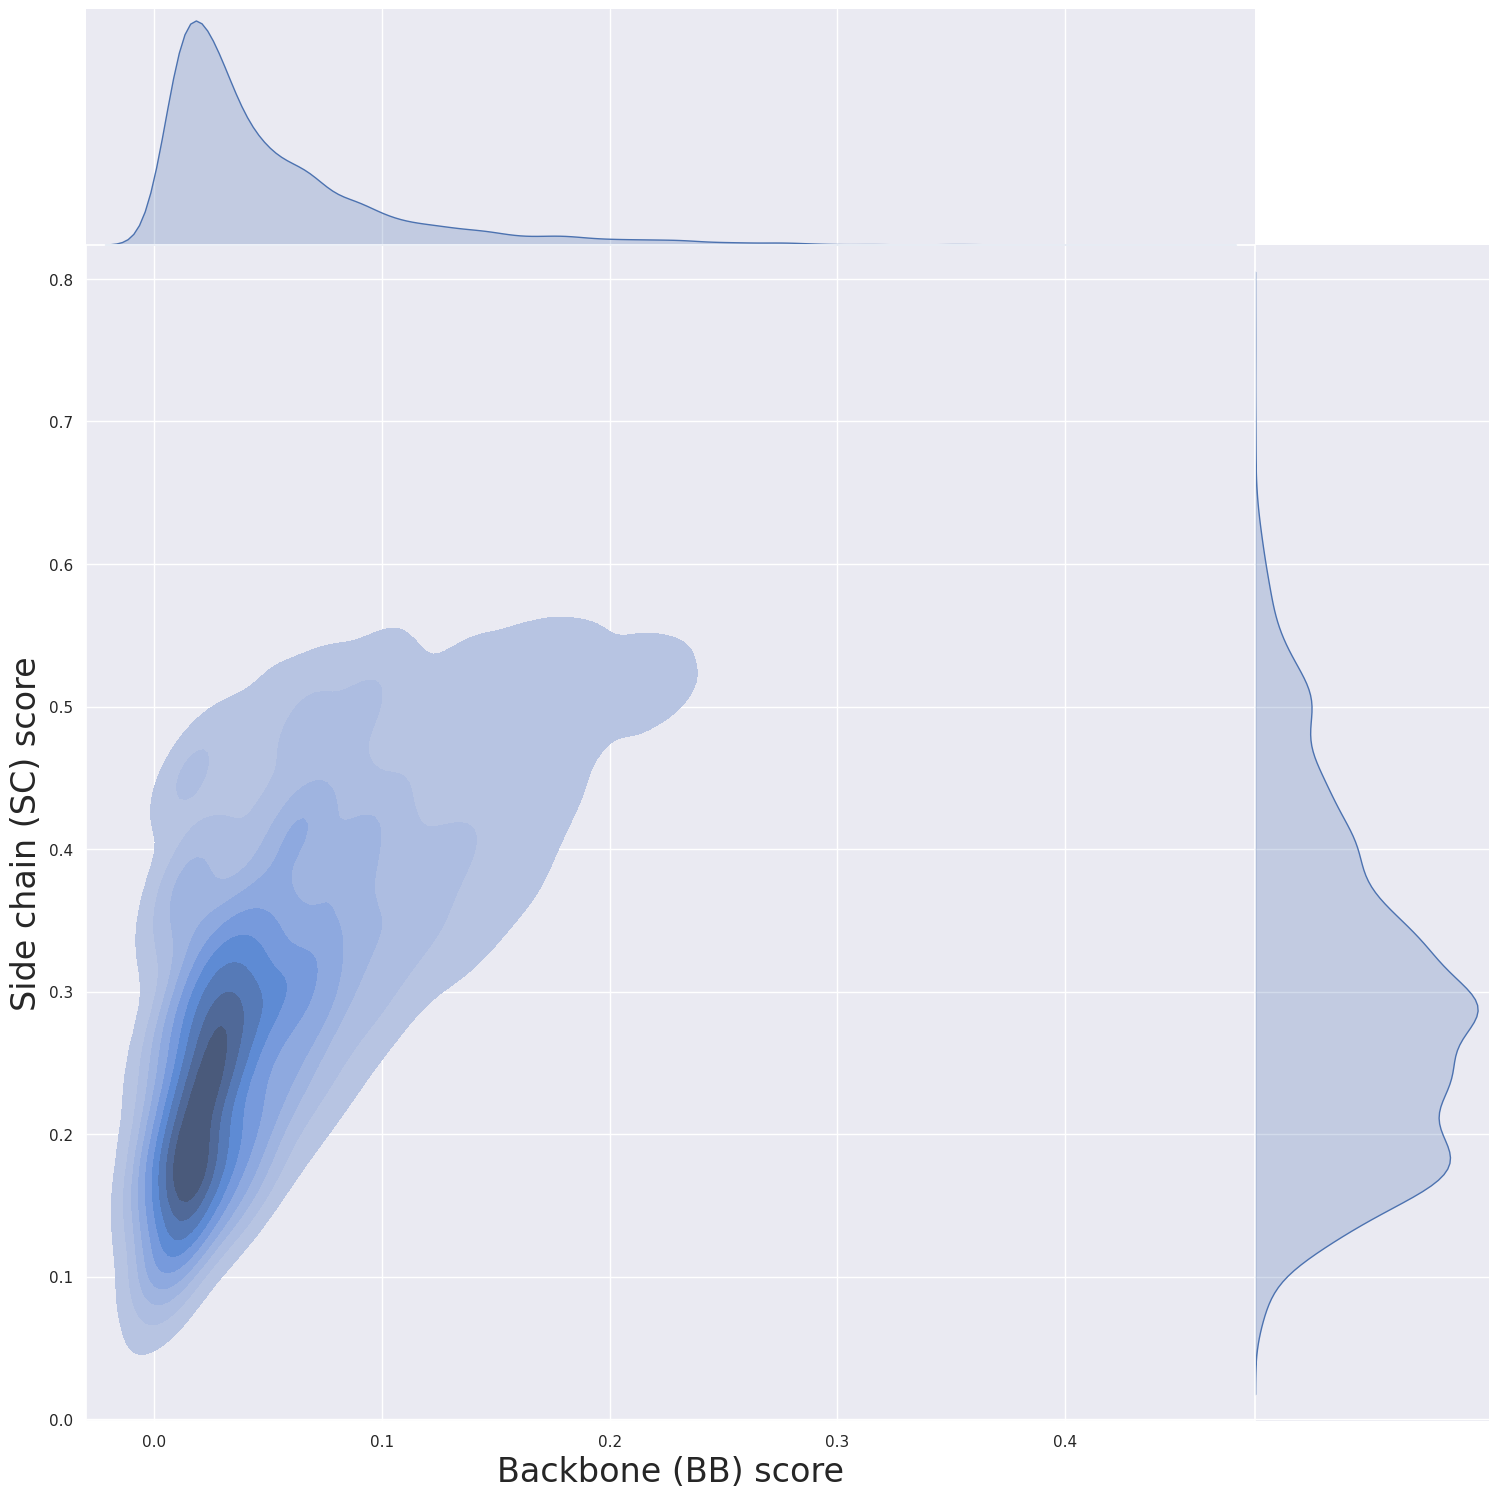

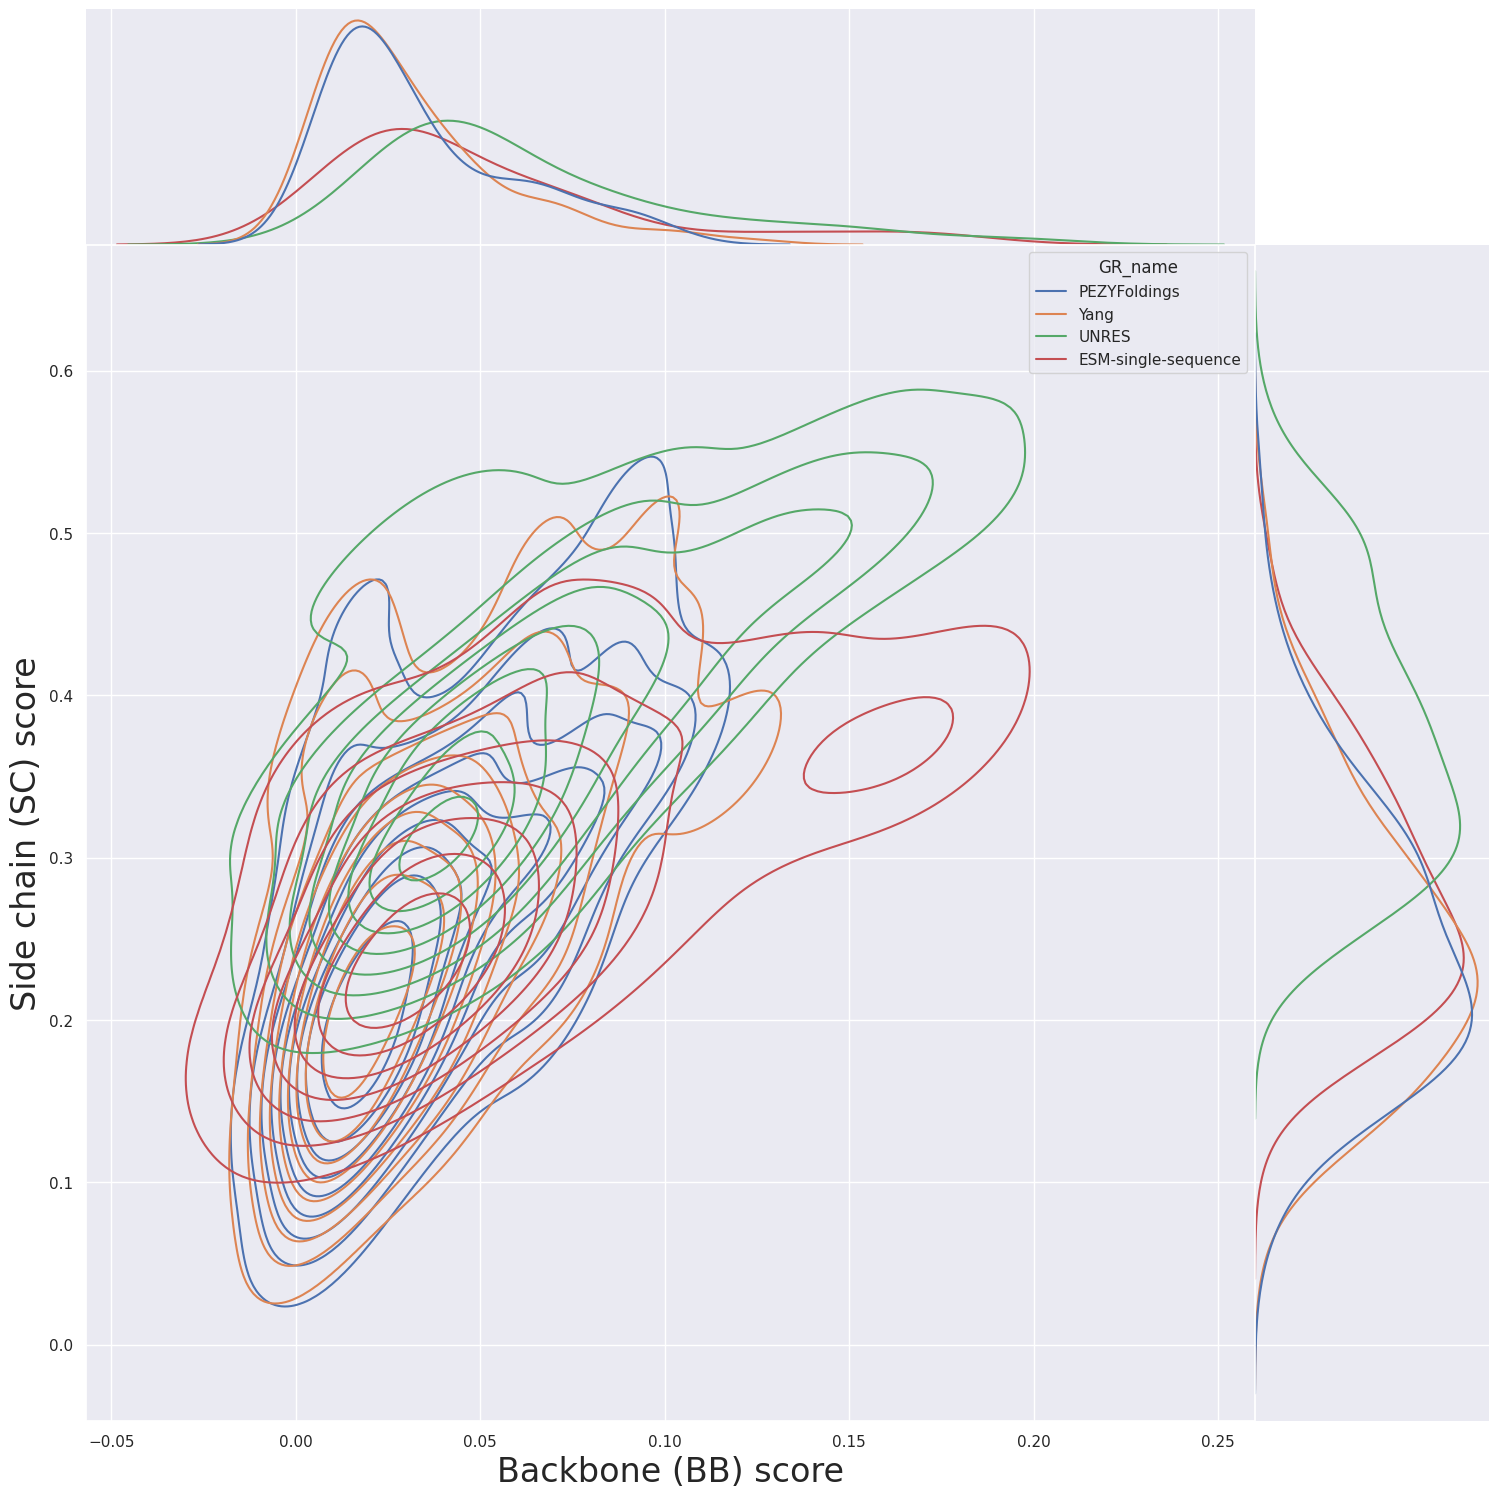

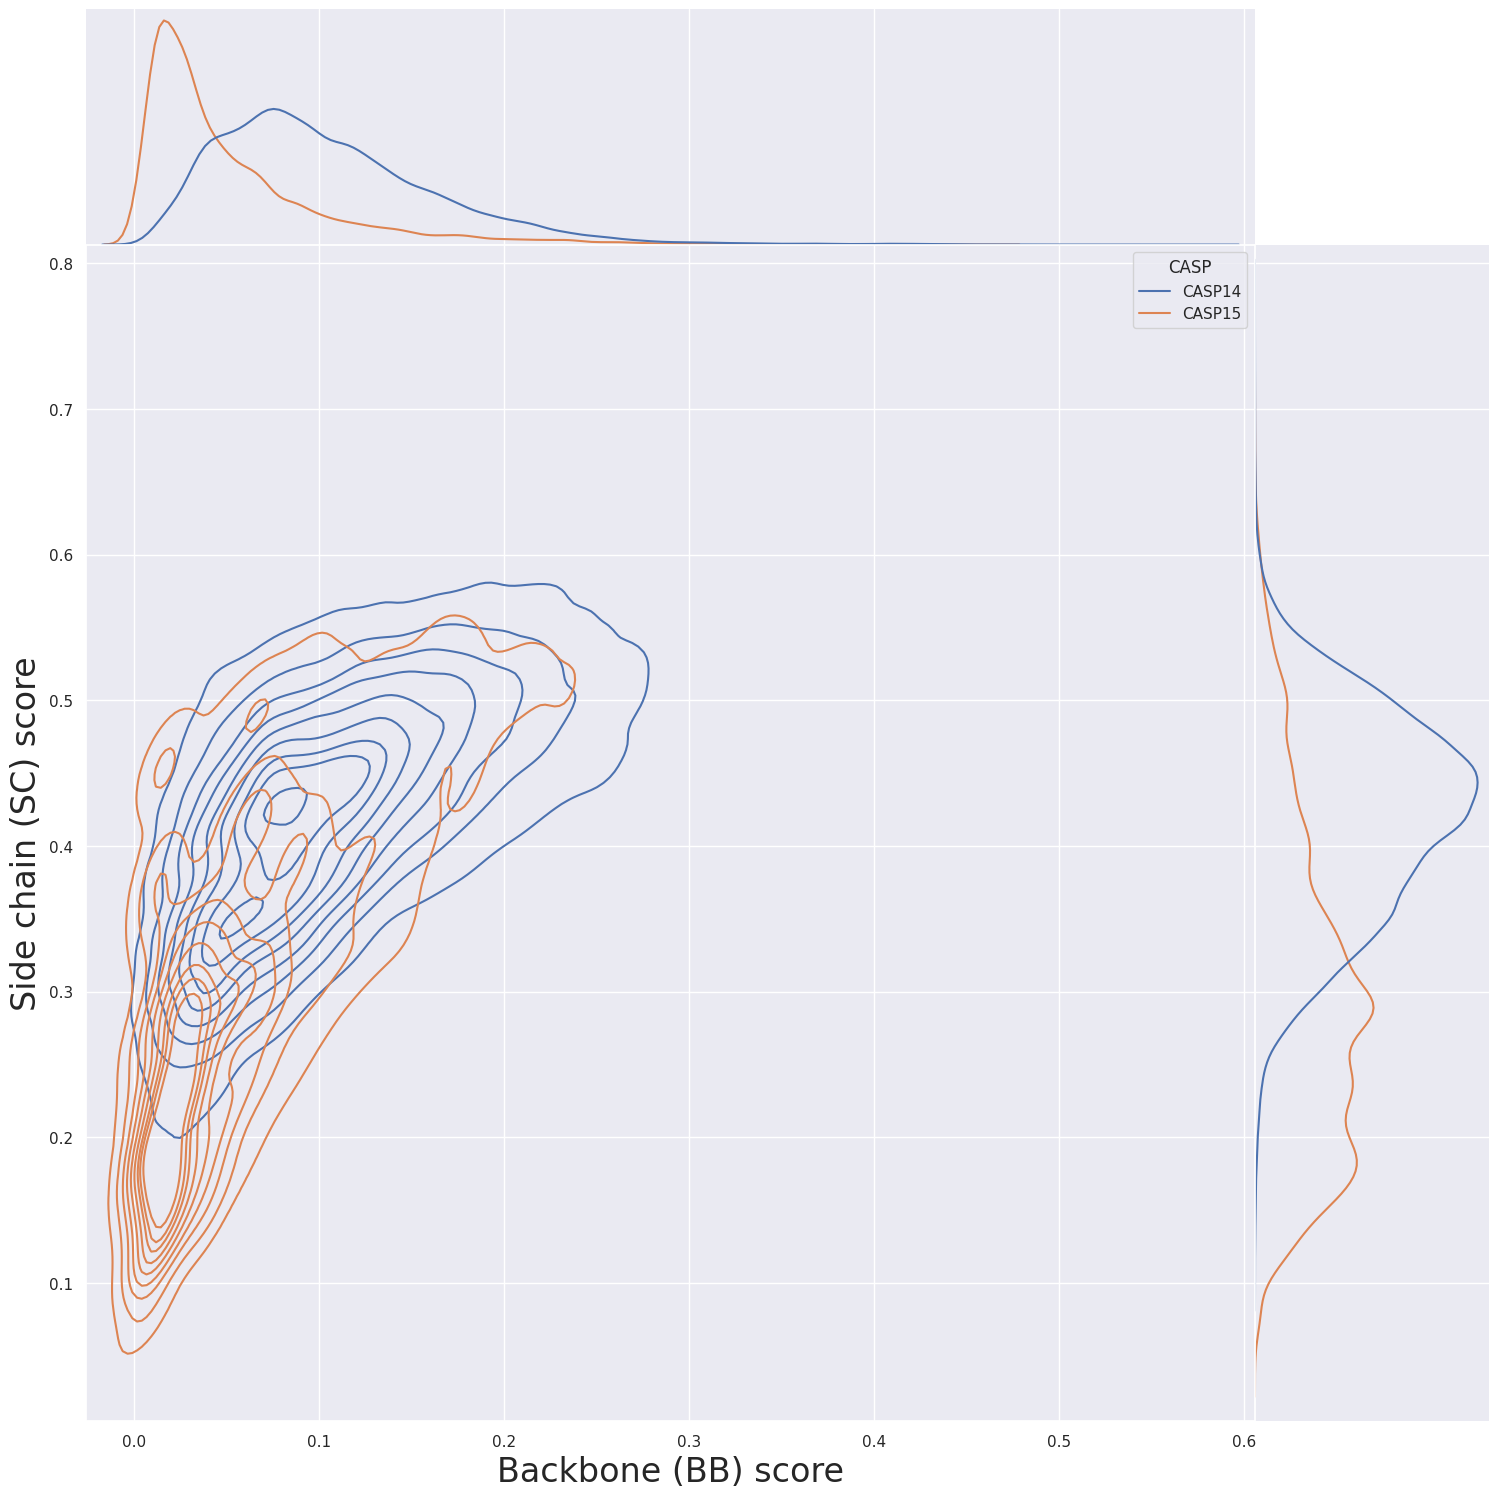

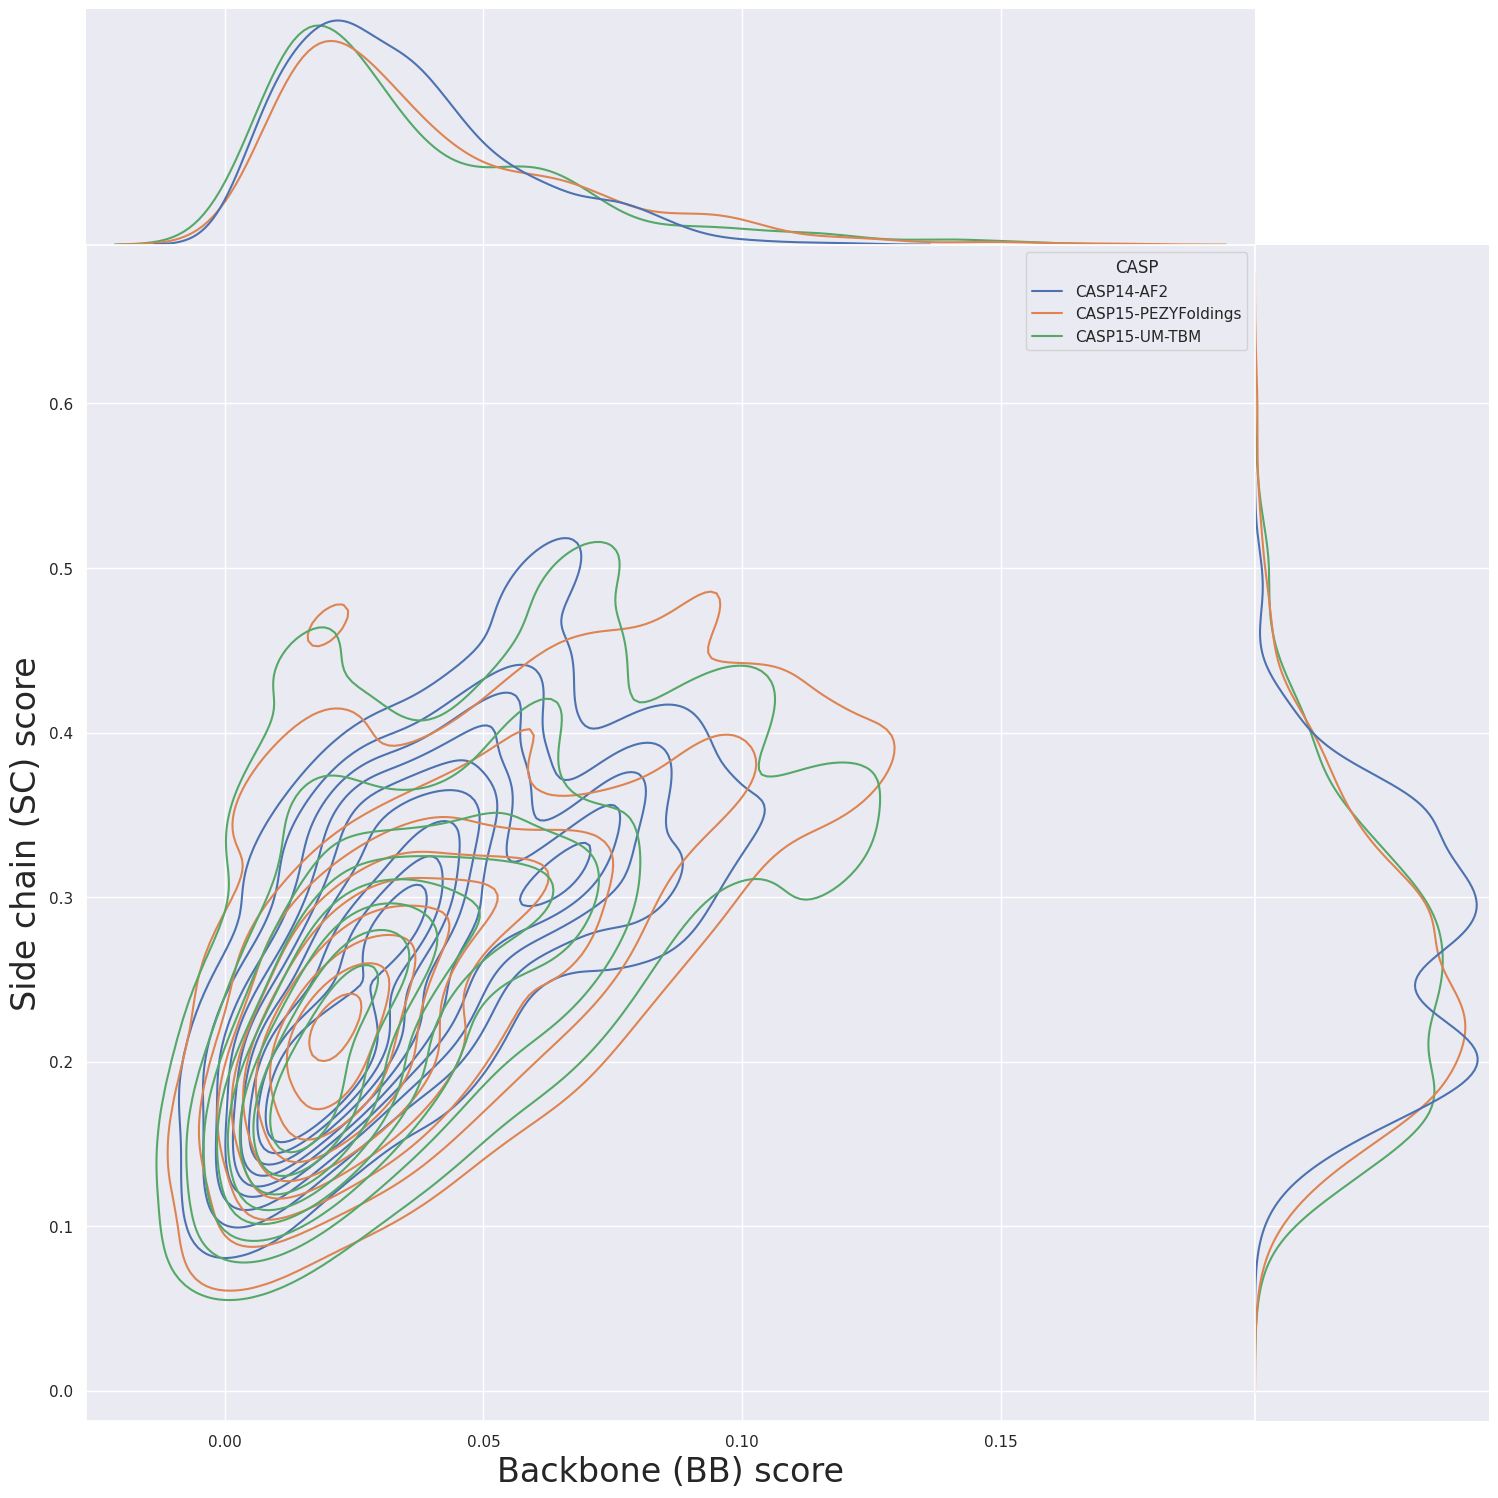

In [33]:
def mc_vs_sc_jointplot(input_df, top_groups=False, plot_type='all', label='all'):
    if plot_type == 'all':
        g = sns.jointplot(data=input_df, x='Model_BBscore', y='Model_SCscore', kind="kde", fill=True, height=15, space=0, label='All')
    elif plot_type == 'select':
        g = sns.jointplot(data=input_df, x='Model_BBscore', y='Model_SCscore', kind="kde", hue='GR_name', height=15, space=0, hue_order=['PEZYFoldings', 'Yang', 'UNRES', 'ESM-single-sequence'], label='All')
    elif plot_type == 'comp':
        g = sns.jointplot(data=input_df, x='Model_BBscore', y='Model_SCscore', kind="kde", hue='CASP', height=15, space=0, label='All')
    g.set_axis_labels('Backbone (BB) score', 'Side chain (SC) score', fontsize=24)
    
    
    if top_groups:
        input_df = input_df[input_df['GR_name'].isin(top_groups)]
        sns.kdeplot(x=input_df['Model_BBscore'].values, y=input_df['Model_SCscore'].values, ax=g.ax_joint, color=sns.color_palette()[1], alpha=0.8, label='Top Groups')
        sns.kdeplot(x=input_df['Model_BBscore'].values, linewidth=1, ax=g.ax_marg_x, color=sns.color_palette()[1], alpha=0.8)
        sns.kdeplot(y=input_df['Model_SCscore'].values, linewidth=1, ax=g.ax_marg_y, color=sns.color_palette()[1], alpha=0.8)
        legendMain=g.ax_joint.legend(loc='upper right')
        label = 'Top{}'.format(len(top_groups))
    

    plt.savefig("{}/mc_vs_sc_jointplt_{}_{}.png".format(figures_folder, label, plot_type), bbox_inches='tight')
    plt.show()


# Plot all groups
mc_vs_sc_jointplot(df_1st, top_groups=False, plot_type='all', label='All')

# Plot select CASP15 groups
tmp_df = df_1st[df_1st['GR_name'].isin(['PEZYFoldings', 'Yang', 'UNRES', 'ESM-single-sequence'])]
mc_vs_sc_jointplot(tmp_df, top_groups=False, plot_type='select', label='All')

# Plot CASP14 data against CASP15 data
model_bb = []
model_sc = []
casp = []
casp14_zscore_table = 'CASP14/CASP14_Zscores_table.csv'

if os.path.isfile(casp14_zscore_table):
    casp14_df = pd.read_csv(casp14_zscore_table, sep='\t').reset_index(drop=True)
    model_bb += list(casp14_df.Model_BBscore.values)
    model_sc += list(casp14_df.Model_SCscore.values)
    casp += ['CASP14' for i in range(len(casp14_df.Model_BBscore.values))]
else:
    print('Need to provide CASP14 data for this comparison')

casp15_df = df.copy()
model_bb += list(casp15_df.Model_BBscore.values)
model_sc += list(casp15_df.Model_SCscore.values)
casp += ['CASP15' for i in range(len(casp15_df.Model_BBscore.values))]

tmp_df = pd.DataFrame({'Model_BBscore': model_bb, 'Model_SCscore': model_sc, 'CASP': casp})

mc_vs_sc_jointplot(tmp_df, top_groups=False, plot_type='comp', label='All')

# Plot AF2 from CASP14 versus CASP15 top groups
model_bb = []
model_sc = []
casp = []
if os.path.isfile(casp14_zscore_table):
    casp14_df = casp14_df[casp14_df['GR_name'] == 'AlphaFold2']
    model_bb += list(casp14_df.Model_BBscore.values)
    model_sc += list(casp14_df.Model_SCscore.values)
    casp += ['CASP14-AF2' for i in range(len(casp14_df.Model_BBscore.values))]
else:
    print('Need to provide CASP14 data for this comparison')

for group in ['PEZYFoldings', 'UM-TBM']:
    casp15_df = df[df['GR_name'].isin([group])]
    model_bb += list(casp15_df.Model_BBscore.values)
    model_sc += list(casp15_df.Model_SCscore.values)
    casp += ['CASP15-{}'.format(group) for i in range(len(casp15_df.Model_BBscore.values))]

tmp_df = pd.DataFrame({'Model_BBscore': model_bb, 'Model_SCscore': model_sc, 'CASP': casp})
mc_vs_sc_jointplot(tmp_df, top_groups=False, plot_type='comp', label='All')

In [34]:
# Rank by GDT_HA, only consider models where SCWRL score could be calculated.
df_tmp = df.copy()
df_tmp = df_tmp[df_tmp['SCWRL_PC'].notna()]
idx = df_tmp.groupby(['Target'])['GDT_HA'].transform(max) == df_tmp['GDT_HA']

target_df_top = df_tmp[idx]
target_df_top = target_df_top.drop_duplicates(subset='Target', keep="first")

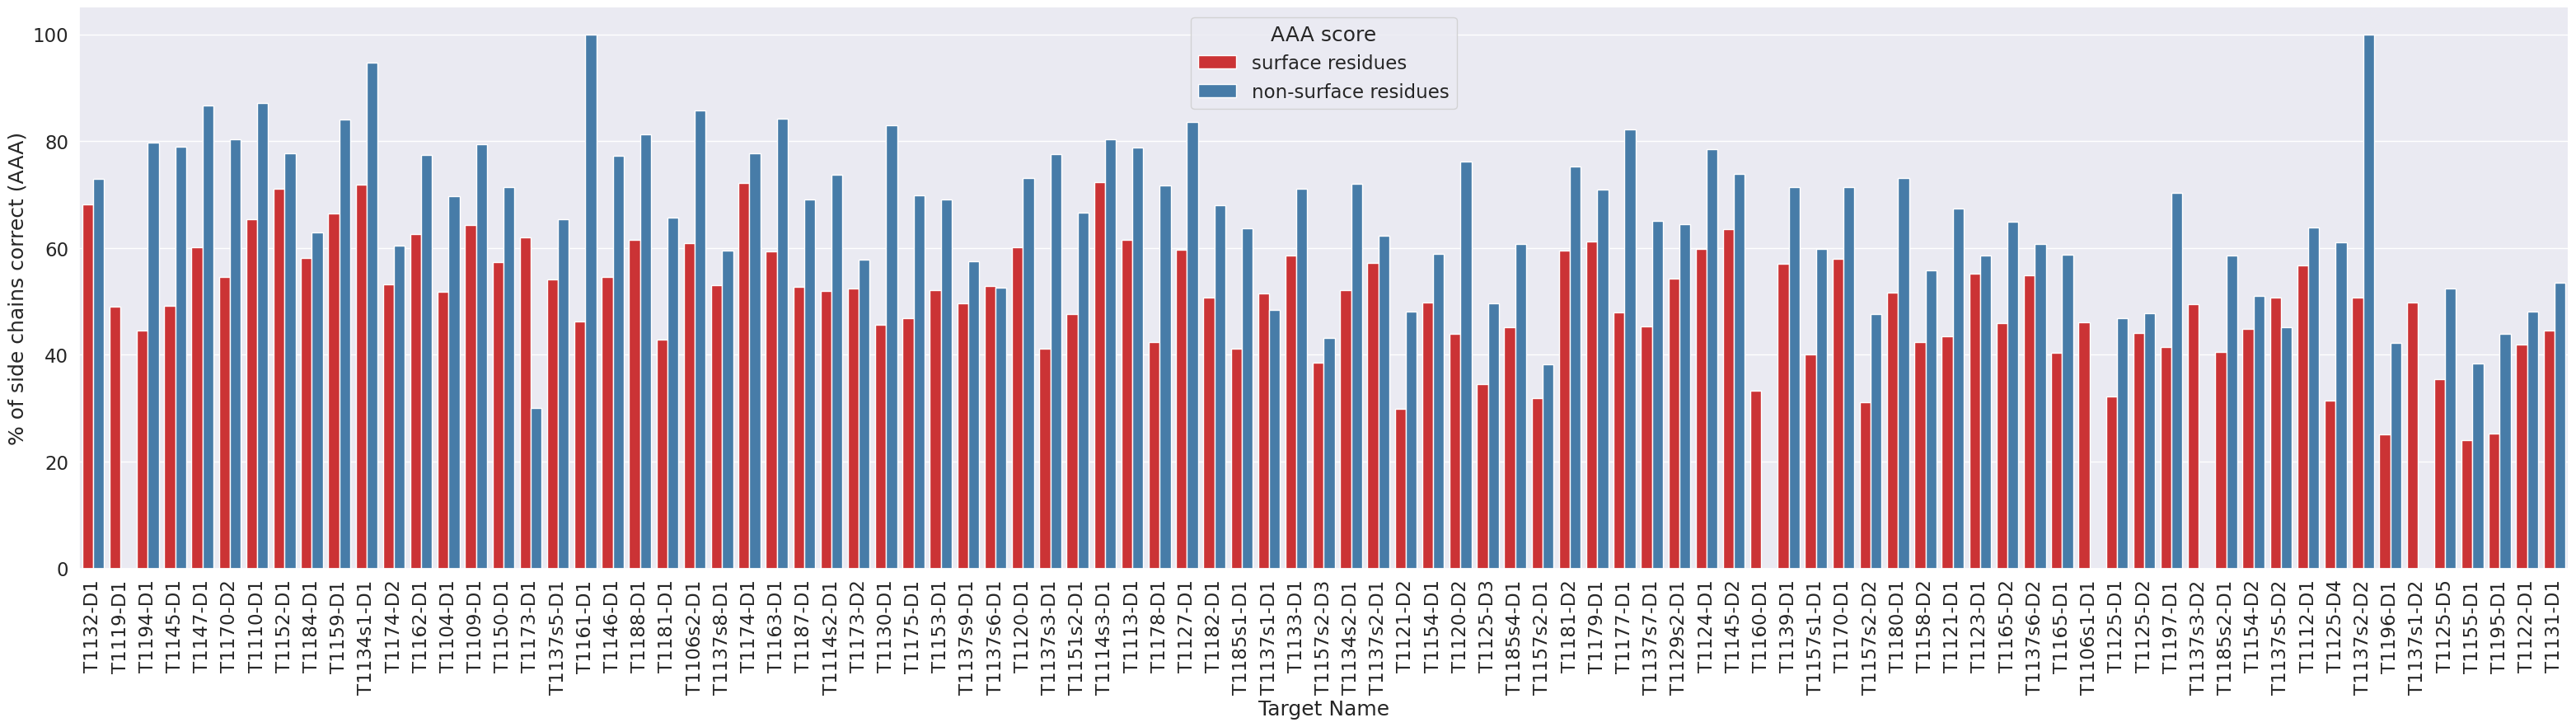

In [35]:
def bar_side_chain_errors(target_df):
    sorted_nb = target_df.sort_values(['GDT_HA'], ascending=False)

    df_temp = target_df[['Target', 'SCWRL_PC_surface', 'SCWRL_PC_nonsurface']]
    df_temp = df_temp.rename(columns={'SCWRL_PC_surface' : 'surface residues', 'SCWRL_PC_nonsurface' : 'non-surface residues'})
    dfs1 = pd.melt(df_temp, id_vars = "Target")
    dfs1 = dfs1.rename(columns={"variable": "Targets"})
    
    sns.set(font_scale=1.5)
    g = sns.factorplot(x = 'Target', y='value', hue = 'Targets',data=dfs1, height=8, aspect=4, kind='bar', order=(sorted_nb['Target'].values), palette='Set1', legend_out=False)
    plt.xticks(rotation=90)
    plt.ylabel("% of side chains correct (AAA)", fontsize=18)
    plt.xlabel("Target Name", fontsize=18)
    
    g.legend.set_title('AAA score')
    
    plt.savefig("{}/surface_vs_non-surface_barplot.png".format(figures_folder), bbox_inches='tight')
    plt.show()
    

bar_side_chain_errors(target_df_top)